In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline 
rcParams['figure.figsize']=20,10
sns.set(color_codes=True)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [37]:
# utility functions
# aggregate by each date
def aggregate_by_date(df):
    #aggregate by dates
    df_agg = df.groupby('DATE').agg(SOLD_QUANTITY = pd.NamedAgg(column = "SOLD_QUANTITY", aggfunc = sum),
                                    ORDER_QUANTITY = pd.NamedAgg(column = "ORDER_QUANTITY", aggfunc = sum))
    df_agg.reset_index(level=0, inplace=True)
    return df_agg

# make dates continuous
def fill_in_missing_dates(df):
    date1 = min(df.DATE)
    date2 = max(df.DATE)
    daterange_serial = []
    for n in range(int ((date2 - date1).days)+1):
        daterange_serial.append(date1 + pd.DateOffset(n))
        df_dates = pd.DataFrame(daterange_serial, columns = ['DATE'])
    df_dates_filled = pd.merge(df_dates, df, how="left", on="DATE")
    df_dates_filled = df_dates_filled.fillna(0)
    return df_dates_filled

#plot the sold and order quantity by time
def plot_sold_order_by_date(df):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_axes([.1,.1,1,1])
    ax.plot(df.DATE, df['SOLD_QUANTITY'],'red')
    ax.plot(df.DATE, df['ORDER_QUANTITY'],'blue')
    # rotate and align the tick labels so they look better
    # fig.autofmt_xdate()
    ax.set_title('SOLD vs. ORDER')
    ax.set_xlabel('Date')
    ax.set_ylabel('Quantity')
    ax.legend(['SOLD','ORDER'])
    
#plot the accumulative sold and order quantity by time
def plot_sold_order_acc_by_date(df):
    
    sold_acc = df.SOLD_QUANTITY.cumsum()
    order_acc = df.ORDER_QUANTITY.cumsum()
    overstock = order_acc - sold_acc

    fig = plt.figure(figsize=(20,10))
    ax = fig.add_axes([.1,.1,1,1])
    ax.plot(df.DATE, sold_acc,'r')
    ax.plot(df.DATE, order_acc,'k')
    ax.plot(df.DATE, overstock,'b')

    ax.set_xlabel('Date')
    ax.set_ylabel('Quantity')
    ax.legend(['sold_acc', 'order_acc', 'overstock'])

# remove data prior to the cut off dates, to remove the large period of time without any data
def remove_dates_priorto_cutoff(df, date_cutoff_str):
    df = df[df['DATE'] > pd.to_datetime(date_cutoff_str)]
    return df

# calculate the power
def calculate_frequency(data):
    fft_data = np.fft.fft(data)/len(data)
    fft_data = fft_data[range(int(len(data)/2))]
    #adjust the 1Hz sampling rate (a datapoint a day) to the fft window
    frequency = np.arange(int(len(data)/2))/len(data)*1 
    return fft_data, frequency

#plot the power spectrom of order and sold in a given df
def plot_frequency(df):
    fft_data1, frequency = calculate_frequency(df.ORDER_QUANTITY)
    fft_data2, frequency = calculate_frequency(df.SOLD_QUANTITY)
    fig = plt.figure()
    ax = fig.add_axes([.1,.1,1,1])
    ax.set_title('Fourier transform depicting the frequency components')
    ax.plot(frequency, abs(fft_data1), 'blue')
    ax.plot(frequency, abs(fft_data2), 'red')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Amplitude')
    ax.legend(['order', 'sold'])   

#combine three functions: aggregate_by_date, fill_in_missing_dates, remove_dates_priorto_cutoff
def aggregate_fillindates_removecutoff(df, date_cutoff_str):
    df = aggregate_by_date(df)
    df = fill_in_missing_dates(df)
    df = remove_dates_priorto_cutoff(df, date_cutoff_str)
    return df

# combining the filter and plotting, call it for each disease_name
def plot_by_disease_name(df, disease_name):
    df_filtered = aggregate_fillindates_removecutoff(df[df['DISEASE_NAME']==disease_name], '2019-05-01')
    plot_sold_order_by_date(df_filtered)
    plot_sold_order_acc_by_date(df_filtered)
    plot_frequency(df_filtered)
    return df_filtered

# combining the filter and plotting, call it for each city
def plot_by_city_name(df, city_name):
    df_filtered = aggregate_fillindates_removecutoff(df[df['CITY']==city_name], '2019-05-01')
    plot_sold_order_by_date(df_filtered)
    plot_sold_order_acc_by_date(df_filtered)
    plot_frequency(df_filtered)
    return df_filtered



# 1. import the data

In [3]:
df = pd.read_csv('order_lookup_city_CSV.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13666 entries, 0 to 13665
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE                 13666 non-null  object 
 1   ME_ID                13666 non-null  object 
 2   DISEASE_ID           13666 non-null  object 
 3   ORDER_QUANTITY       13666 non-null  object 
 4   ORDER_FREE_QUANTITY  13666 non-null  float64
 5   SOLD_QUANTITY        13666 non-null  object 
 6   SOLD_FREE            13665 non-null  object 
 7   MEDICINE_NAME        13666 non-null  object 
 8   DISEASE_NAME         13666 non-null  object 
 9   CITY                 13666 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.0+ MB


# 2. Preprocess
## 2.1 check missing value and decide to drop or replace
## modified df

In [5]:
# check missing value
print(df.isnull().sum())

DATE                   0
ME_ID                  0
DISEASE_ID             0
ORDER_QUANTITY         0
ORDER_FREE_QUANTITY    0
SOLD_QUANTITY          0
SOLD_FREE              1
MEDICINE_NAME          0
DISEASE_NAME           0
CITY                   0
dtype: int64


In [6]:
df[df.SOLD_FREE.isnull()].index.to_list()

[270]

In [7]:
# check the row when SOLD_FREE is NaN. looks like a valuable row to keep (ORDER_QUANTITY = 1076) 
df.iloc[270,:]

DATE                         01-04-2019
ME_ID                            AM2020
DISEASE_ID                       BL2020
ORDER_QUANTITY                1,076.00 
ORDER_FREE_QUANTITY                   0
SOLD_QUANTITY                         0
SOLD_FREE                           NaN
MEDICINE_NAME          AMLOKIND AT -TAB
DISEASE_NAME             BLOOD PRESSURE
CITY                         VIJAYAWADA
Name: 270, dtype: object

In [8]:
# SOLD_FREE is usually a percentage of SOLD_QUANTITY. So filling this with 0 should be fine.
# fill the NaN in SOLD_FREE with '0' because it was a string
df.SOLD_FREE = df.SOLD_FREE.fillna('0')

In [9]:
print(df.isnull().sum())

DATE                   0
ME_ID                  0
DISEASE_ID             0
ORDER_QUANTITY         0
ORDER_FREE_QUANTITY    0
SOLD_QUANTITY          0
SOLD_FREE              0
MEDICINE_NAME          0
DISEASE_NAME           0
CITY                   0
dtype: int64


## 2.2 convert data types for some columns
## modified df

In [10]:
# convert the following columns to numeric
df['ORDER_QUANTITY'] = pd.to_numeric(df.ORDER_QUANTITY.apply(lambda x: x.replace(',','').replace(' ','')))
df['SOLD_QUANTITY'] = pd.to_numeric(df.SOLD_QUANTITY.apply(lambda x: x.replace(',','').replace(' ','')))
df['SOLD_FREE'] = pd.to_numeric(df.SOLD_FREE.apply(lambda x: x.replace(',','').replace(' ','')))

In [11]:
# convert Date
df['DATE'] = pd.to_datetime(df.DATE, dayfirst = True)
# Add columns for year, month, day, weekday
df['year'] = df.DATE.apply(lambda x:x.year).astype(str)
df['month'] = df.DATE.apply(lambda x:x.month).astype(str)
df['day'] = df.DATE.apply(lambda x:x.day).astype(str)
df['weekday'] = df.DATE.apply(lambda x:x.weekday()).astype(str)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13666 entries, 0 to 13665
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE                 13666 non-null  datetime64[ns]
 1   ME_ID                13666 non-null  object        
 2   DISEASE_ID           13666 non-null  object        
 3   ORDER_QUANTITY       13666 non-null  float64       
 4   ORDER_FREE_QUANTITY  13666 non-null  float64       
 5   SOLD_QUANTITY        13666 non-null  float64       
 6   SOLD_FREE            13666 non-null  float64       
 7   MEDICINE_NAME        13666 non-null  object        
 8   DISEASE_NAME         13666 non-null  object        
 9   CITY                 13666 non-null  object        
 10  year                 13666 non-null  object        
 11  month                13666 non-null  object        
 12  day                  13666 non-null  object        
 13  weekday              13666 non-

In [13]:
df.head(20)

DATE   ME_ID DISEASE_ID  ORDER_QUANTITY  ORDER_FREE_QUANTITY  \
0  2018-04-01  AM2020     BL2020            42.0                  0.0   
1  2018-04-01  AM2020     BL2020           480.0                  0.0   
2  2018-04-02  AM2020     BL2020             0.0                  0.0   
3  2018-04-02  AM2020     BL2020             0.0                  0.0   
4  2018-04-02  AM2020     BL2020             0.0                  0.0   
5  2018-04-02  AM2020     BL2020             0.0                  0.0   
6  2018-04-02  AM2020     BL2020             0.0                  0.0   
7  2018-04-05  AM2020     BL2020             0.0                  0.0   
8  2018-04-06  AM2020     BL2020             0.0                  0.0   
9  2018-04-06  AM2020     BL2020             0.0                  0.0   
10 2018-04-06  AM2020     BL2020             0.0                  0.0   
11 2018-04-06  AM2020     BL2020             0.0                  0.0   
12 2018-04-07  AM2020     BL2020             0.0                  0.0   
13 2018-04-07  AM2020     BL2020             0.0                  0.0   
14 2018-04-07  AM2020     BL2020             0.0                  0.0   
15 2018-04-09  AM2020     BL2020           330.0                 30.0   
16 2018-04-10  AM2020     BL2020             0.0                  0.0   
17 2018-04-10  AM2020     BL2020             0.0                  0.0   
18 2018-04-13  AM2020     BL2020           220.0                 20.0   
19 2018-04-23  AM2020     BL2020             0.0                  0.0   

    SOLD_QUANTITY  SOLD_FREE     MEDICINE_NAME    DISEASE_NAME  \
0             0.0        0.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
1             0.0        0.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
2            25.0        5.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
3            25.0        5.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
4            10.0        2.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
5            25.0        5.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
6            11.0        1.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
7           100.0       20.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
8           100.0       20.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
9            20.0        0.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
10            5.0        5.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
11           10.0        2.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
12           10.0        2.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
13           50.0       10.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
14           25.0        5.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
15            0.0        0.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
16           11.0        1.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
17          110.0       10.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
18            0.0        0.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
19           11.0        1.0  AMLOKIND AT -TAB  BLOOD PRESSURE   

              CITY  year month day weekday  
0          NO_CITY  2018     4   1       6  
1          NO_CITY  2018     4   1       6  
2   SINGARAYAKONDA  2018     4   2       0  
3   SINGARAYAKONDA  2018     4   2       0  
4         KANDUKUR  2018     4   2       0  
5         KANDUKUR  2018     4   2       0  
6         KANDUKUR  2018     4   2       0  
7           ONGOLE  2018     4   5       3  
8           ONGOLE  2018     4   6       4  
9         KANIGIRI  2018     4   6       4  
10        KANIGIRI  2018     4   6       4  
11  SINGARAYAKONDA  2018     4   6       4  
12          ONGOLE  2018     4   7       5  
13           DARSI  2018     4   7       5  
14          PODILI  2018     4   7       5  
15      VIJAYAWADA  2018     4   9       0  
16          ONGOLE  2018     4  10       1  
17          ONGOLE  2018     4  10       1  
18      VIJAYAWADA  2018     4  13       4  
19        KANDUKUR  2018     4  23       0

In [14]:
df.describe()

ORDER_QUANTITY  ORDER_FREE_QUANTITY  SOLD_QUANTITY     SOLD_FREE
count    13666.000000         13666.000000   13666.000000  13666.000000
mean        40.483463             1.535490      36.523196      2.400922
std        311.539225            24.490836      87.914360     15.055957
min          0.000000             0.000000       0.000000      0.000000
25%          0.000000             0.000000       5.000000      0.000000
50%          0.000000             0.000000      11.000000      0.000000
75%          0.000000             0.000000      38.000000      1.000000
max      10840.000000           960.000000    3840.000000   1000.000000

## 2.3 drop duplicates (? should we?)
## modified df

In [15]:
duplicate_rows_df = df[df.duplicated()]
print('number of duplicate rows: ', duplicate_rows_df.shape)

number of duplicate rows:  (422, 14)


In [16]:
duplicate_rows_df.head(20)

DATE   ME_ID DISEASE_ID  ORDER_QUANTITY  ORDER_FREE_QUANTITY  \
3   2018-04-02  AM2020     BL2020             0.0                  0.0   
60  2018-06-04  AM2020     BL2020             0.0                  0.0   
89  2018-06-22  AM2020     BL2020             0.0                  0.0   
128 2018-04-02  CA2020     BL2020             0.0                  0.0   
140 2018-04-07  CA2020     BL2020             0.0                  0.0   
156 2018-04-18  CA2020     BL2020             0.0                  0.0   
159 2018-04-18  CA2020     BL2020             0.0                  0.0   
160 2018-04-18  CA2020     BL2020             0.0                  0.0   
242 2018-06-30  CA2020     BL2020             0.0                  0.0   
274 2019-05-21  AM2020     BL2020             0.0                  0.0   
301 2019-06-04  AM2020     BL2020             0.0                  0.0   
353 2019-07-20  AM2020     BL2020             0.0                  0.0   
433 2019-10-11  AM2020     BL2020             0.0                  0.0   
439 2019-10-14  AM2020     BL2020             0.0                  0.0   
440 2019-10-14  AM2020     BL2020             0.0                  0.0   
453 2019-10-18  AM2020     BL2020             0.0                  0.0   
521 2019-12-14  AM2020     BL2020             0.0                  0.0   
542 2020-01-01  AM2020     BL2020             0.0                  0.0   
543 2020-01-01  AM2020     BL2020             0.0                  0.0   
563 2020-01-20  AM2020     BL2020             0.0                  0.0   

     SOLD_QUANTITY  SOLD_FREE     MEDICINE_NAME    DISEASE_NAME  \
3             25.0        5.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
60             2.0        0.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
89           220.0       20.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
128            3.0        0.0           CARDACE  BLOOD PRESSURE   
140           15.0        0.0           CARDACE  BLOOD PRESSURE   
156           15.0        0.0           CARDACE  BLOOD PRESSURE   
159           15.0        0.0           CARDACE  BLOOD PRESSURE   
160           15.0        0.0           CARDACE  BLOOD PRESSURE   
242           15.0        0.0           CARDACE  BLOOD PRESSURE   
274          110.0       10.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
301           11.0        1.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
353           11.0        1.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
433           33.0        3.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
439          110.0       10.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
440          550.0       50.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
453          110.0       10.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
521          110.0       10.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
542           55.0        5.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
543           55.0        5.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
563            2.0        2.0  AMLOKIND AT -TAB  BLOOD PRESSURE   

               CITY  year month day weekday  
3    SINGARAYAKONDA  2018     4   2       0  
60   SINGARAYAKONDA  2018     6   4       0  
89          CHIRALA  2018     6  22       4  
128          KAVALI  2018     4   2       0  
140        KANDUKUR  2018     4   7       5  
156         ADDANKI  2018     4  18       2  
159         ADDANKI  2018     4  18       2  
160          ONGOLE  2018     4  18       2  
242          ONGOLE  2018     6  30       5  
274        KANDUKUR  2019     5  21       1  
301          KAVALI  2019     6   4       1  
353        KANDUKUR  2019     7  20       5  
433     CHIMAKURTHY  2019    10  11       4  
439          PODILI  2019    10  14       0  
440        KANDUKUR  2019    10  14       0  
453          KAVALI  2019    10  18       4  
521      VIJAYAWADA  2019    12  14       5  
542          KAVALI  2020     1   1       2  
543          KAVALI  2020     1   1       2  
563          KAVALI  2020     1  20       0

In [17]:
df = df.drop_duplicates()

In [18]:
df.count()

DATE                   13244
ME_ID                  13244
DISEASE_ID             13244
ORDER_QUANTITY         13244
ORDER_FREE_QUANTITY    13244
SOLD_QUANTITY          13244
SOLD_FREE              13244
MEDICINE_NAME          13244
DISEASE_NAME           13244
CITY                   13244
year                   13244
month                  13244
day                    13244
weekday                13244
dtype: int64

## 2.4 find out the unique categories 
## (df was not modified)
* MED_ID, DISEASE_NAME are good columns to use  
* CITY, what does NO_CITY mean?  
* Not many transactions on Saturday

In [19]:
df_ = df.select_dtypes(exclude=['datetime64[ns]', 'float64'])
for col in df_.columns:
    print(df_[col].unique()) # to print categories name only
    print(df_[col].value_counts().sort_index()) # to print count of every category
    print('\n')

['AM2020' 'CA2020' 'CO2020' 'FL2020' 'BE2020' 'TE2020' 'GE2020' 'MU2020'
 'NE2020' 'DA2020' 'GL2020' 'JA2020' 'EL2020']
AM2020     524
BE2020    2436
CA2020     312
CO2020    2656
DA2020     482
EL2020    2615
FL2020     113
GE2020     727
GL2020     793
JA2020    1145
MU2020     507
NE2020     223
TE2020     711
Name: ME_ID, dtype: int64


['BL2020' 'FE2020' 'FI2020' 'GA2020' 'AL2020' 'DI2020' 'TH2020']
AL2020     443
BL2020     835
DI2020    2420
FE2020    2770
FI2020    2927
GA2020    1234
TH2020    2615
Name: DISEASE_ID, dtype: int64


['AMLOKIND AT -TAB' 'CARDACE' 'CARDACE 2.5MG' 'COLPOL500MG' 'COLPOL650MG'
 'COMBIFLAM SYRUP 60ML' 'COMBIFLAM TABLET' 'FLEXONA TAB' 'COLPOL 500MG'
 'COLPOL 600MG' 'COMBIFLAM SYRUP' 'FLEXONA TABLET' 'BETNOVET-C OINTMENT'
 'BETNOVETGM-OINTMENT' 'BETNOVET N-OINTMENT' 'TETVAC-AMPLES'
 'BETNOVIT C-O' 'BETNOVITGM-O' 'BETNOVET N-O' 'TETVAC-AMPS' 'GELSIL-SYP'
 'GELSIL-TAB' 'MUCAINE-SYP' 'NEKO-SOAP' 'TETMOSOL-SOAP' 'DAONIL-TAB'
 'GLYCOMET-1TAB' 'GLYCOMET-TAB' 

In [20]:
# fix the misspelled DISEASE_NAME "GASTIRC"
df['DISEASE_NAME'] = df.DISEASE_NAME.apply(lambda x:"GASTRIC" if "GASTIRC" in x else x)

In [21]:
print(df['DISEASE_NAME'].unique()) 
print(df['DISEASE_NAME'].value_counts().sort_index()) 


['BLOOD PRESSURE' 'FEVER' 'FIRST-AID' 'GASTRIC' 'ALLERGIES' 'DIABETIES'
 'THYROID']
ALLERGIES          443
BLOOD PRESSURE     835
DIABETIES         2420
FEVER             2770
FIRST-AID         2927
GASTRIC           1234
THYROID           2615
Name: DISEASE_NAME, dtype: int64


In [22]:
# merged some city names
df['CITY'] = df.CITY.apply(lambda x:"DODDAVARAM" if 'DODDAVARAM' in x else x)
print(df['CITY'].unique()) 
print(df['CITY'].value_counts().sort_index()) 


['NO_CITY' 'SINGARAYAKONDA' 'KANDUKUR' 'ONGOLE' 'KANIGIRI' 'DARSI'
 'PODILI' 'VIJAYAWADA' 'EDUMUDI' 'CHIMAKURTHY' 'PERNAMITTA' 'TANGUTUR'
 'TALLURU' 'KONIJEDU' 'KAVALI' 'ULAVAPADU' 'MEDARAMETLA' 'ADDANKI'
 'CHIRALA' 'PAMUR' 'NIDAMANUR' 'EAST GANGAVARAM' 'MARKAPURAM' 'KARAVADI'
 'DODDAVARAM' 'ULICHI' 'NELLORE' 'UPPUGUNDUR' 'YARAGONDAPALAM'
 'AMMANBROLU' 'NARASARAOPET' 'CHILAKALURI PETA' 'HYDERABAD' 'GIDDALUR'
 'TIRUPATHI' 'GUNTUR']
ADDANKI              633
AMMANBROLU            11
CHILAKALURI PETA       1
CHIMAKURTHY          661
CHIRALA              543
DARSI                332
DODDAVARAM            27
EAST GANGAVARAM       35
EDUMUDI               16
GIDDALUR               2
GUNTUR                 1
HYDERABAD            204
KANDUKUR            1729
KANIGIRI             380
KARAVADI             117
KAVALI              1301
KONIJEDU              82
MARKAPURAM           408
MEDARAMETLA          189
NARASARAOPET           4
NELLORE             2024
NIDAMANUR             54
NO_CITY        

# 3. plots
## 3.1 plot quantities, city and medicin_ID
## end product df_by_city_med

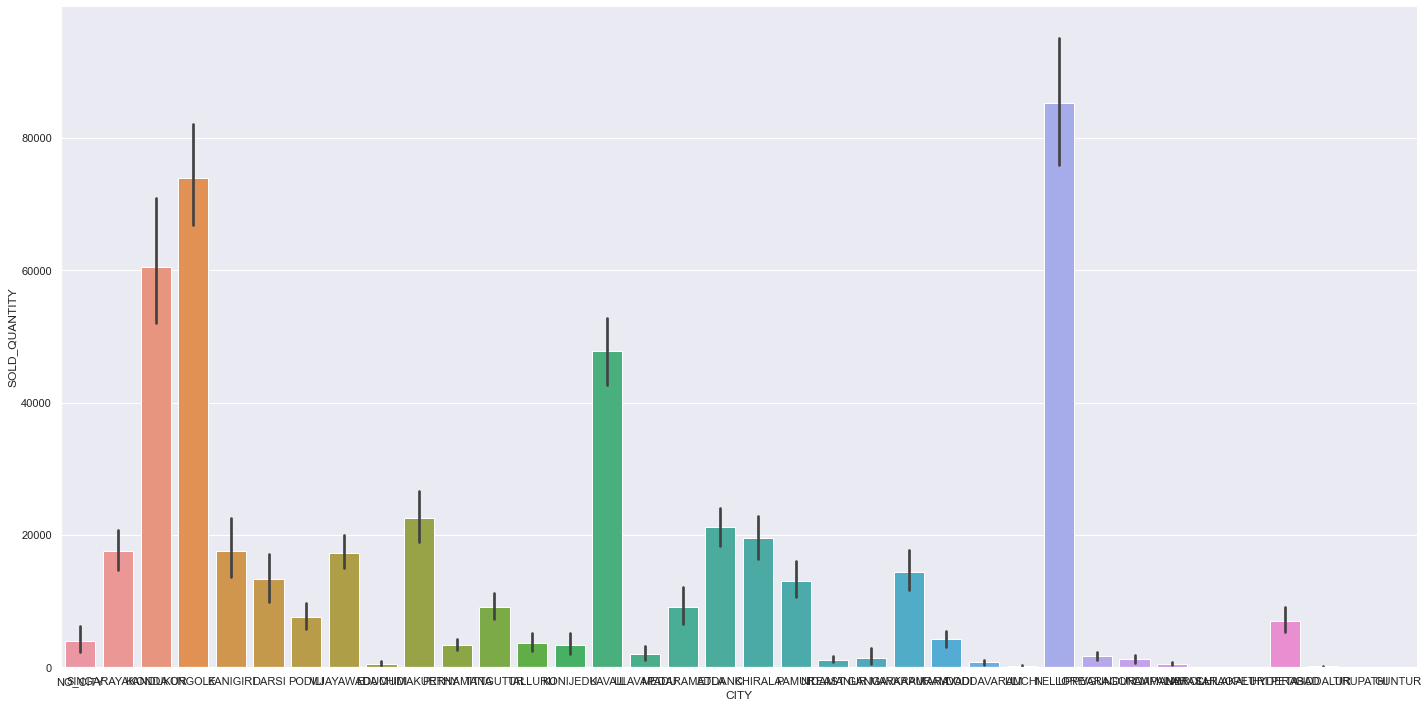

In [240]:
# plot the SOLD_QUANTYTY in CITY
# observation, no ovbious bigger winners, four cities have significant smaller sold quantities, but the rest are similar.
sns.catplot(x='CITY', y='SOLD_QUANTITY', data=df, kind='bar', height=10, aspect=2, estimator = np.sum)

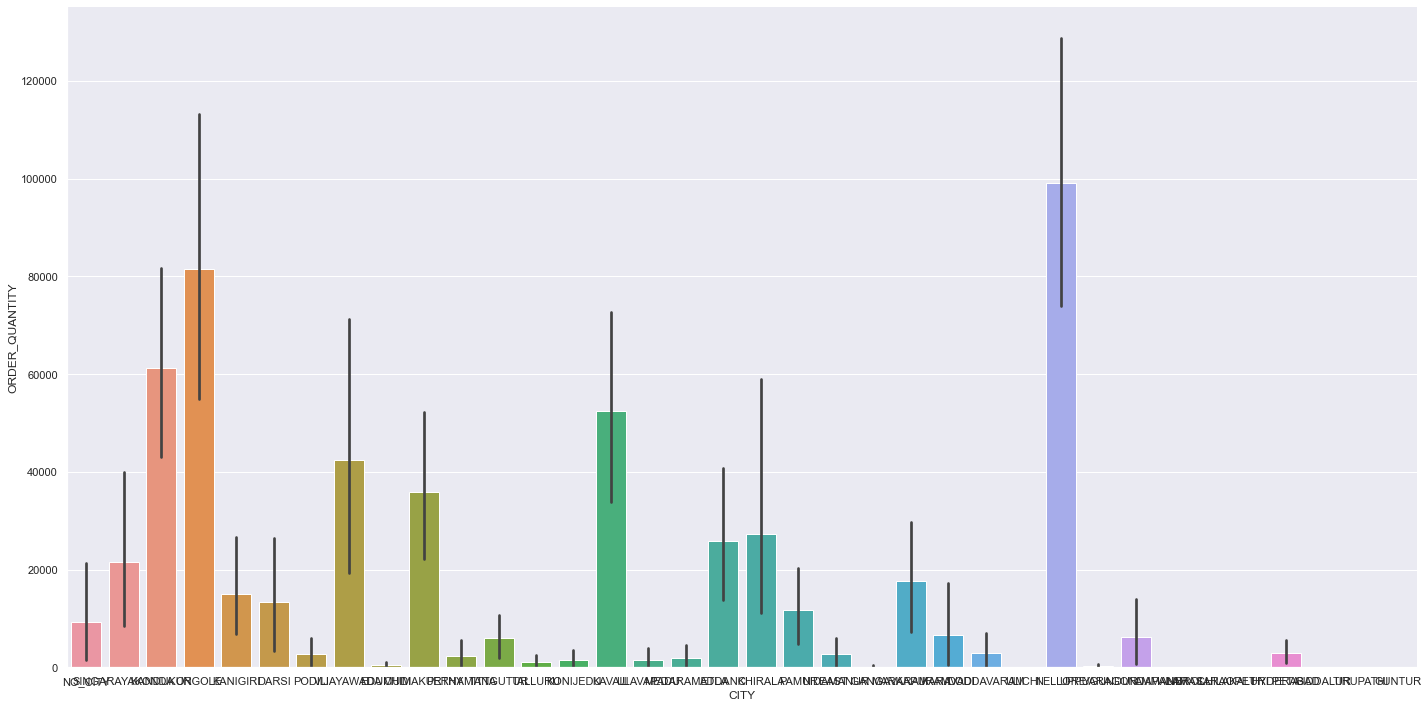

In [241]:
# plot the ORDER_QUANTYTY in CITY
# observation, some variation. Question, how come some cities didn't have any order quantity but has sold quantity
sns.catplot(x='CITY', y='ORDER_QUANTITY', data=df, kind='bar', height=10, aspect=2, estimator = np.sum)

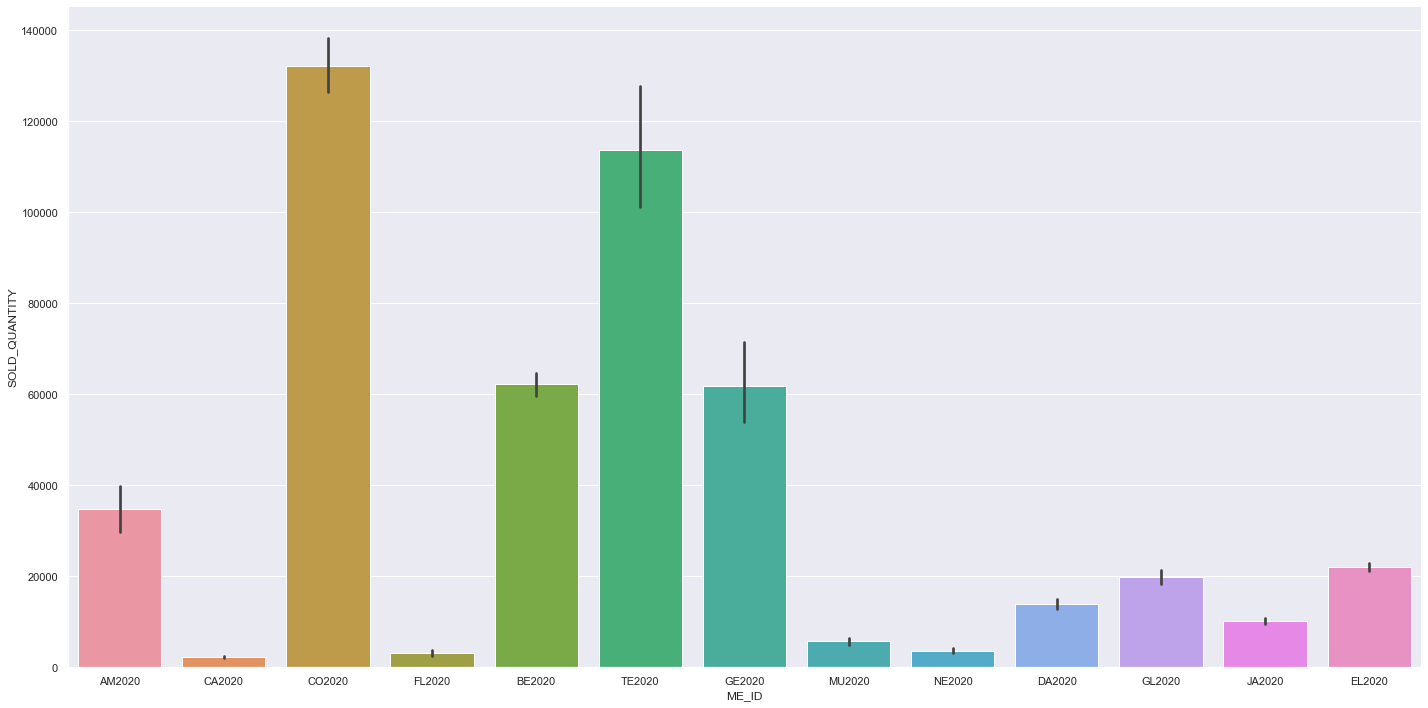

In [242]:
# plot the SOLD_QUANTYTY in ME_ID
# observation, TE2020 > GE2020, AM2020 > CO2020 > the rest
sns.catplot(x='ME_ID', y='SOLD_QUANTITY', data=df, kind='bar', height=10, aspect=2, estimator = np.sum)

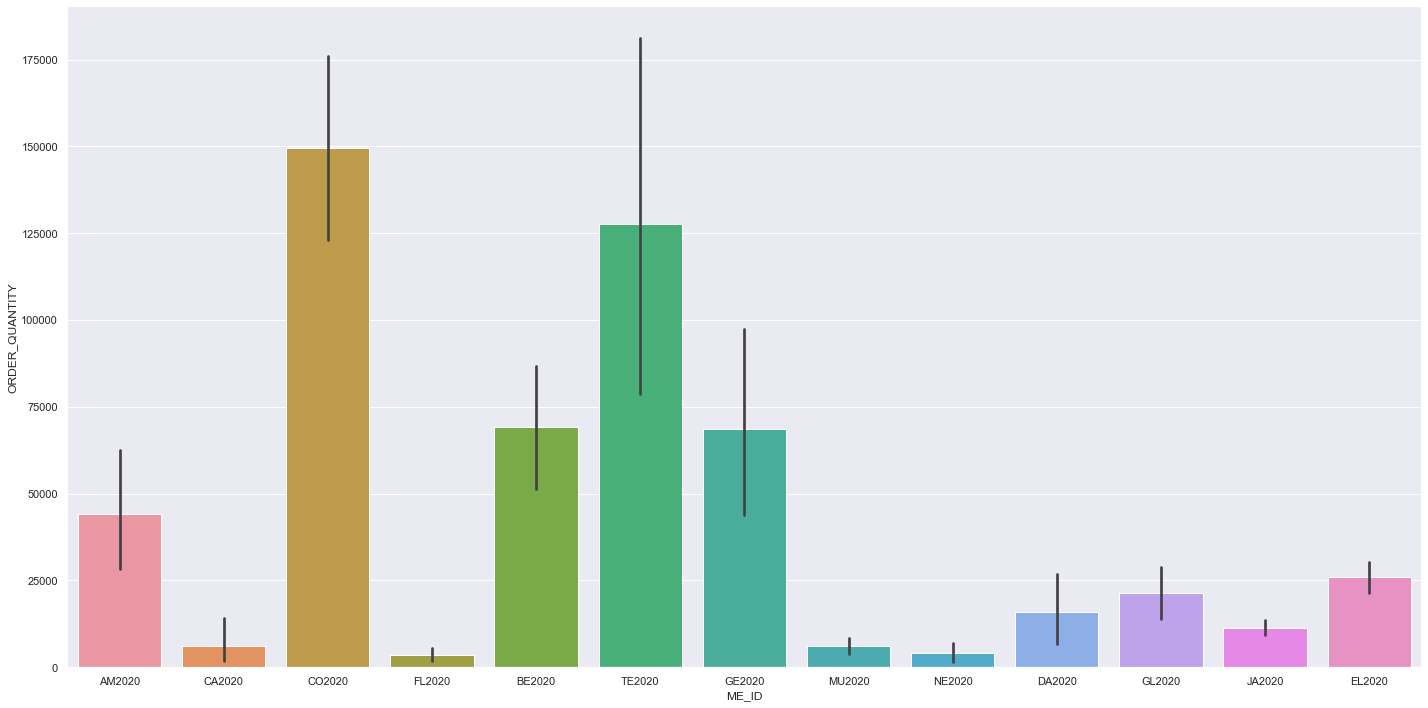

In [243]:
# plot the ORDER_QUANTYTY in ME_ID
# observation, exactly the same pattern with SOLD, TE2020 > GE2020, AM2020 > CO2020 > the rest
sns.catplot(x='ME_ID', y='ORDER_QUANTITY', data=df, kind='bar', height=10, aspect=2, estimator = np.sum)

In [23]:
# In order to plot sold and order side by side, create an aggregated df
# CITY and ME_ID interaction
df_by_city_med = df.groupby(['CITY','ME_ID']).agg(sold_sum = pd.NamedAgg(column = "SOLD_QUANTITY", aggfunc = np.sum),
                                    order_sum = pd.NamedAgg(column = "ORDER_QUANTITY", aggfunc = np.sum),
                                    sold_mean = pd.NamedAgg(column = 'SOLD_QUANTITY', aggfunc = np.mean),
                                    order_mean = pd.NamedAgg(column = 'ORDER_QUANTITY', aggfunc = np.mean))
df_by_city_med.reset_index(level=['CITY','ME_ID'], inplace=True)
df_by_city_med

CITY   ME_ID  sold_sum  order_sum   sold_mean  order_mean
0           ADDANKI  AM2020    1310.5     4400.0   48.537037  162.962963
1           ADDANKI  BE2020    4039.0     2260.0   28.645390   16.028369
2           ADDANKI  CA2020      90.0       72.0    6.428571    5.142857
3           ADDANKI  CO2020    5150.5     3892.0   54.792553   41.404255
4           ADDANKI  DA2020     736.0        0.0   29.440000    0.000000
..              ...     ...       ...        ...         ...         ...
355  YARAGONDAPALAM  GE2020     125.0        0.0  125.000000    0.000000
356  YARAGONDAPALAM  JA2020      22.0        0.0   11.000000    0.000000
357  YARAGONDAPALAM  MU2020      16.0        0.0    8.000000    0.000000
358  YARAGONDAPALAM  NE2020       6.5        0.0    6.500000    0.000000
359  YARAGONDAPALAM  TE2020       0.0       15.0    0.000000   15.000000

[360 rows x 6 columns]

In [24]:
df_by_city_med_sum = pd.melt(df_by_city_med,id_vars=['CITY','ME_ID'], value_vars=['sold_sum','order_sum'])
df_by_city_med_sum.rename(columns={'variable': 'sum_type', 'value': 'sum'}, inplace=True)
df_by_city_med_mean = pd.melt(df_by_city_med,id_vars=['CITY','ME_ID'], value_vars=['sold_mean','order_mean'])
df_by_city_med_mean.rename(columns={'variable': 'mean_type', 'value': 'mean'}, inplace=True)
df_by_city_med = pd.merge(df_by_city_med_sum,df_by_city_med_mean)

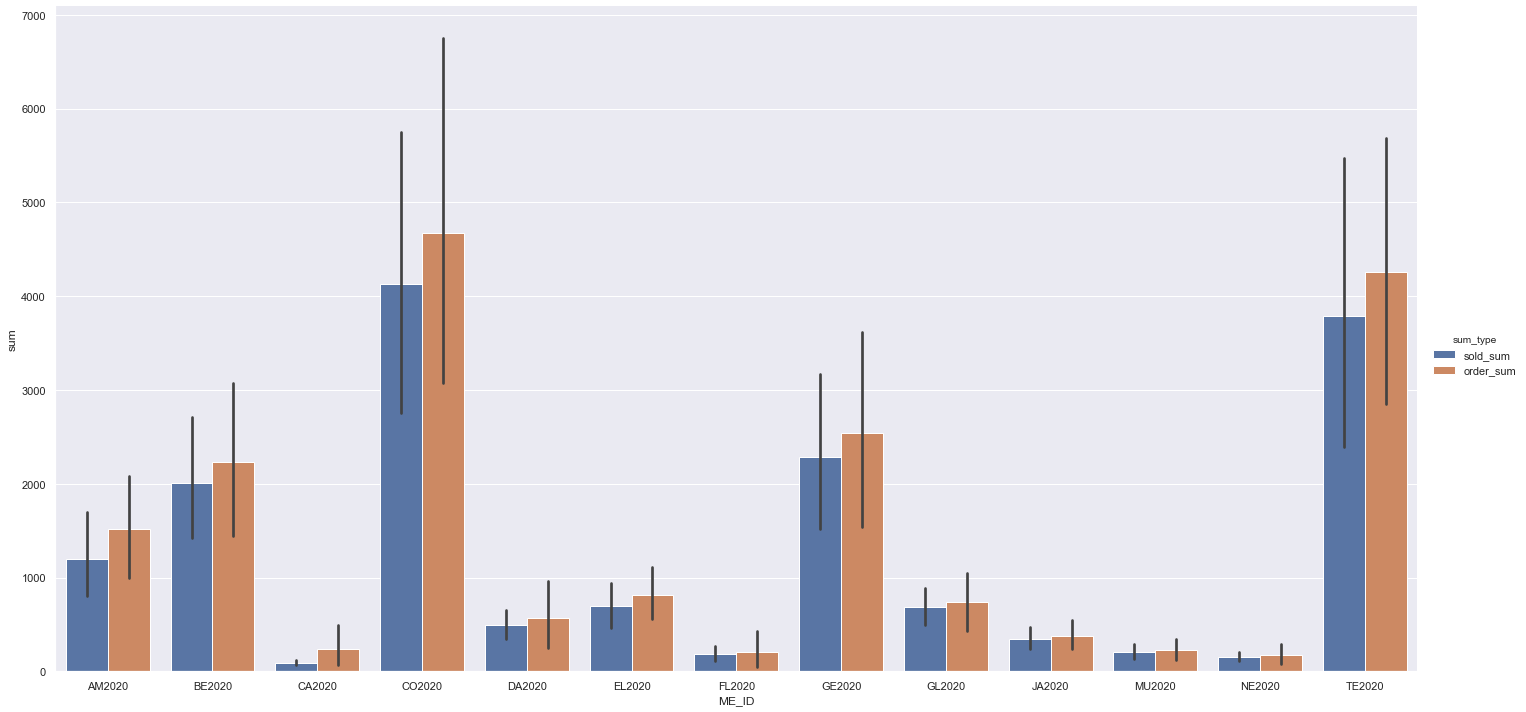

In [25]:
sns.catplot(x='ME_ID', y='sum', hue='sum_type', data=df_by_city_med, kind='bar', height=10, aspect=2)

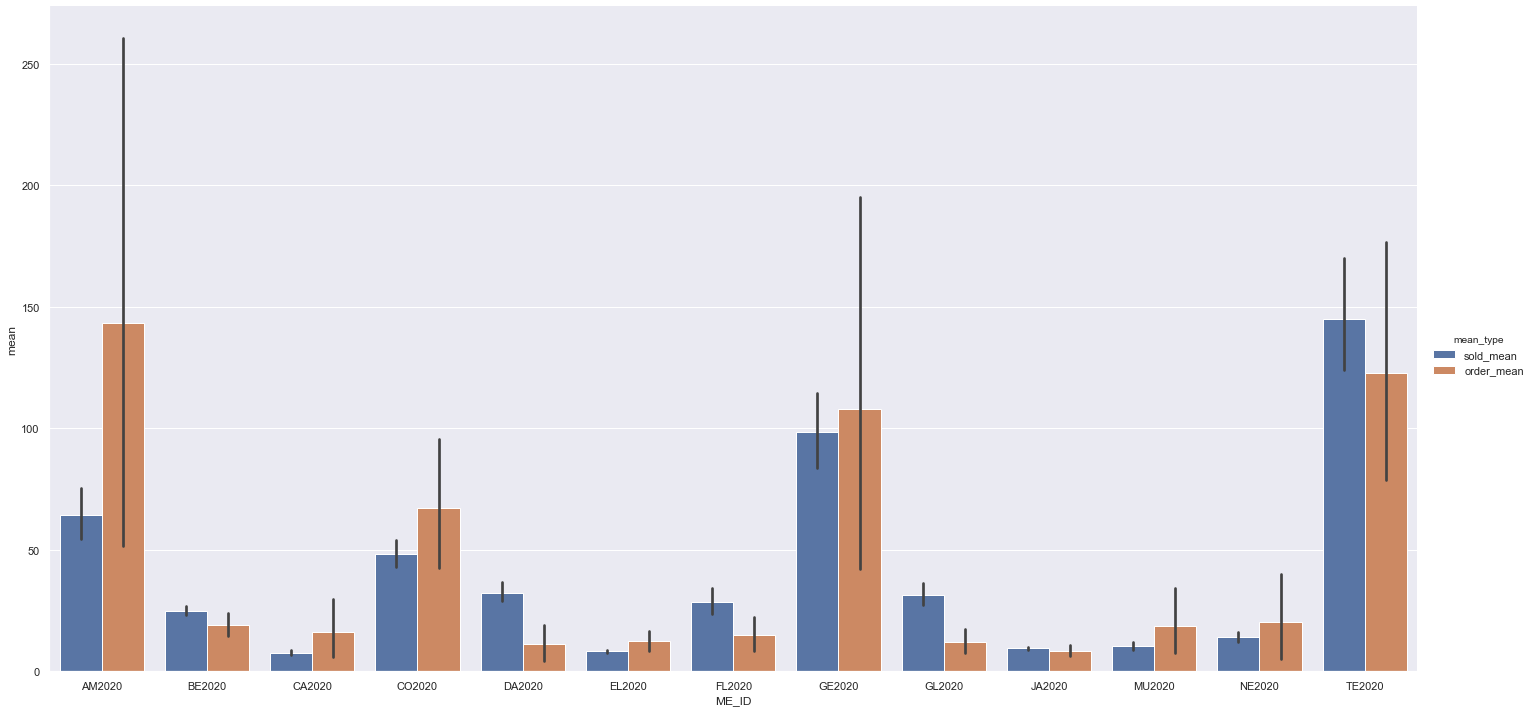

In [26]:
sns.catplot(x='ME_ID', y='mean', hue='mean_type', data=df_by_city_med, kind='bar', height=10, aspect=2)

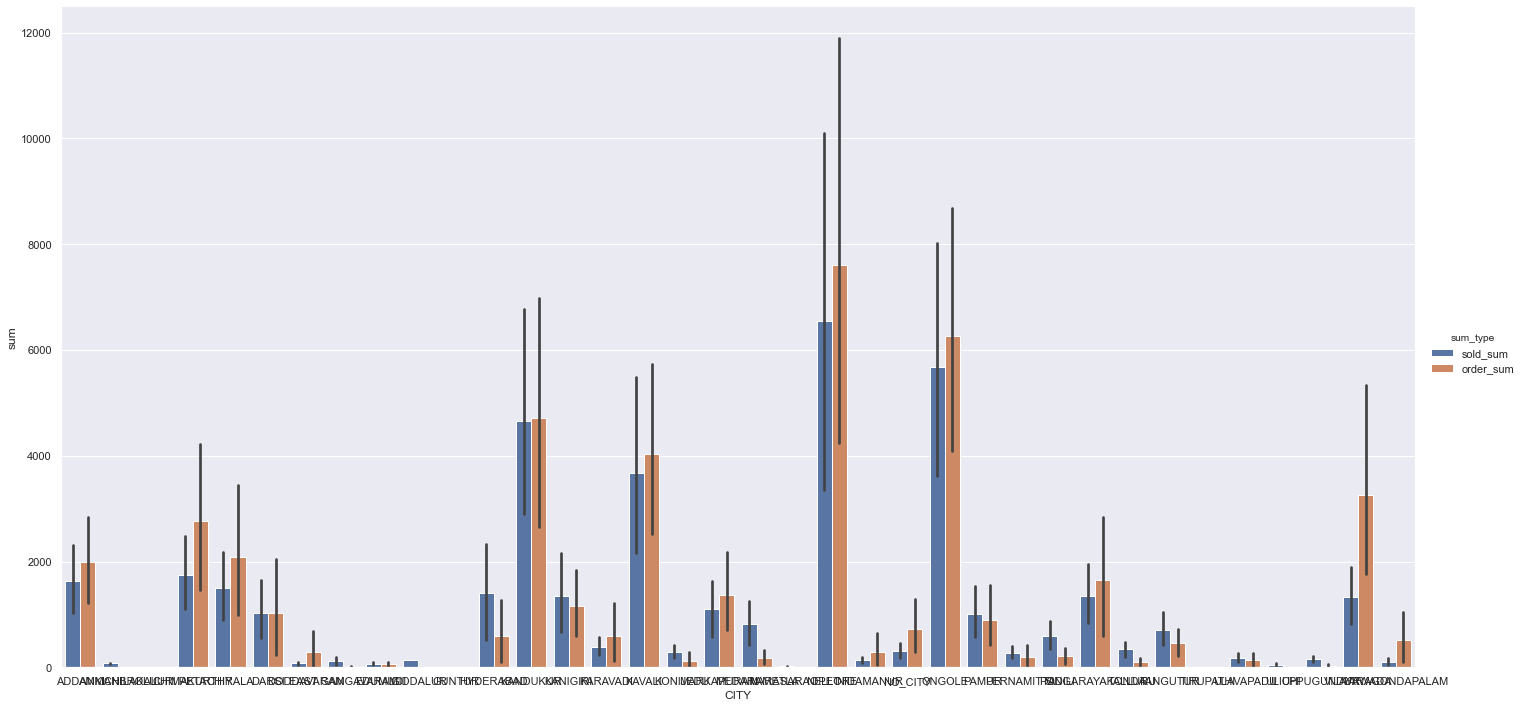

In [237]:
sns.catplot(x='CITY', y='sum', hue='sum_type', data=df_by_city_med, kind='bar', height=10, aspect=2)

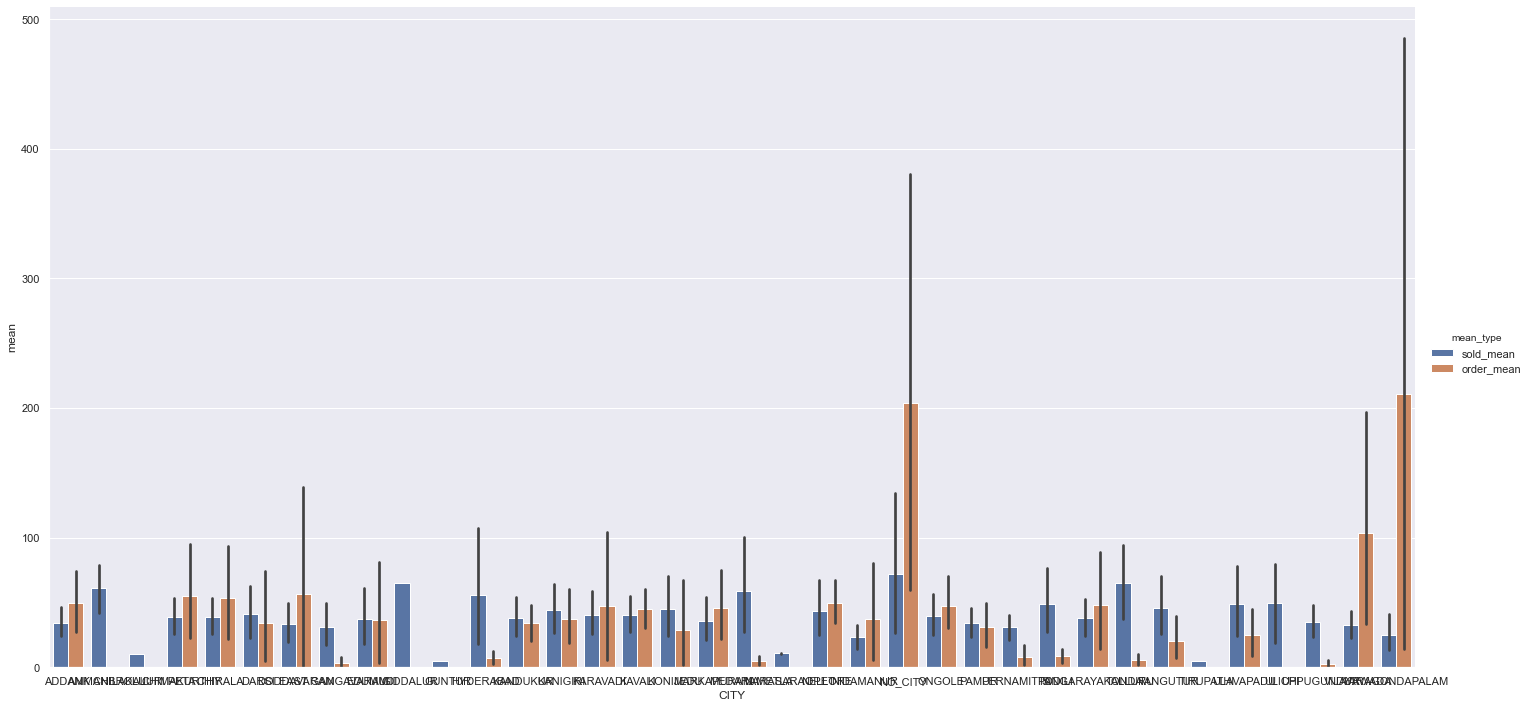

In [239]:
sns.catplot(x='CITY', y='mean', hue='mean_type', data=df_by_city_med, kind='bar', height=10, aspect=2)

## 3.2 aggregate by date, fill in the dates, plot by dates
## end product df_agg

In [41]:
df_agg = aggregate_by_date(df)
df_agg.head()

DATE  SOLD_QUANTITY  ORDER_QUANTITY
0 2018-04-01            0.0         39177.0
1 2018-04-02        10098.5             0.0
2 2018-04-03         2993.5             0.0
3 2018-04-04         4020.0             0.0
4 2018-04-05         2467.0           260.0

In [42]:
# need to fill in the missing dates
df_agg = fill_in_missing_dates(df_agg)

In [43]:
df_agg.head()

DATE  SOLD_QUANTITY  ORDER_QUANTITY
0 2018-04-01            0.0         39177.0
1 2018-04-02        10098.5             0.0
2 2018-04-03         2993.5             0.0
3 2018-04-04         4020.0             0.0
4 2018-04-05         2467.0           260.0

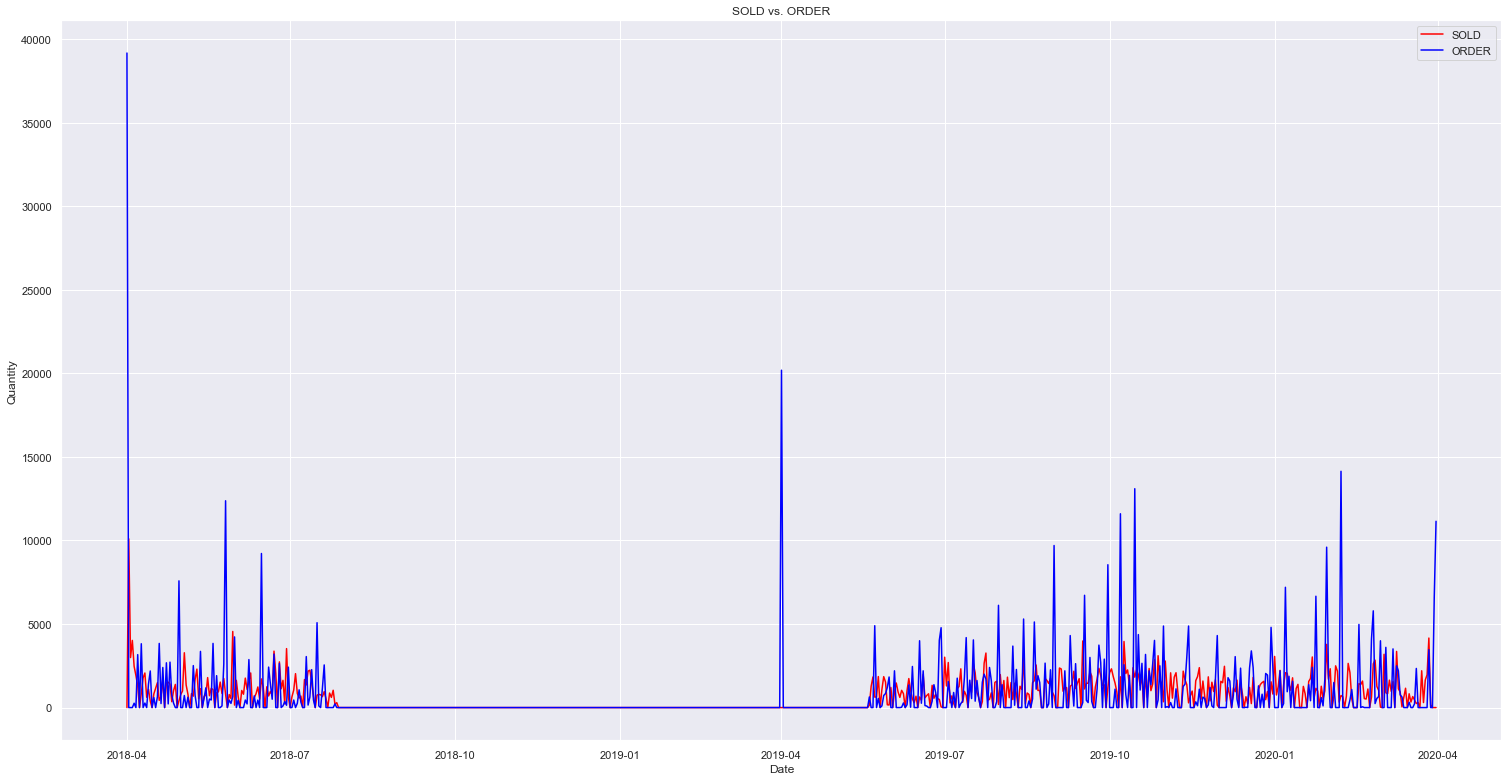

In [44]:
plot_sold_order_by_date(df_agg)

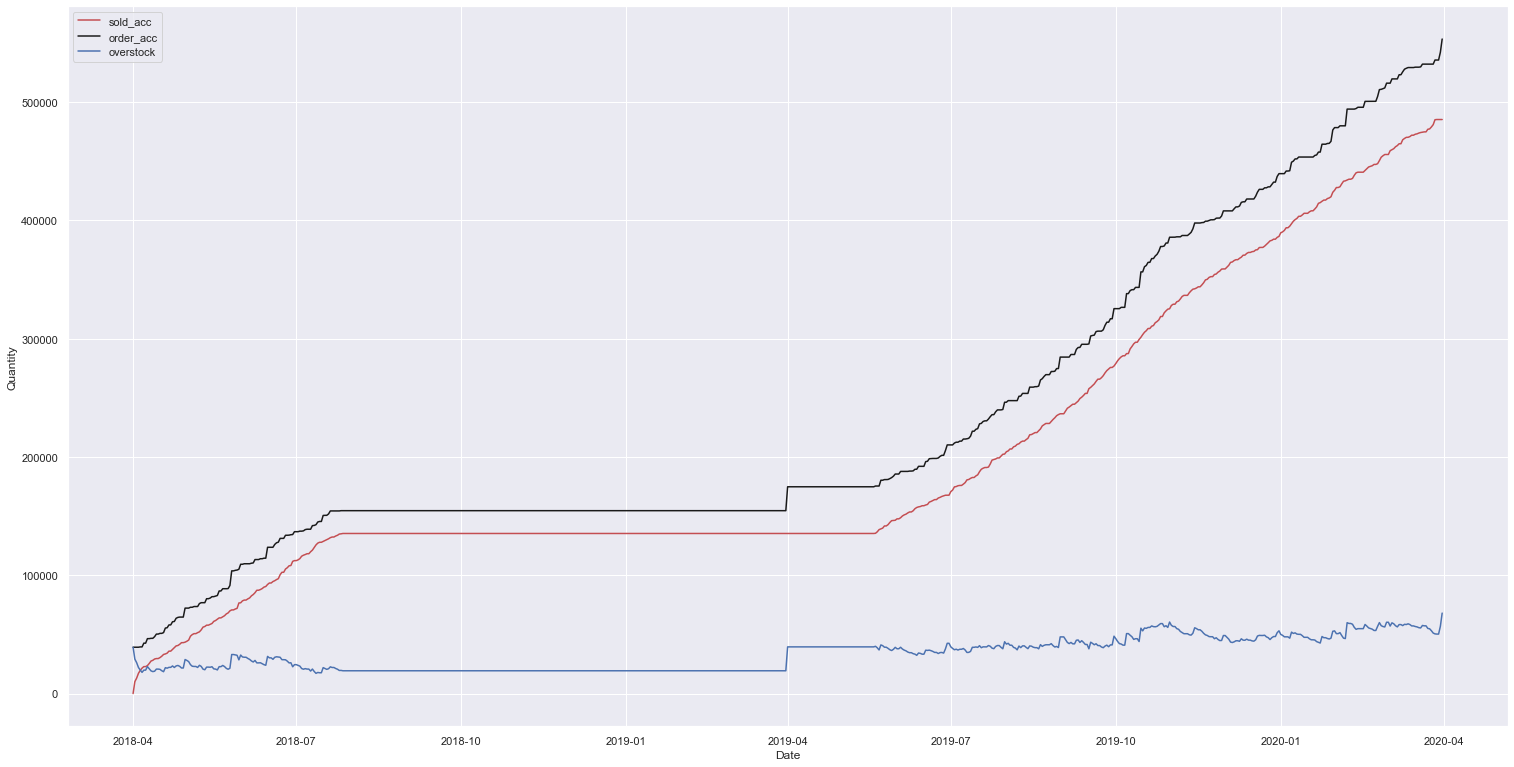

In [45]:
plot_sold_order_acc_by_date(df_agg)

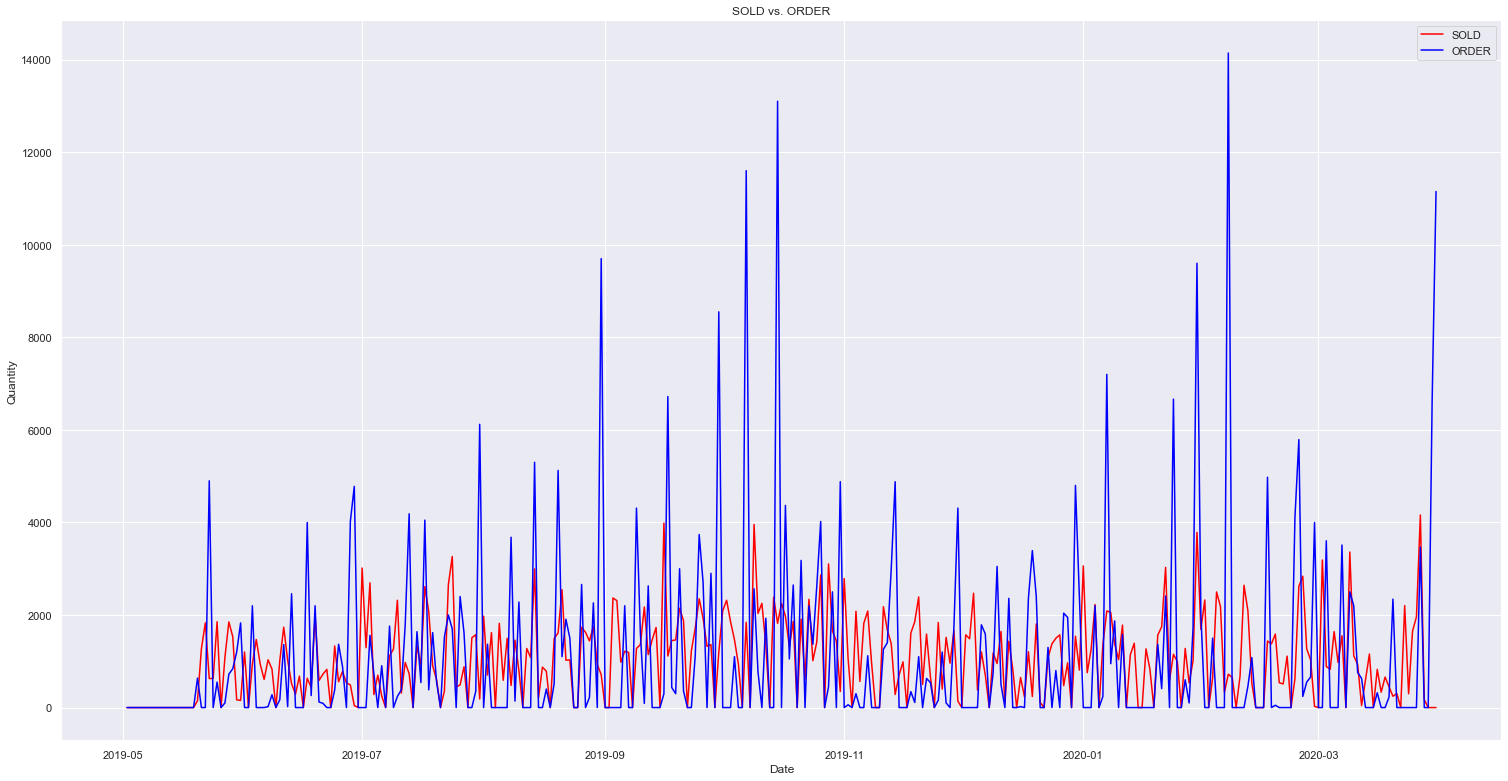

In [40]:
#limit the dates to be later than 2019-05-01
df_agg = remove_dates_priorto_cutoff(df_agg, '2019-05-01')
plot_sold_order_by_date(df_agg)

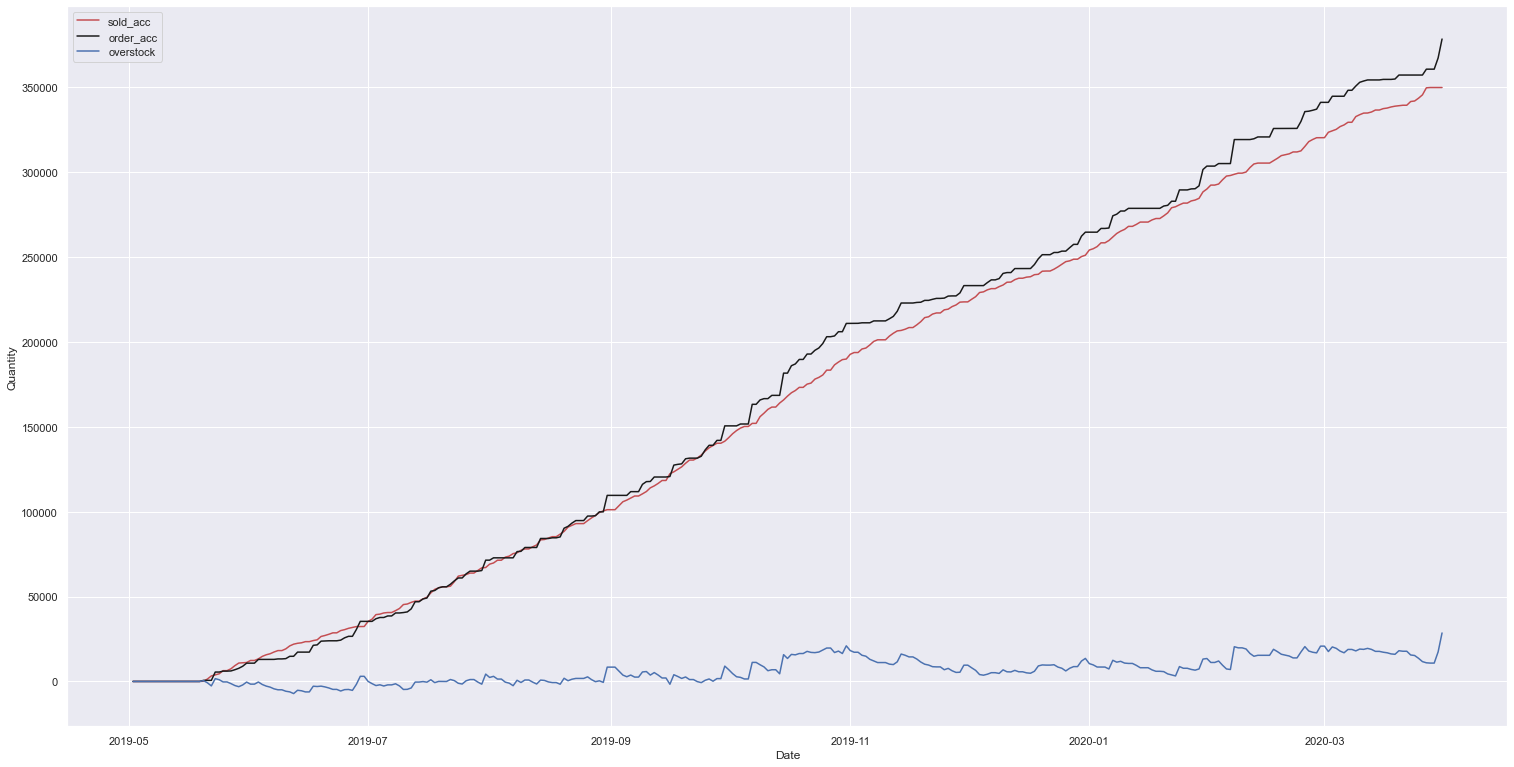

In [134]:
plot_sold_order_acc_by_date(df_agg)
# Observation: depending on when the accumulation started being calculated, the distance between the black and red curves are different
# in other sense, we don't know the baseline amount of the stock
# we always assumes the first date of data we use was 0 for accumulative order and accumulative sold.
# So accumulation can be used to study the trend change, but not the absoluate difference between sold and order.

## 3.3 Check the linear relationships between some variables
## df was not modified, only for fun

In [135]:
# check the relationship between SOLD_QUANLITY and SOLD_FREE
# Observation, when SOLD_QUANTITY is small, the ratio looks like 10:1, 
# but when SOLD_QUANTITY is large, the ratio looks like 4:1

# fit n-level polymonial for two variables
# doesn't have much to do with the final model, just for fun
def fit_polynomial(x, y, nlevel):
    m = np.polyfit(x, y, nlevel)
    x_new = x**nlevel
    for n in range(nlevel-1, -1, -1):
        x_new = np.vstack((x_new, x**n))
    y_predicted = np.dot(m.transpose(), x_new)
    prediction = pd.DataFrame(x)
    prediction.columns = ['x']
    prediction['prediction'] = y_predicted
    #had to sort by x so that the plot isn't crazy
    prediction = prediction.sort_values(['x'])
    return prediction

In [136]:
def fit_polynomial_and_plot(df, col1, col2, nlevel):
    prediction = fit_polynomial(df[col1], df[col2], nlevel)
    fig = plt.figure()
    ax = fig.add_axes([.1,.1,1,1])
    ax.scatter(df[col1], df[col2])
    ax.plot(prediction.x, prediction.prediction)
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)


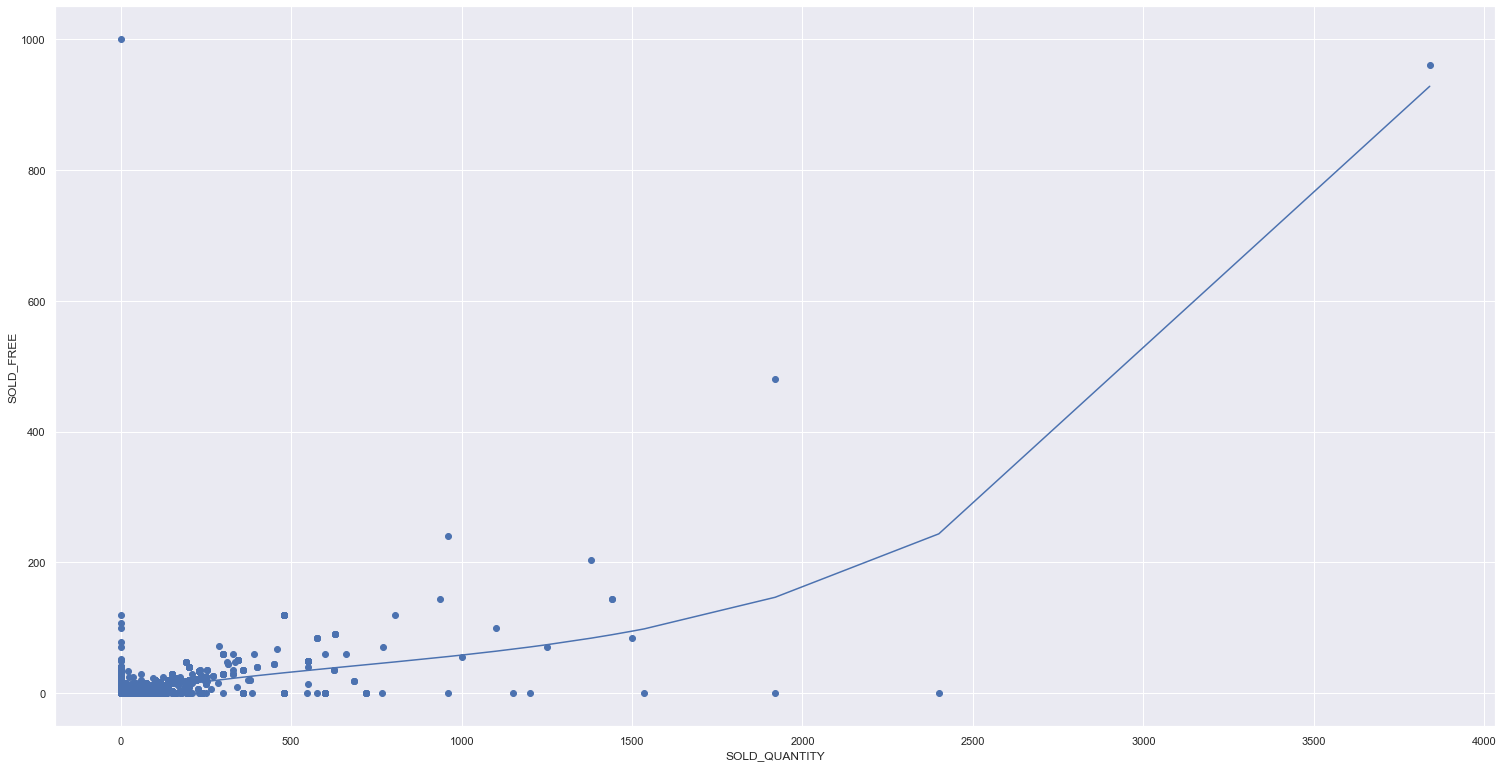

In [137]:
# plot SOLD_QUANTITY and SOLD_FREE and the polynomia fit
fit_polynomial_and_plot(df, 'SOLD_QUANTITY', 'SOLD_FREE', 3)

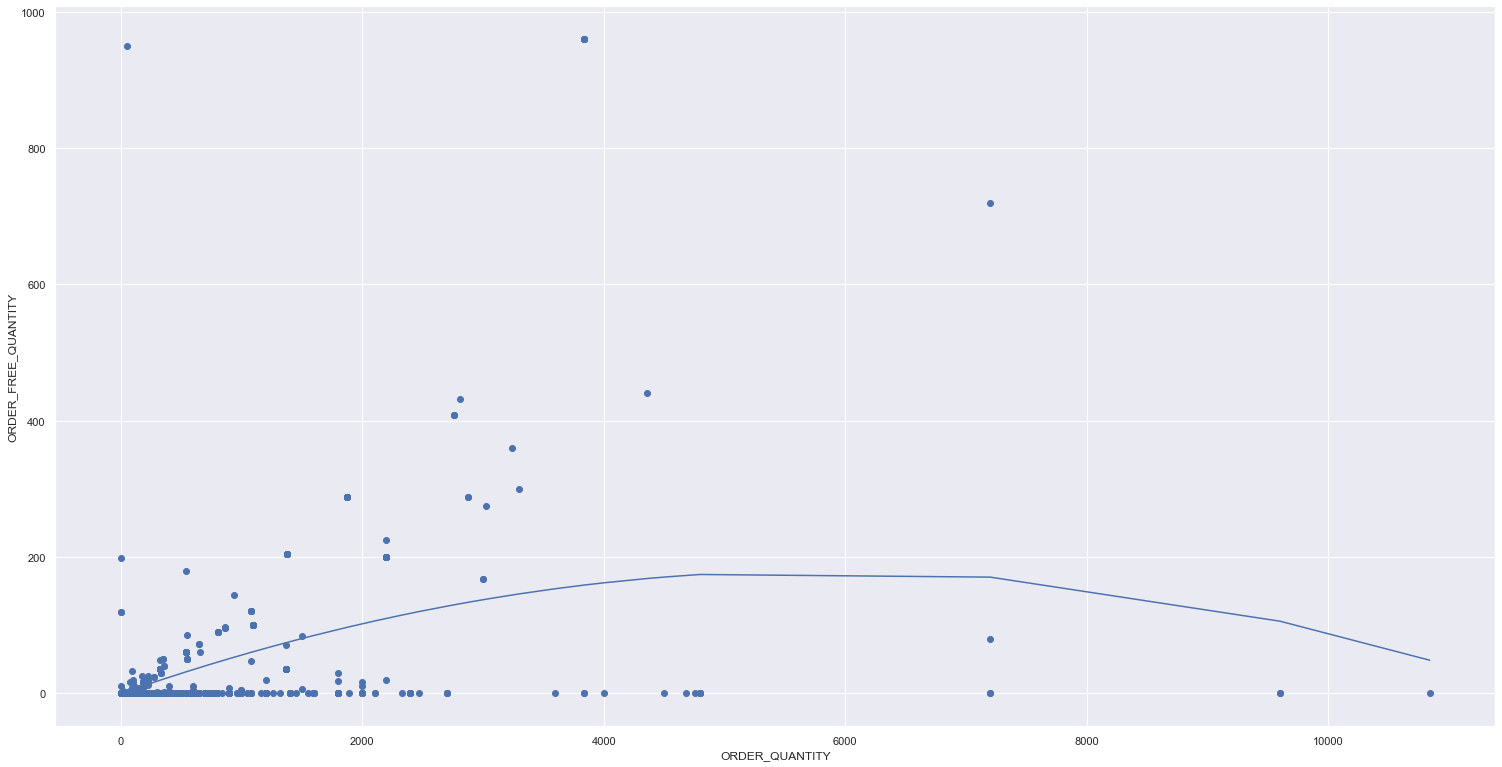

In [138]:
# plot SOLD_QUANTITY and SOLD_FREE and the polynomia fit
fit_polynomial_and_plot(df, 'ORDER_QUANTITY', 'ORDER_FREE_QUANTITY', 2)

## 3.4 test the frequency of ORDER_QUANTITY and SOLD_QUANTITY
## df_agg was not modified

In [139]:
#use the date aggregated by date
df_agg.head()

DATE  SOLD_QUANTITY  ORDER_QUANTITY
396 2019-05-02            0.0             0.0
397 2019-05-03            0.0             0.0
398 2019-05-04            0.0             0.0
399 2019-05-05            0.0             0.0
400 2019-05-06            0.0             0.0

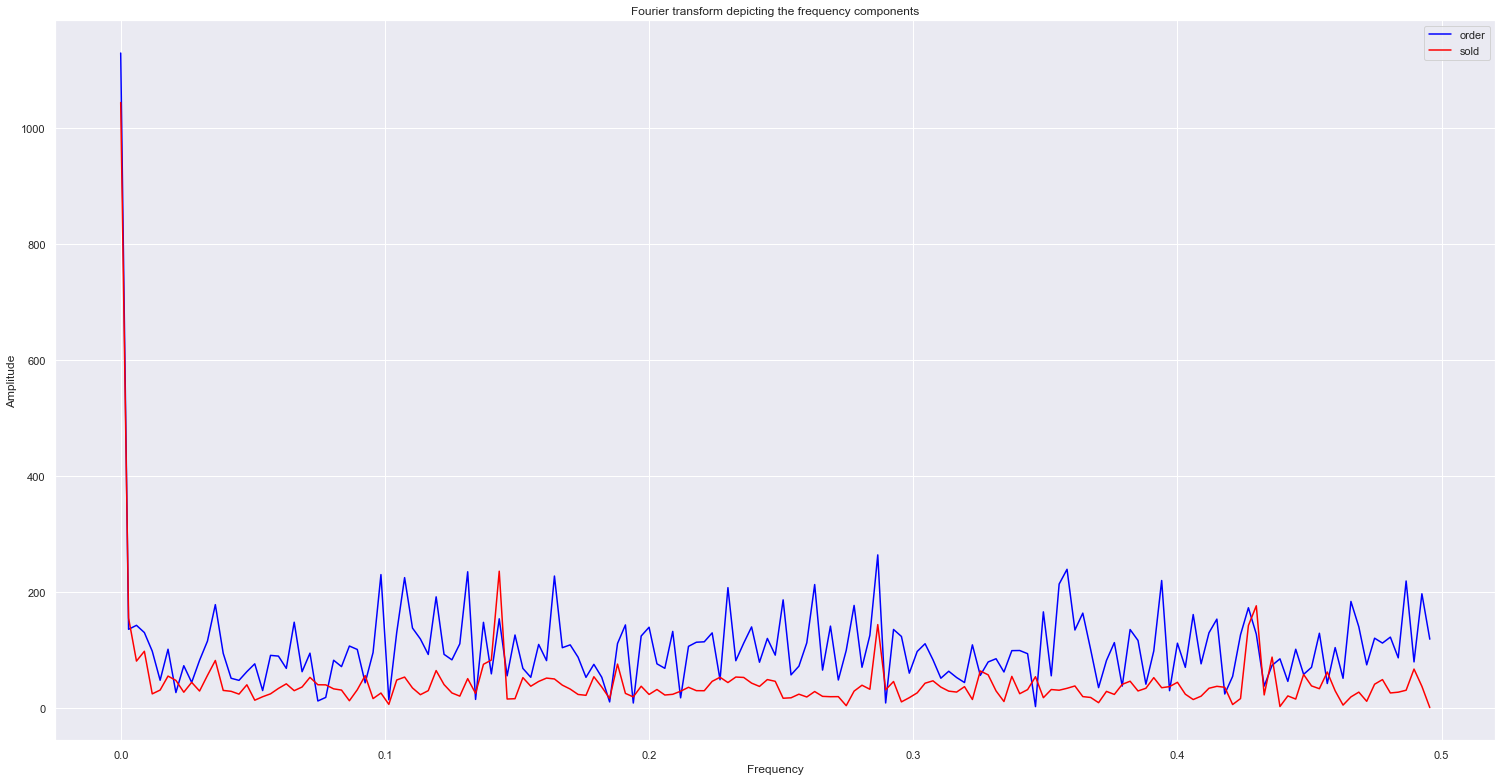

In [140]:
fft_order = plot_frequency(df_agg)
# observation: order: not a very obvious pattern. Maybe separate by disease type and check again
# observation: sold: highest power around 0.15 (times a day), which transition to once every 7 days. 
# it also has relatively high power around 0.28 and 0.43, which transition to once every 3.5 days (or twice a week)
# and once every 2.3 days (2.3 days is hard to conceptulize)

## 3.5 plot order and sold quantity by disease_name
## observation: the 2018 period has a pretty different pattern than the 2019/05 and later period, so it would be a better idea to use the more recent data than aggregating the two period of data together

In [141]:
df.head()

DATE   ME_ID DISEASE_ID  ORDER_QUANTITY  ORDER_FREE_QUANTITY  \
0 2018-04-01  AM2020     BL2020            42.0                  0.0   
1 2018-04-01  AM2020     BL2020           480.0                  0.0   
2 2018-04-02  AM2020     BL2020             0.0                  0.0   
4 2018-04-02  AM2020     BL2020             0.0                  0.0   
5 2018-04-02  AM2020     BL2020             0.0                  0.0   

   SOLD_QUANTITY  SOLD_FREE     MEDICINE_NAME    DISEASE_NAME            CITY  \
0            0.0        0.0  AMLOKIND AT -TAB  BLOOD PRESSURE         NO_CITY   
1            0.0        0.0  AMLOKIND AT -TAB  BLOOD PRESSURE         NO_CITY   
2           25.0        5.0  AMLOKIND AT -TAB  BLOOD PRESSURE  SINGARAYAKONDA   
4           10.0        2.0  AMLOKIND AT -TAB  BLOOD PRESSURE        KANDUKUR   
5           25.0        5.0  AMLOKIND AT -TAB  BLOOD PRESSURE        KANDUKUR   

   year month day weekday  
0  2018     4   1       6  
1  2018     4   1       6  
2  2018     4   2       0  
4  2018     4   2       0  
5  2018     4   2       0

<AxesSubplot:xlabel='DATE', ylabel='ORDER_QUANTITY'>

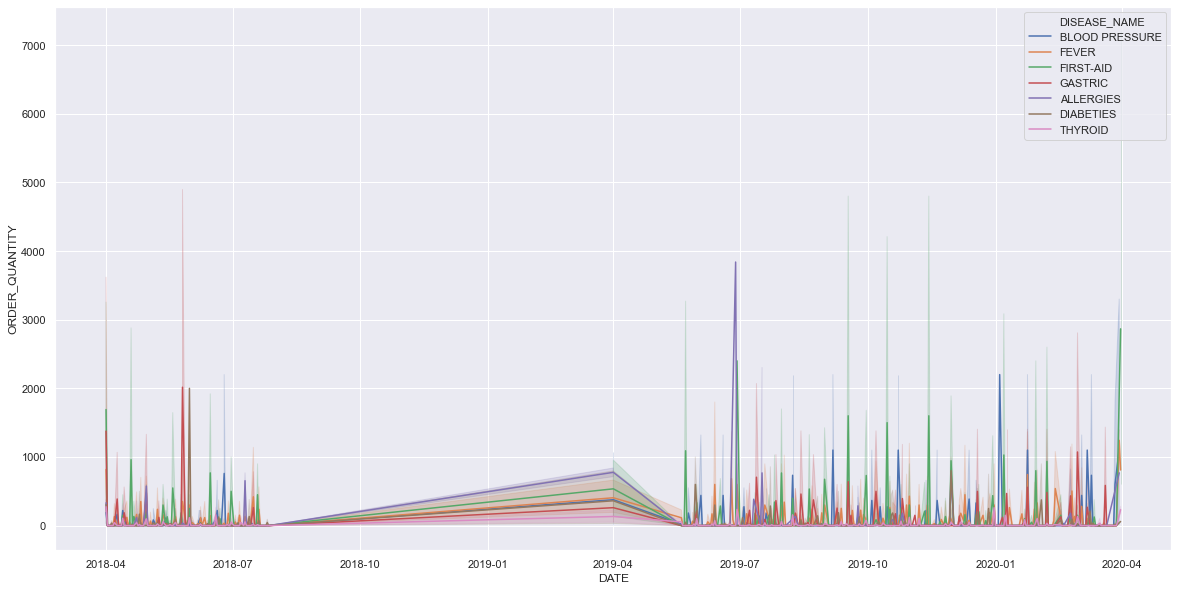

In [142]:
sns.lineplot(x="DATE", y="ORDER_QUANTITY", hue="DISEASE_NAME", data=df)

<AxesSubplot:xlabel='DATE', ylabel='SOLD_QUANTITY'>

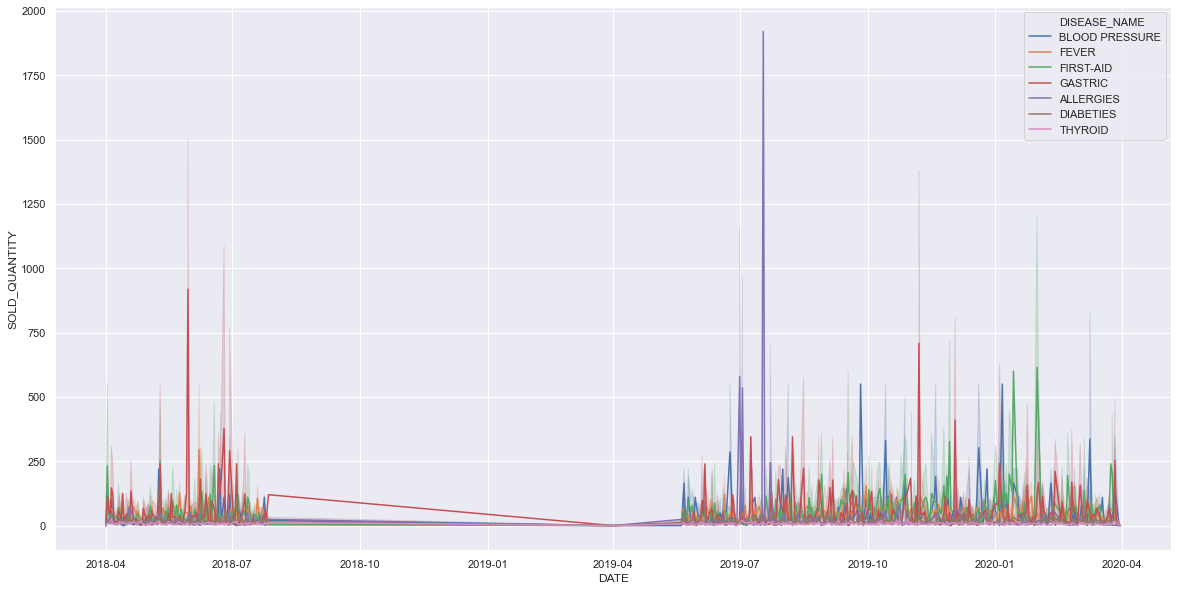

In [143]:
sns.lineplot(x="DATE", y="SOLD_QUANTITY", hue="DISEASE_NAME", data=df)

## 3.6 process the data by each disease_name

In [100]:
df[df['DISEASE_NAME']=='BLOOD PRESSURE']

DATE   ME_ID DISEASE_ID  ORDER_QUANTITY  ORDER_FREE_QUANTITY  \
0   2018-04-01  AM2020     BL2020            42.0                  0.0   
1   2018-04-01  AM2020     BL2020           480.0                  0.0   
2   2018-04-02  AM2020     BL2020             0.0                  0.0   
4   2018-04-02  AM2020     BL2020             0.0                  0.0   
5   2018-04-02  AM2020     BL2020             0.0                  0.0   
..         ...     ...        ...             ...                  ...   
863 2020-03-25  CA2020     BL2020             0.0                  0.0   
864 2020-03-26  CA2020     BL2020             0.0                  0.0   
865 2020-03-27  CA2020     BL2020             0.0                  0.0   
866 2020-03-30  CA2020     BL2020            20.0                  0.0   
867 2020-03-30  CA2020     BL2020            30.0                  0.0   

     SOLD_QUANTITY  SOLD_FREE     MEDICINE_NAME    DISEASE_NAME  \
0              0.0        0.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
1              0.0        0.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
2             25.0        5.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
4             10.0        2.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
5             25.0        5.0  AMLOKIND AT -TAB  BLOOD PRESSURE   
..             ...        ...               ...             ...   
863            2.0        0.0           CARDACE  BLOOD PRESSURE   
864           10.0        0.0           CARDACE  BLOOD PRESSURE   
865           10.0        0.0           CARDACE  BLOOD PRESSURE   
866            0.0        0.0           CARDACE  BLOOD PRESSURE   
867            0.0        0.0           CARDACE  BLOOD PRESSURE   

               CITY  year month day weekday  
0           NO_CITY  2018     4   1       6  
1           NO_CITY  2018     4   1       6  
2    SINGARAYAKONDA  2018     4   2       0  
4          KANDUKUR  2018     4   2       0  
5          KANDUKUR  2018     4   2       0  
..              ...   ...   ...  ..     ...  
863         ADDANKI  2020     3  25       2  
864          ONGOLE  2020     3  26       3  
865          KAVALI  2020     3  27       4  
866          KAVALI  2020     3  30       0  
867         ADDANKI  2020     3  30       0  

[835 rows x 14 columns]

<table>
  <tr>
    <th>Disease_name</th>
    <th>Order/Sold Quantity pattern (seasonal?)</th>
    <th>Overstock pattern</th>
    <th>Order/Sold frequency pattern (weekly?)</th>
  </tr>
  <tr>
    <td>Blood Pressure</td>
    <td>No seasonal pattern</td>
    <td>Slightly overstock, quick replenish</td>
    <td>Sold once or twice a week</td>
  </tr>
  <tr>
    <td>Fever</td>
    <td>Large order in October, large sold quantities in the fall and March</td>
    <td>Since October 2019 there was an increased overstock and it continued throughout the rest of the data period</td>
    <td>Sold once a week or every 2.5 days</td>
  </tr>
  <tr>
    <td>First aid</td>
    <td>A large order in october but less frequent after. The sold is low in May, June, July and December</td>
    <td>Frequenty replenishment with minimum overstock</td>
    <td>Weekely order and sold</td>
  </tr>
  <tr>
    <td>Gastric</td>
    <td>Sold high in March and April.</td>
    <td>A period of time of understock.</td>
    <td>No weekely sold pattern, but once every 3-4days</td>
  </tr>
  <tr>
    <td>Allergies</td>
    <td>Very infrequenty order</td>
    <td>Obtain a big stock and slowly consume it. Periods of understock</td>
    <td>No obvious pattern</td>
  </tr>
  <tr>
    <td>Diabetes</td>
    <td>No seasonal change</td>
    <td>Understock</td>
    <td>Strong weekely order pattern</td>
  </tr>
  <tr>
    <td>Thyroid</td>
    <td>Somewhat month to month variation in order, not much in sold</td>
    <td>Frequent replenishment</td>
    <td>Sold every 2-3 days</td>
  </tr>
</table>

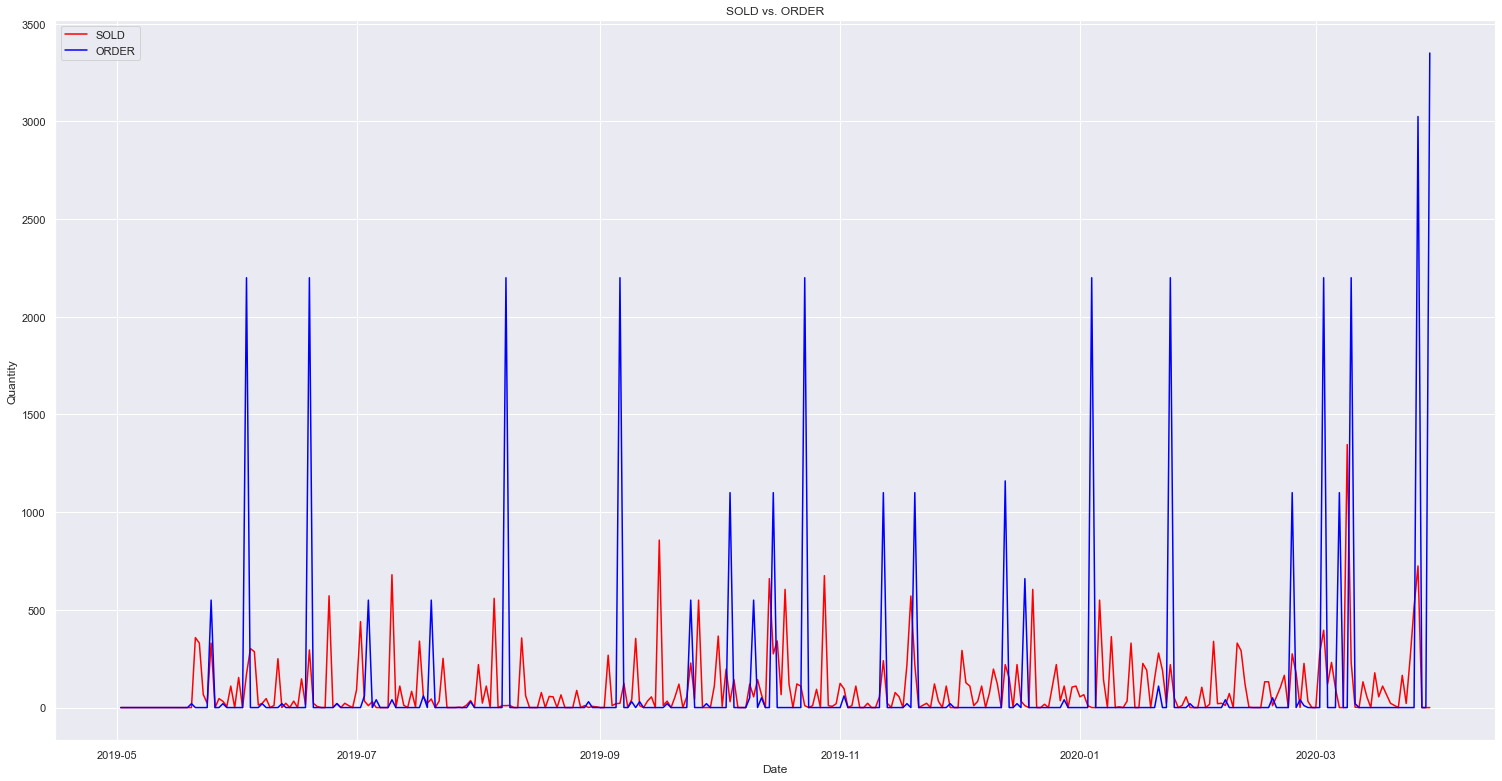

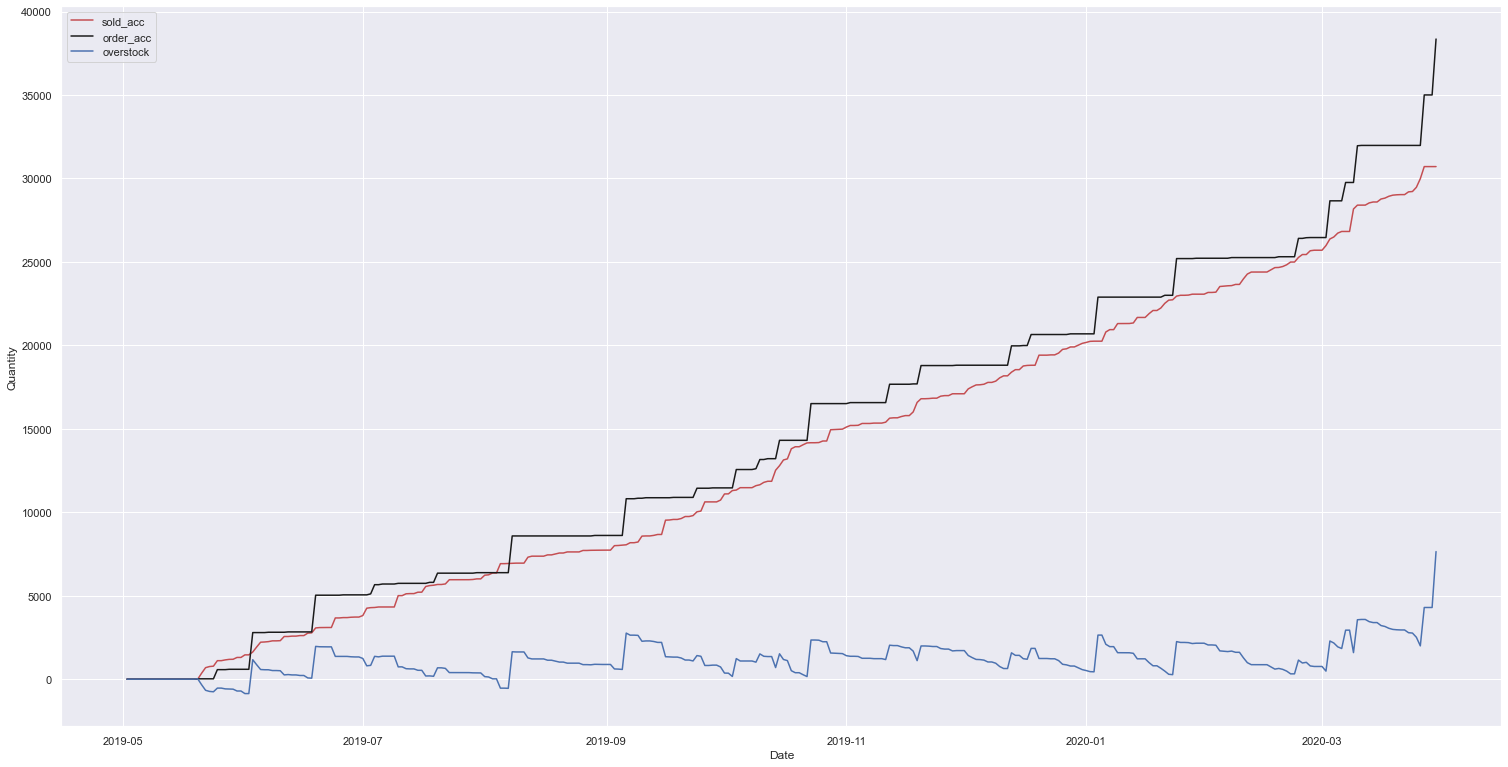

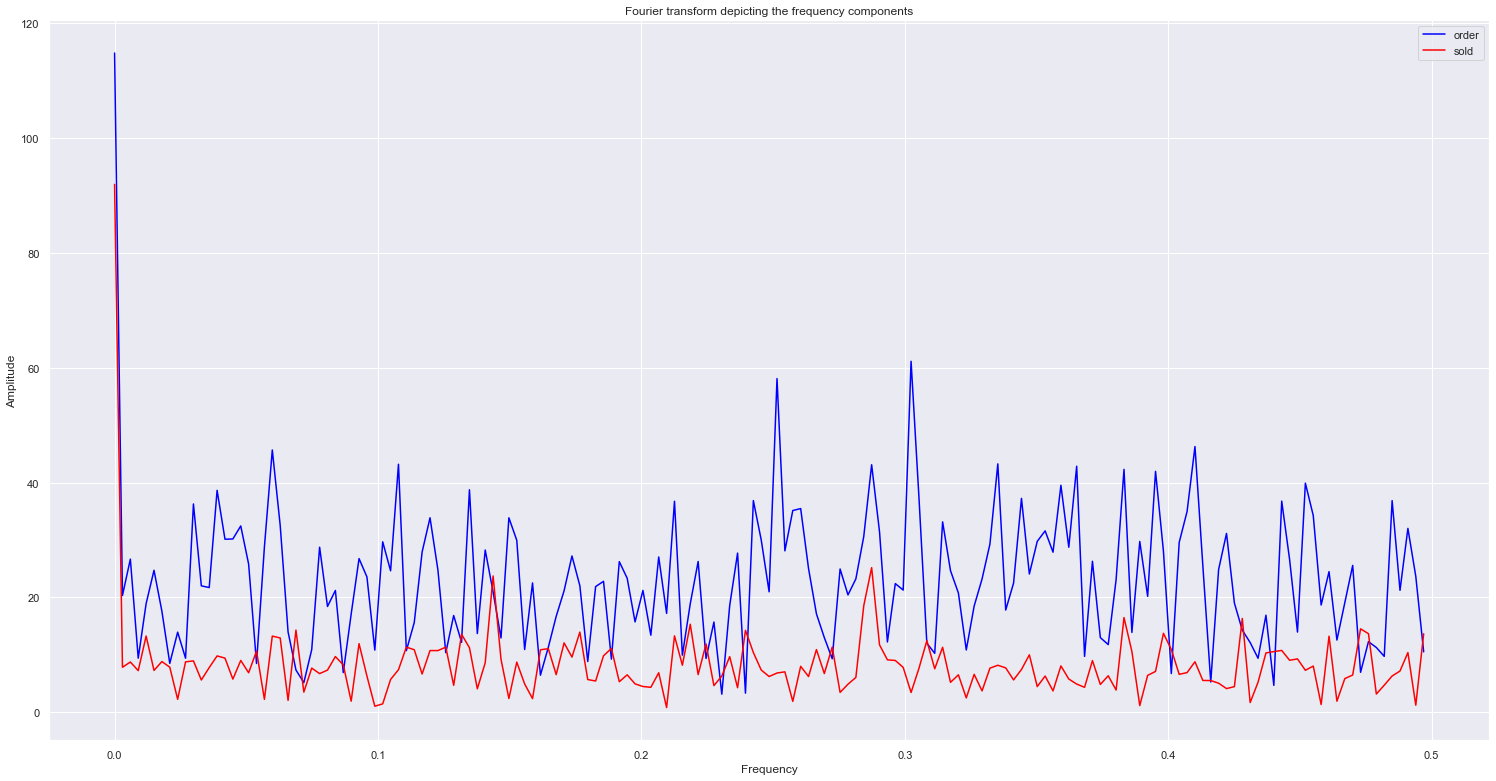

In [161]:
df_bloodpressure = plot_by_disease_name(df,'BLOOD PRESSURE')

#observation, blood pressure medicine does not seem to have any seasonal effect in terms or order or sold
# It seems like the current strategy for blood pressure is to get a good stock and consume it and repeat the cycle
#observation: for blood pressure medicine, order frequency is higest at 0.25 and 0.3, 
# translating to once every 3 to 4 days.
# sold frequency is similar to the overall pattern, highest frequency at 0.15, 0.28, 
# translating to once a week, and twice a week

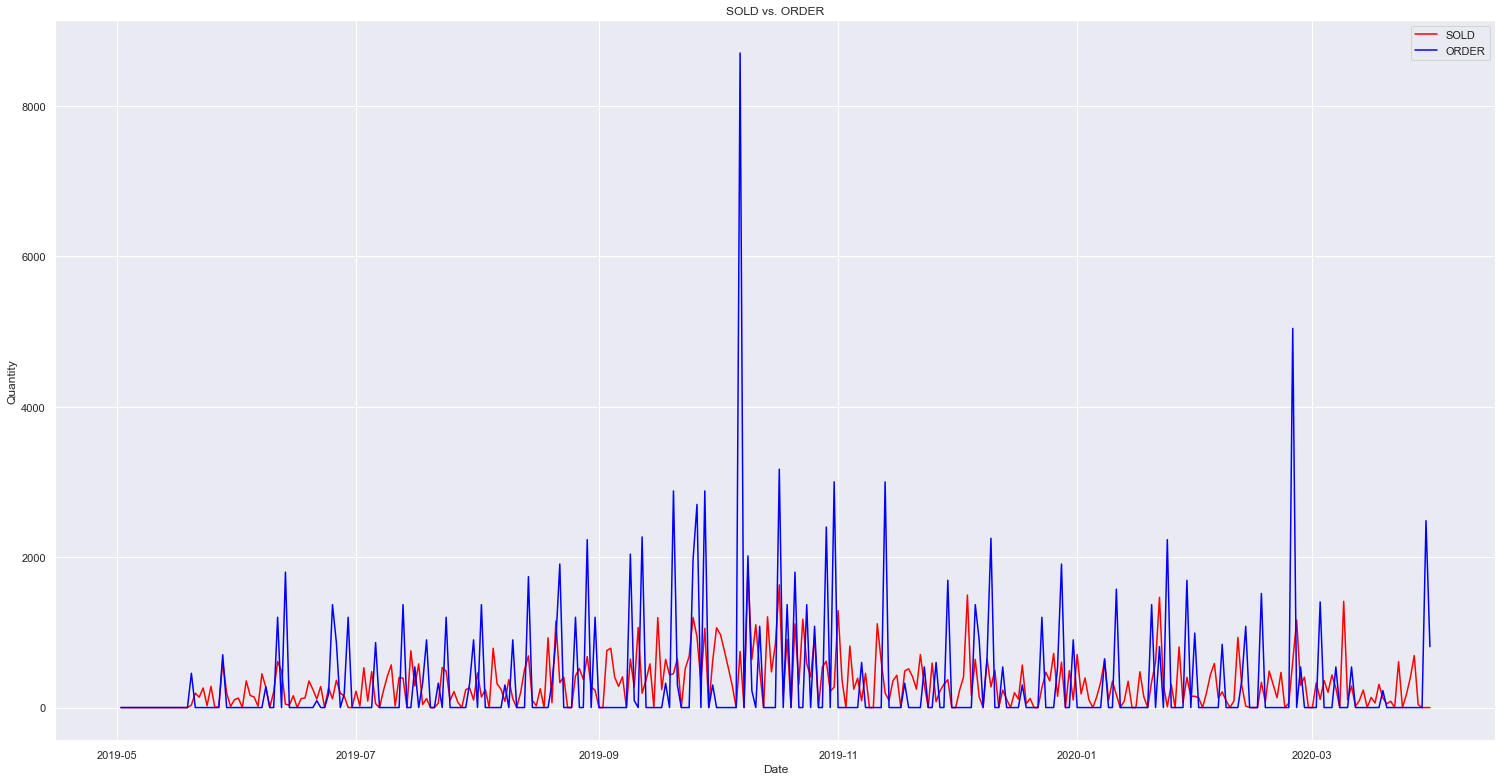

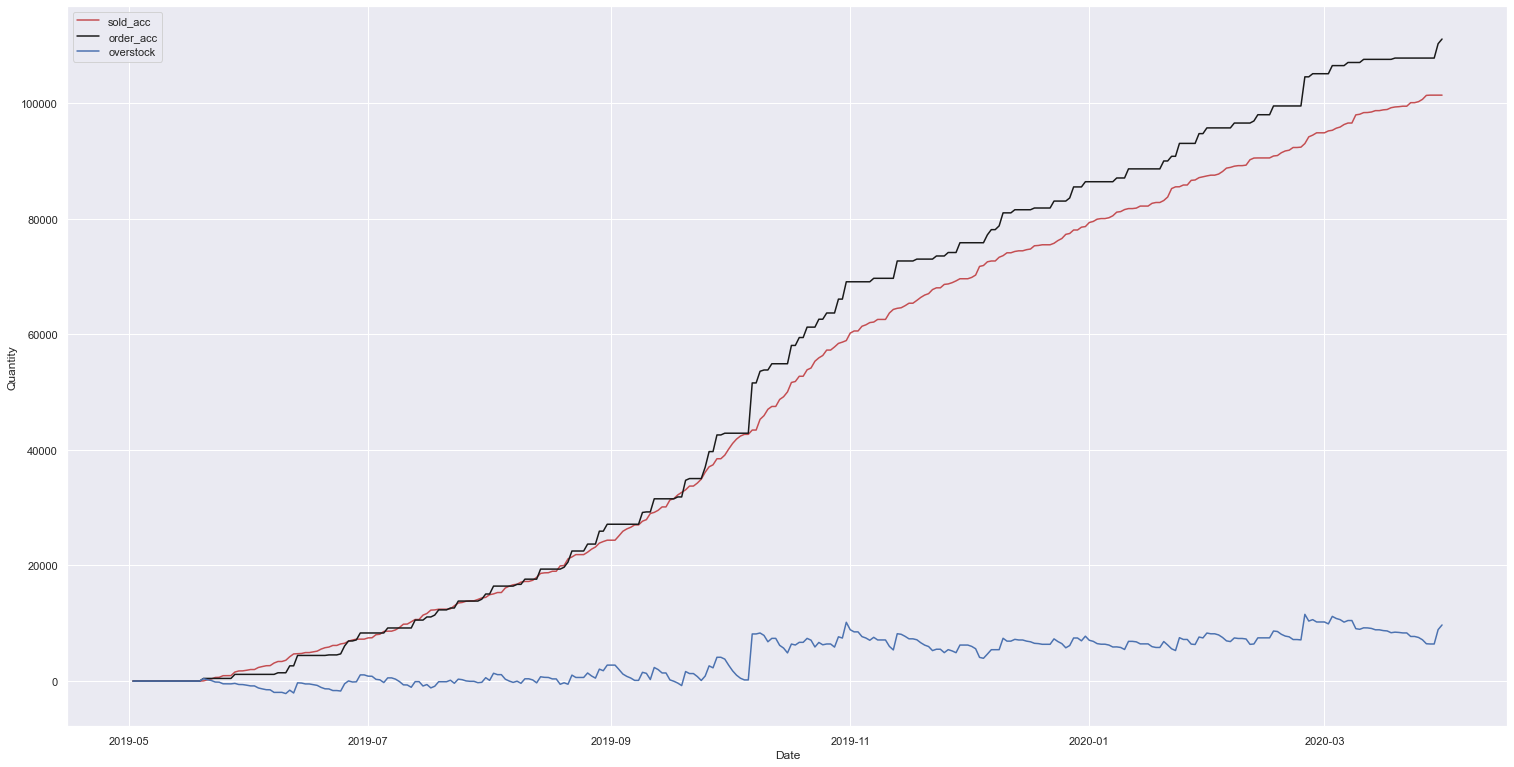

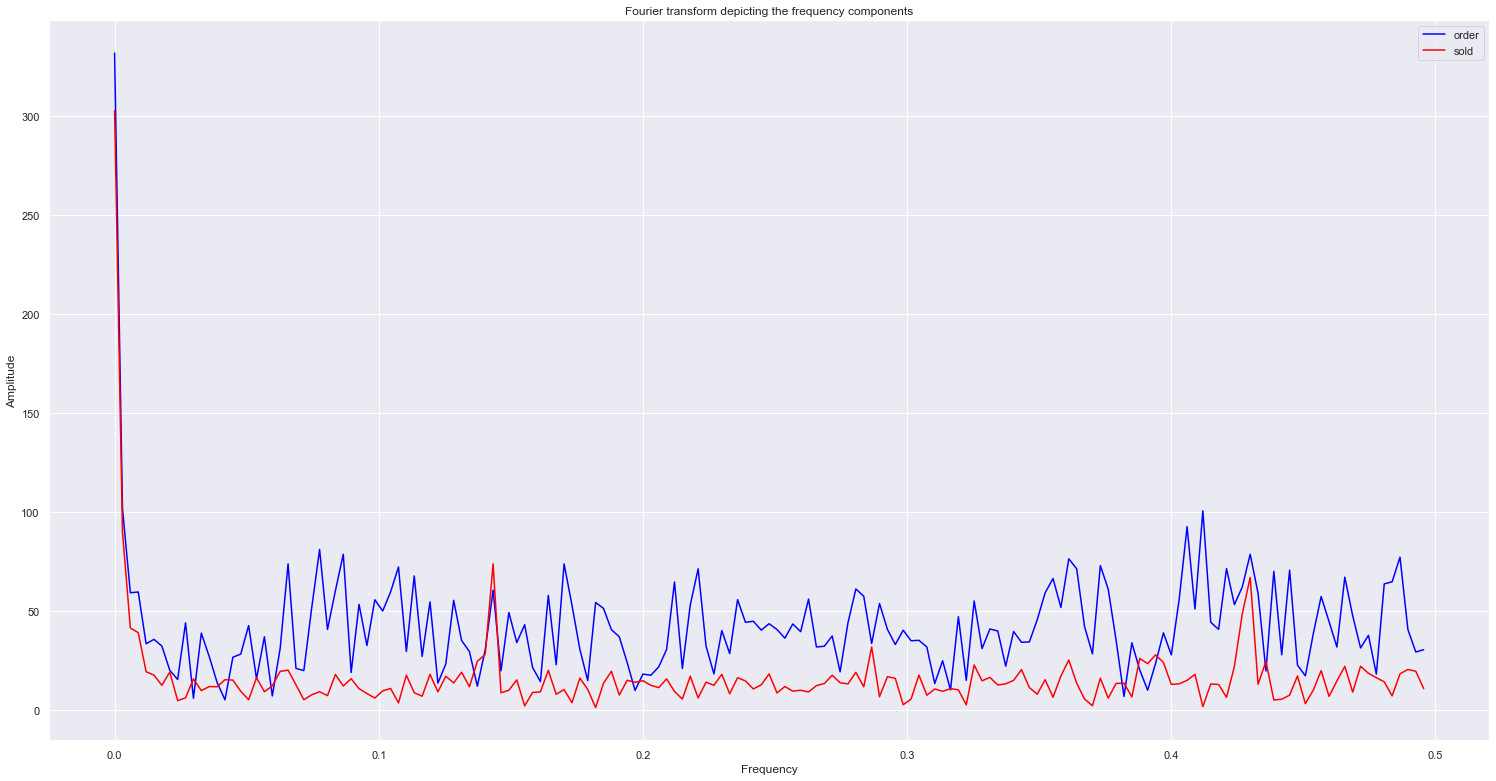

In [160]:
df_fever = plot_by_disease_name(df,'FEVER')

# FEVER
# order_sold plot: seasonal effect for fever medicine, large quantity of order in october and march
# sold quantity is slightly larger in october but not much
# accumulative plot: uptick in October to keep a larger stock
# frequency plot: not an obvious pattern for order
# sold: once a week (highest power at 0.15), once every 2.5 days (power at 0.43)

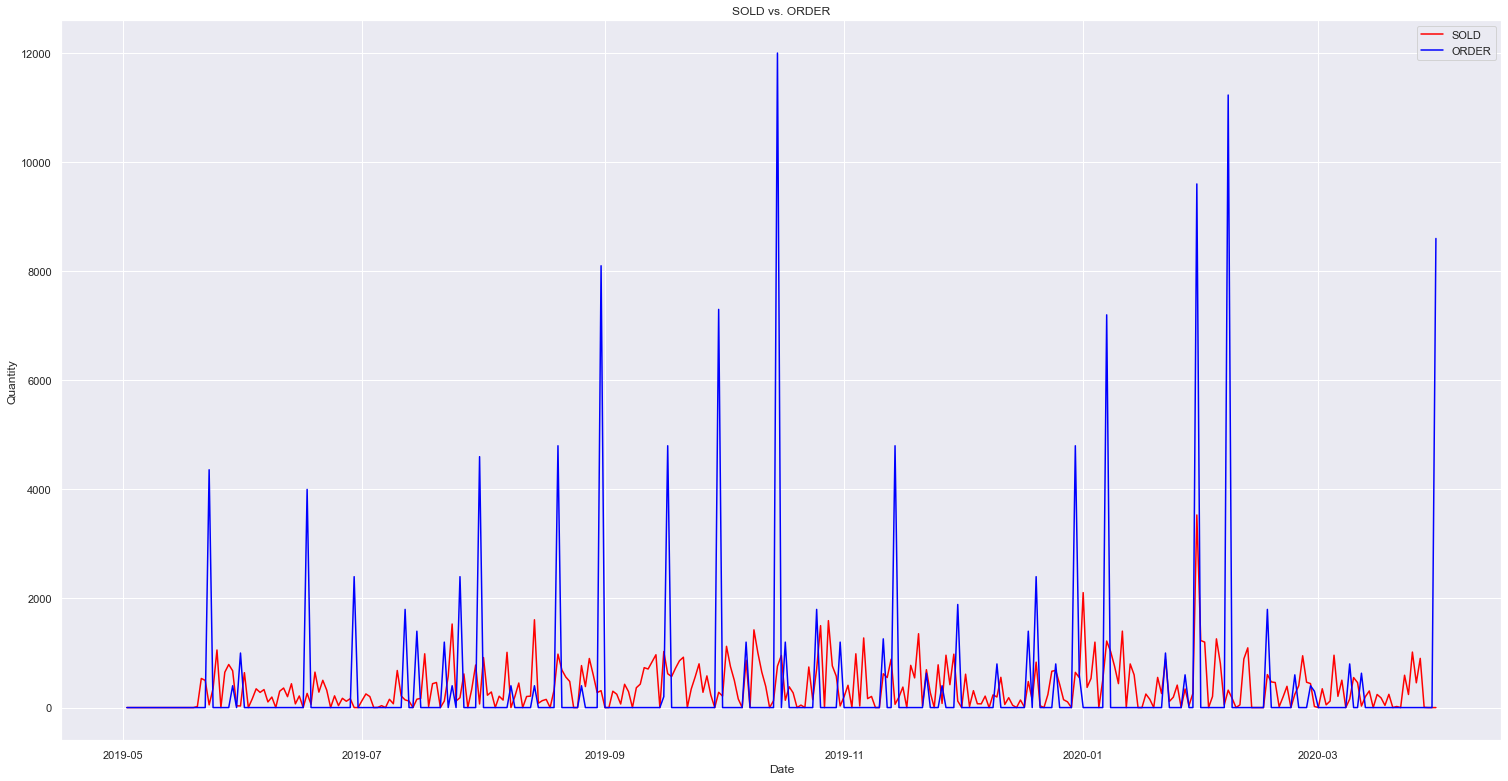

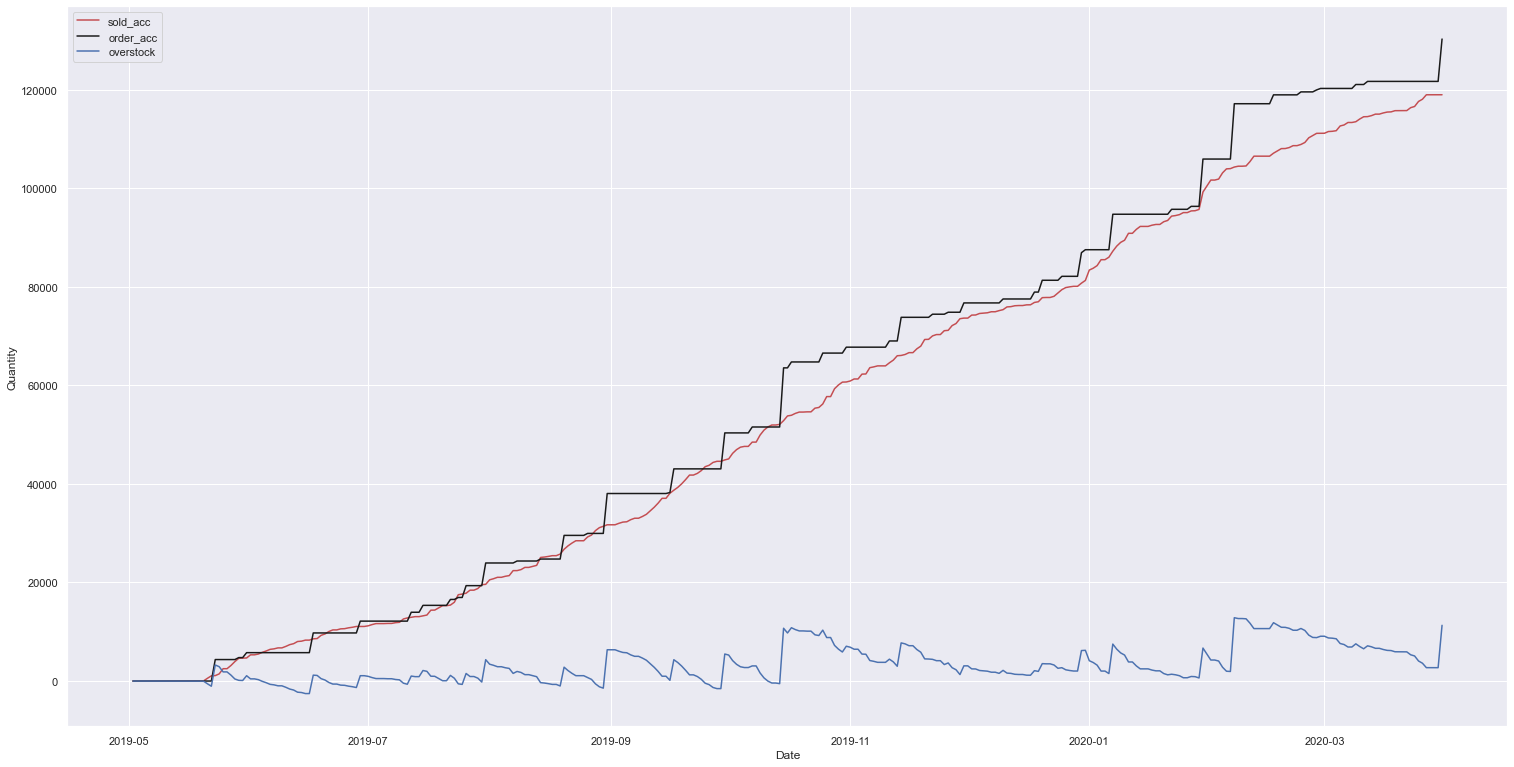

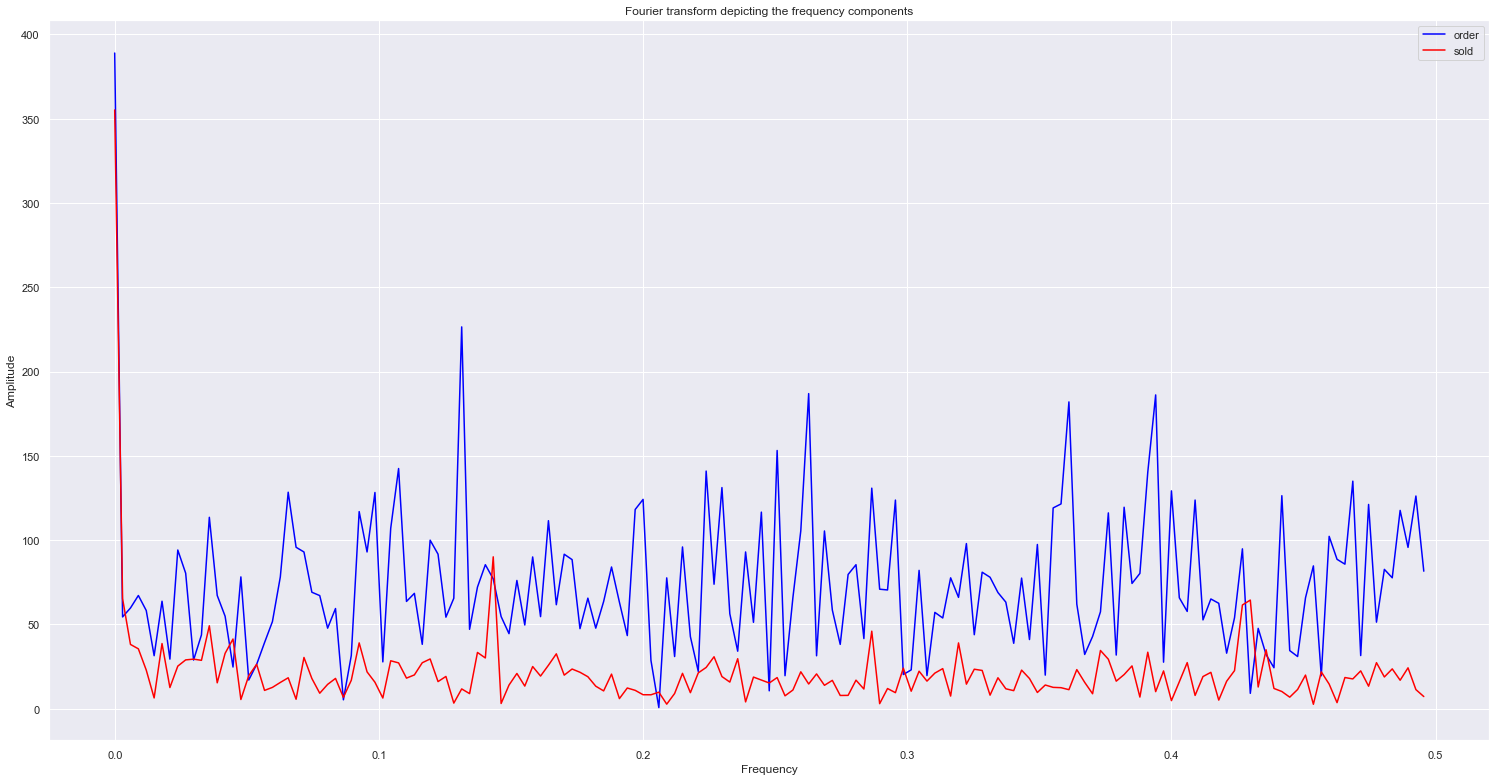

In [159]:
df_firstaid = plot_by_disease_name(df,'FIRST-AID')

#First-aid has a large order in october but less frequent after. 
# the sold is low in May, June, July and December
# Frequenty replenishment with minimum overstock
# weekely order and sold

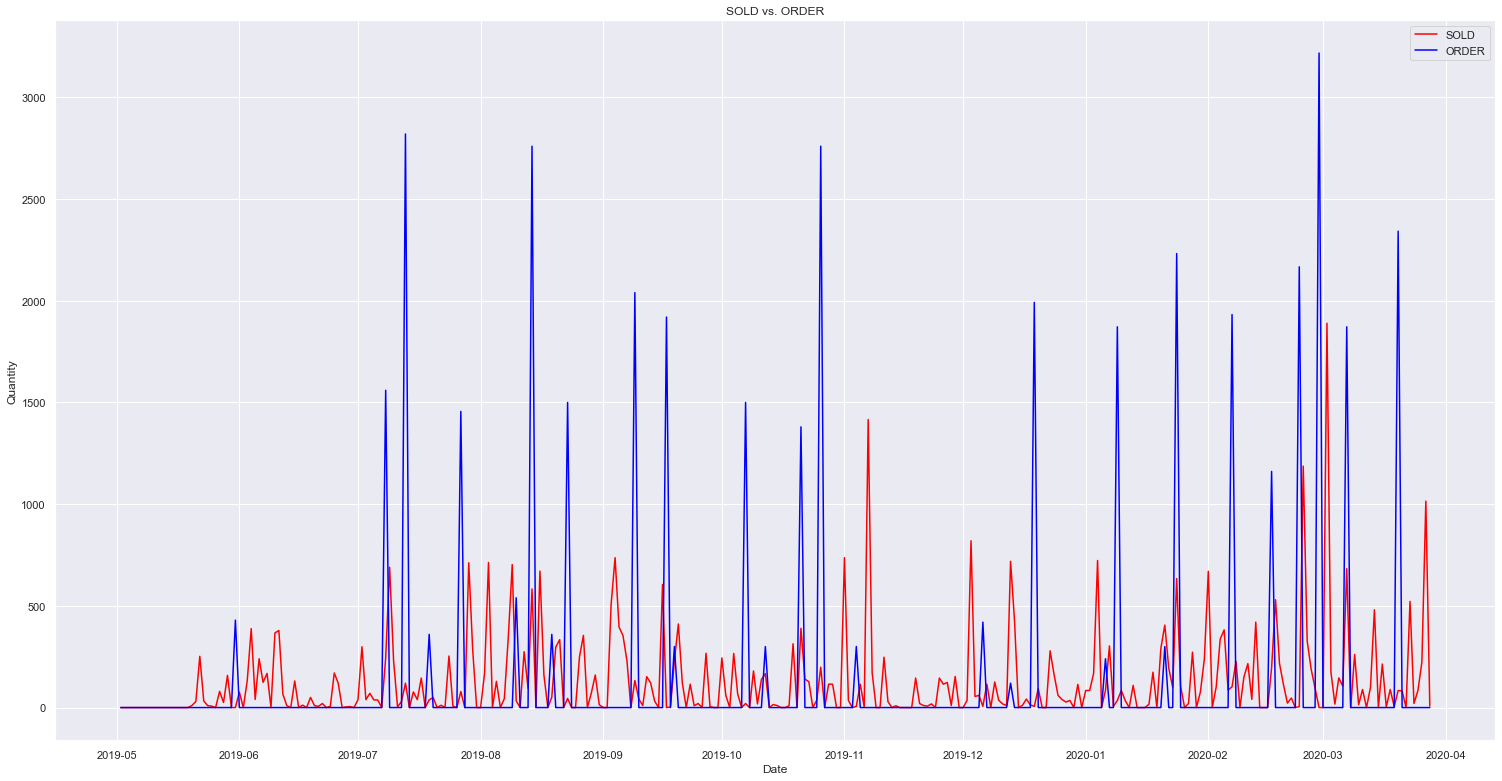

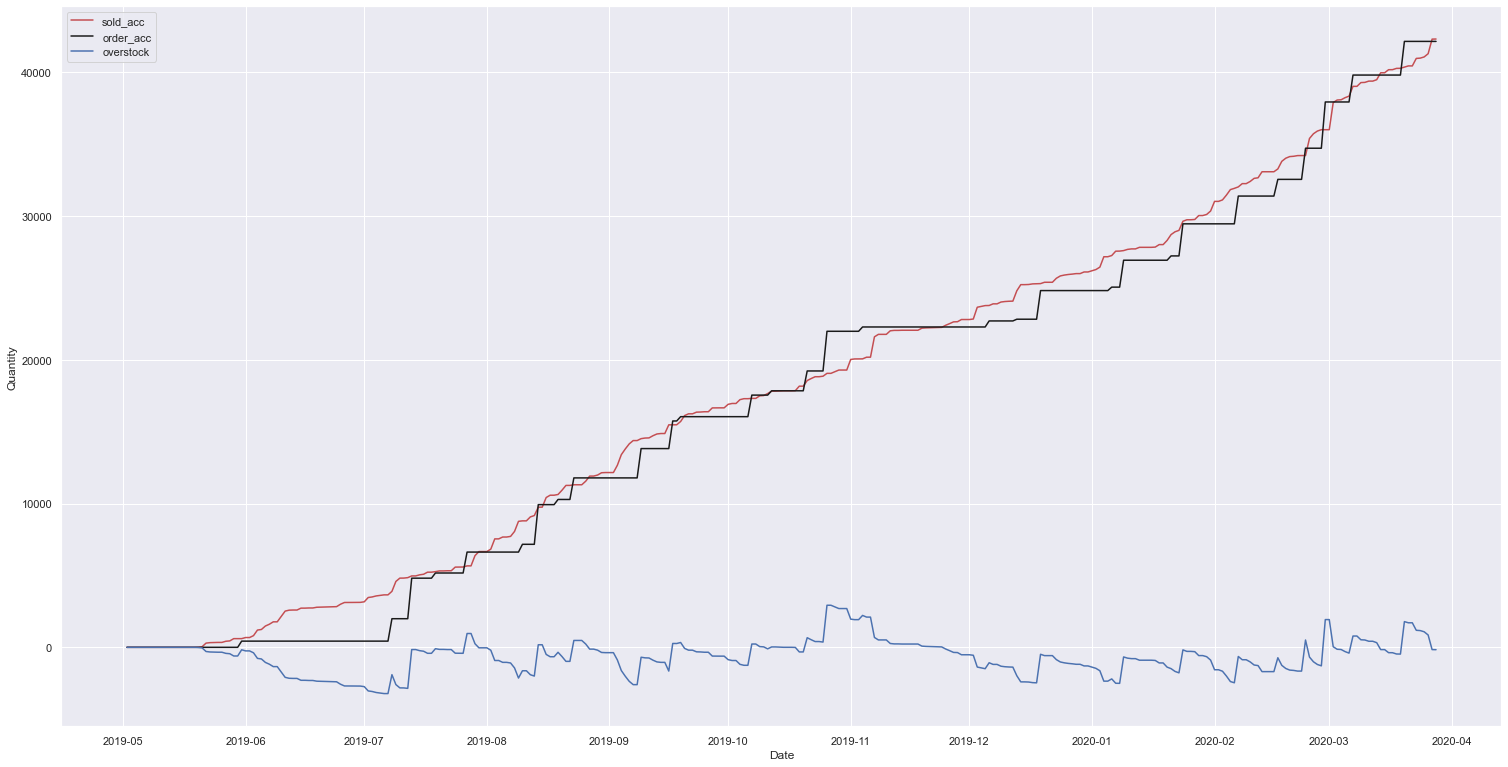

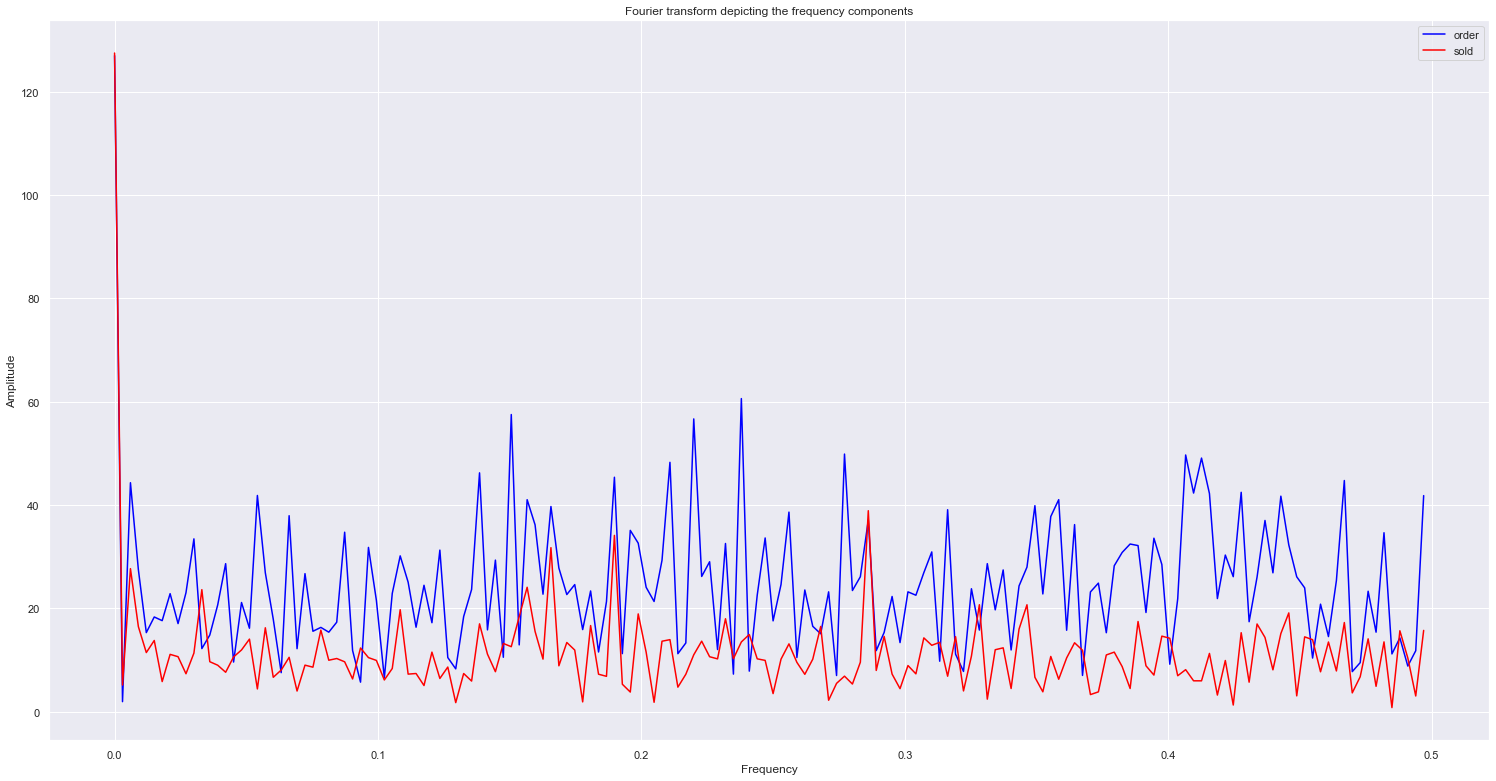

In [158]:
df_gastric = plot_by_disease_name(df,'GASTRIC')
# sold high in March and April.
# for gastric there is a period of time of understock. However, since we don't know the baseline so it was only relative.
# no longer has a weekely sold pattern. more like every 3-4 days or so (frequency at 0.18, 0.3)

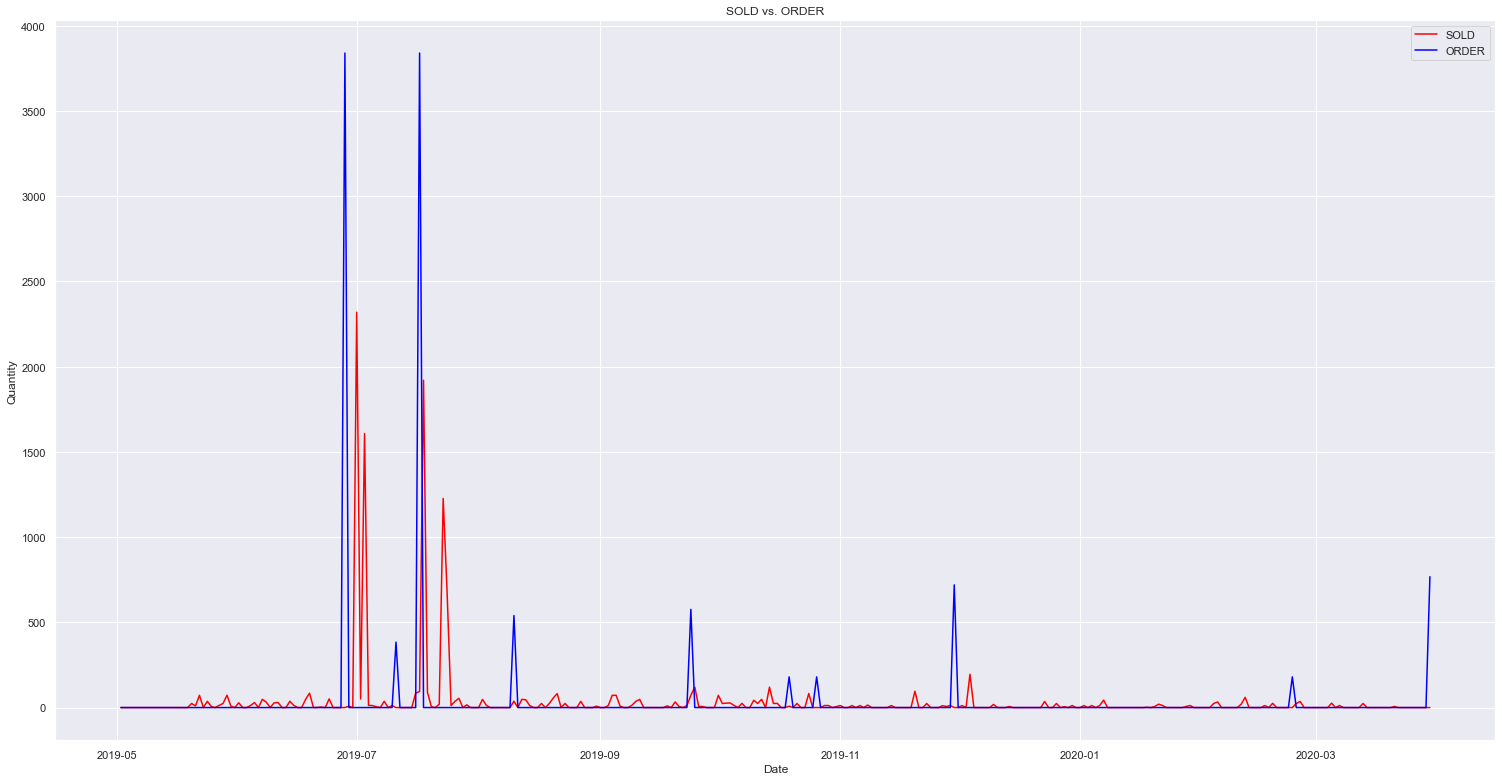

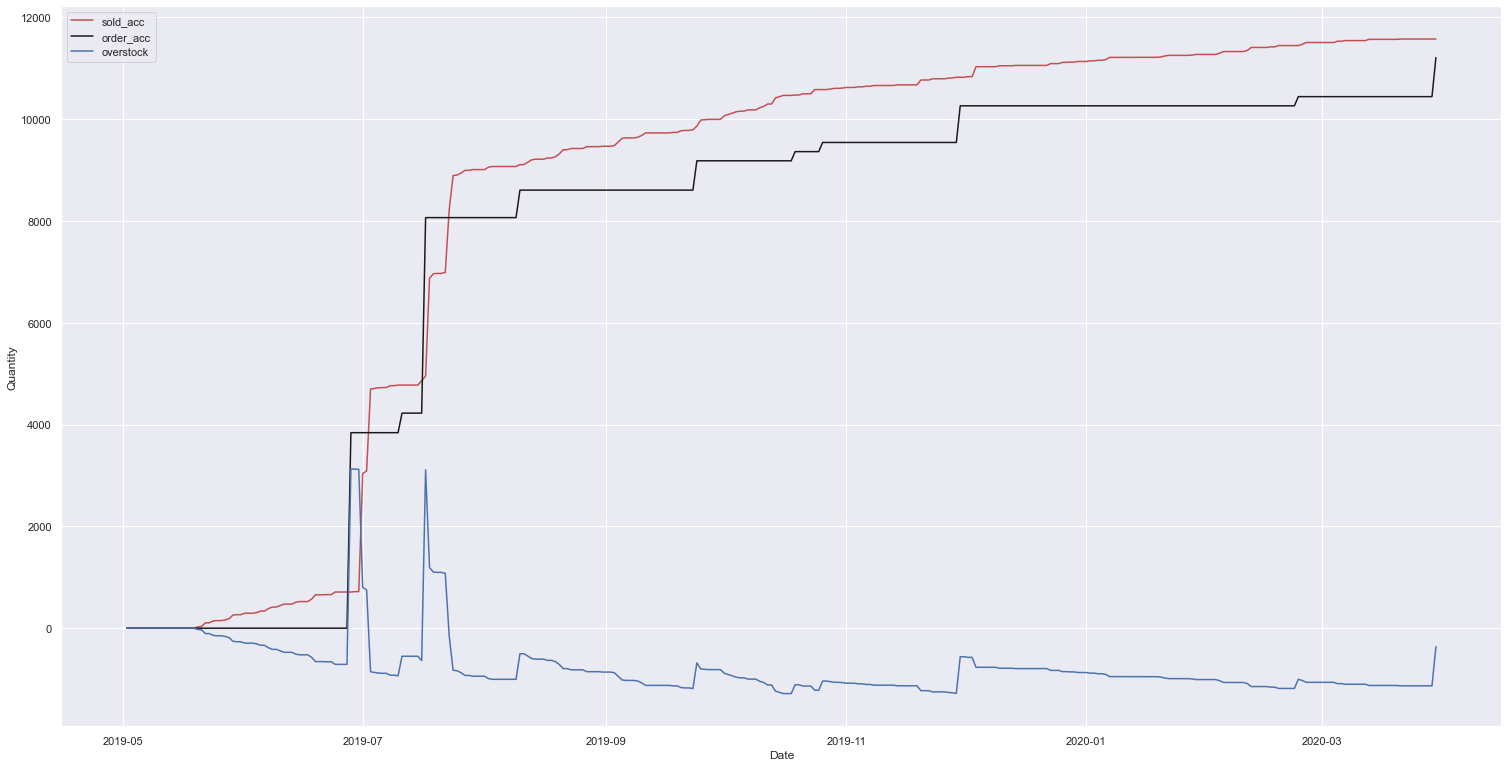

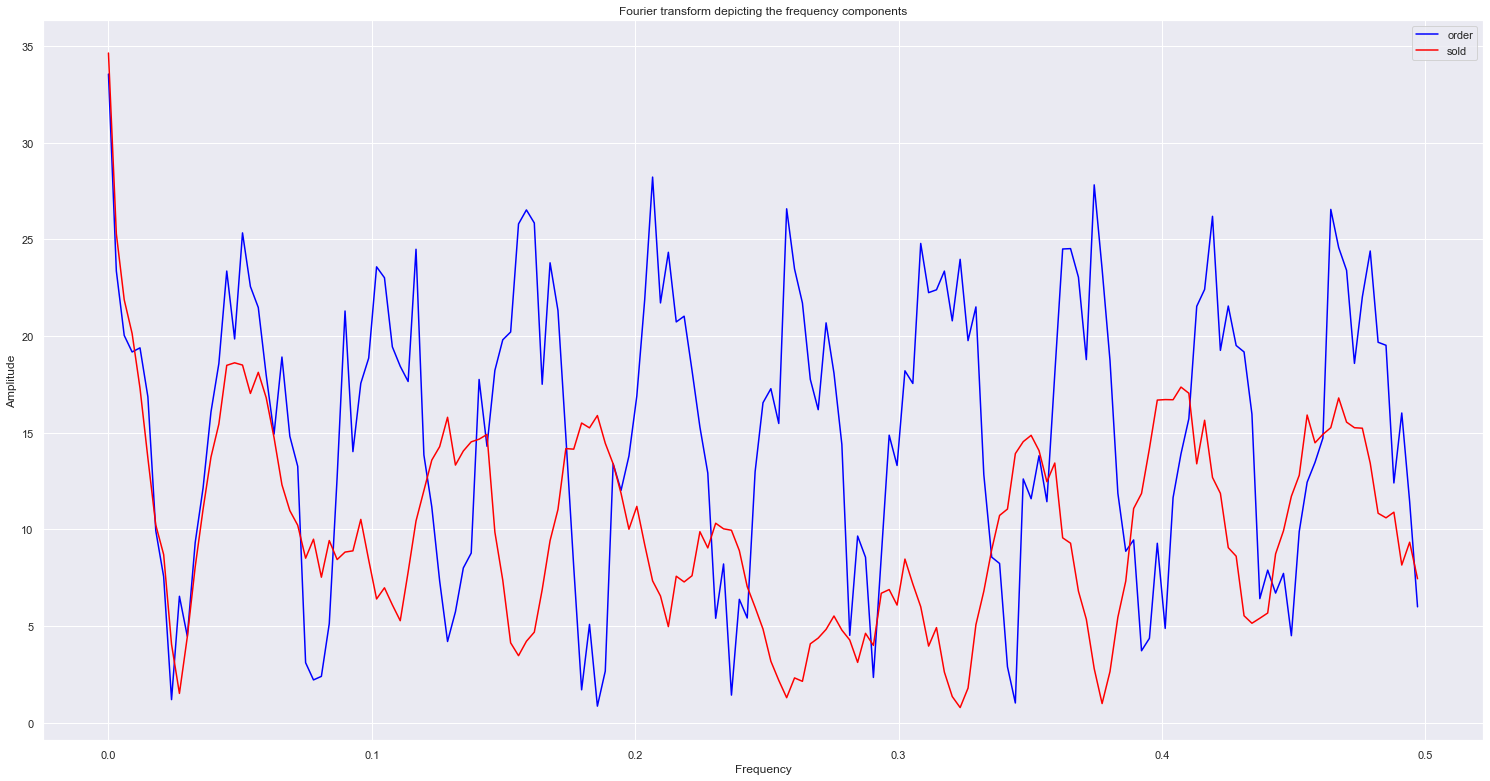

In [157]:
df_allergies = plot_by_disease_name(df,'ALLERGIES')

# Allergies
#very infrequenty order
#obtain a big stock and slowly consume it.
#showing understock, but without baseline we don't know the actual number
# no obvious pattern in the frequency plot

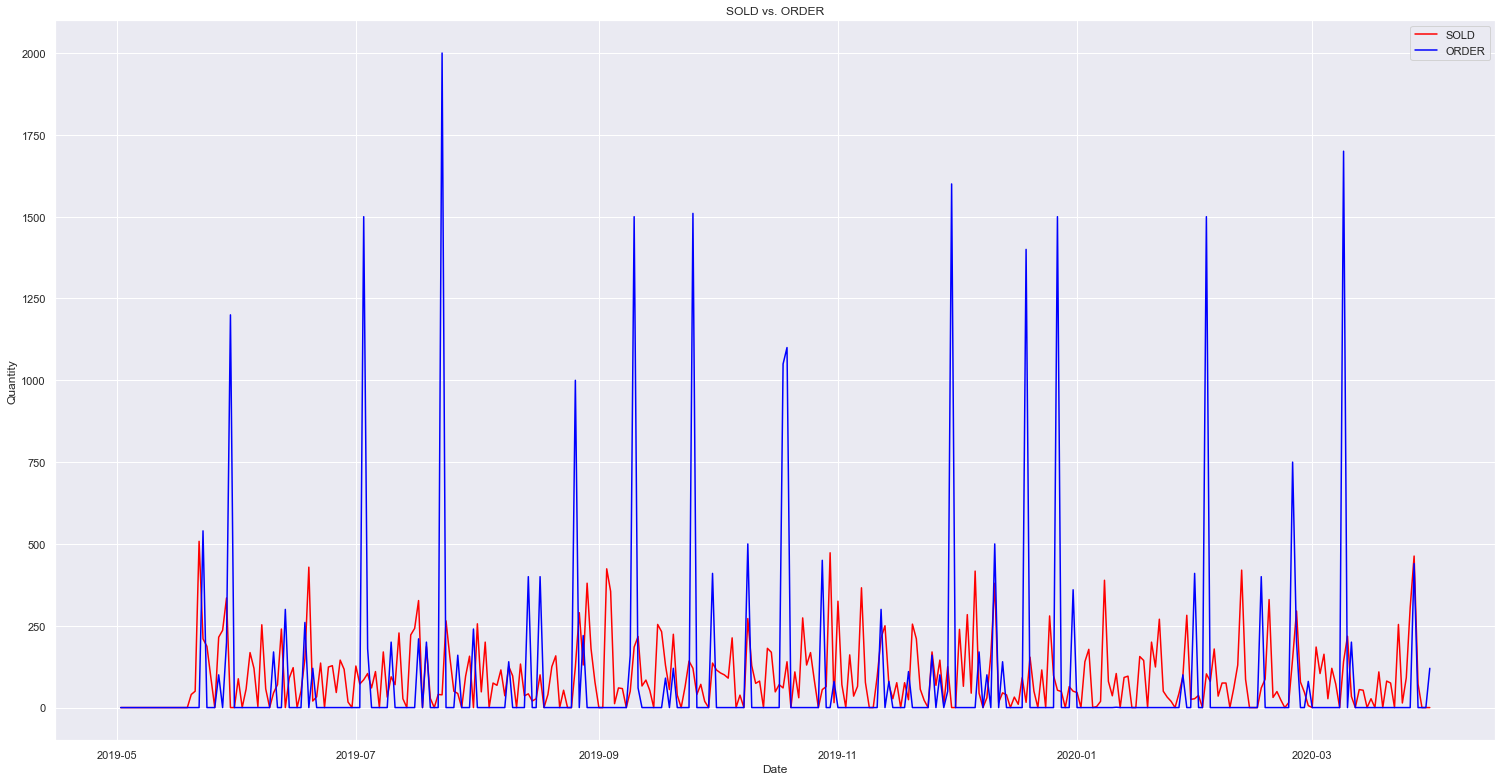

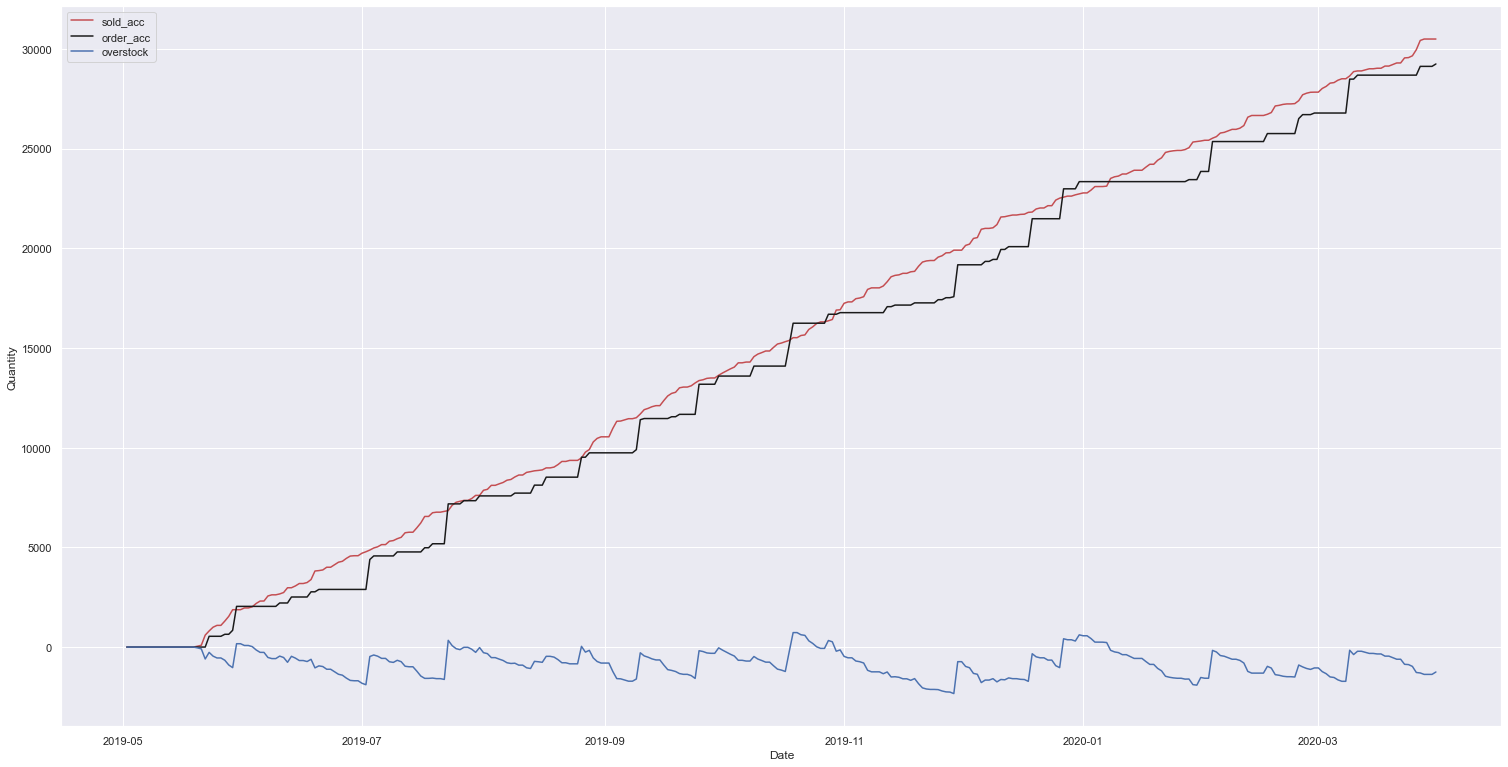

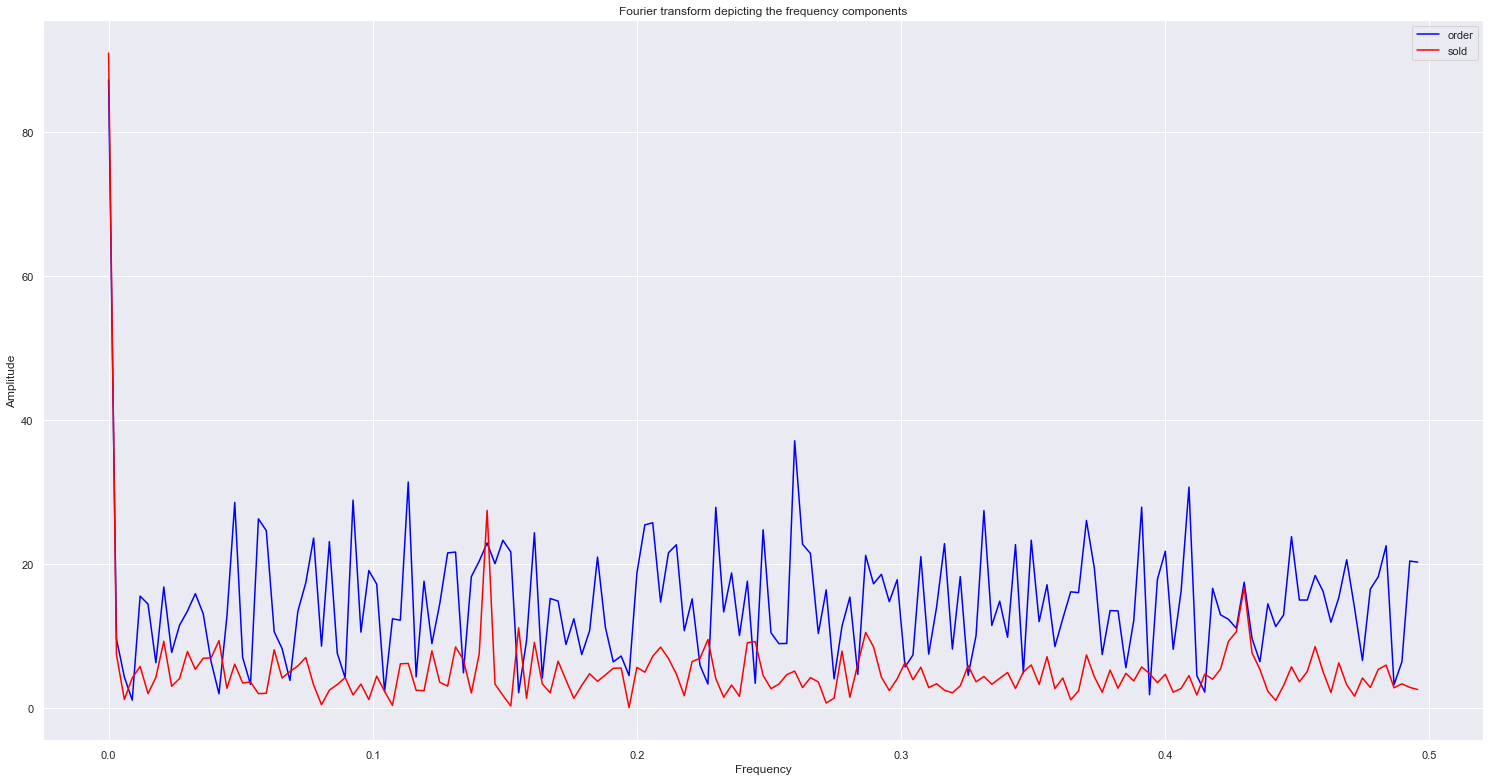

In [156]:
df_diabetes = plot_by_disease_name(df,'DIABETIES')
# not an obvious seasonal change
# understock, without knowing the baseline not sure whether it is actually understock
# strong weekly order pattern (highest power 0.15)

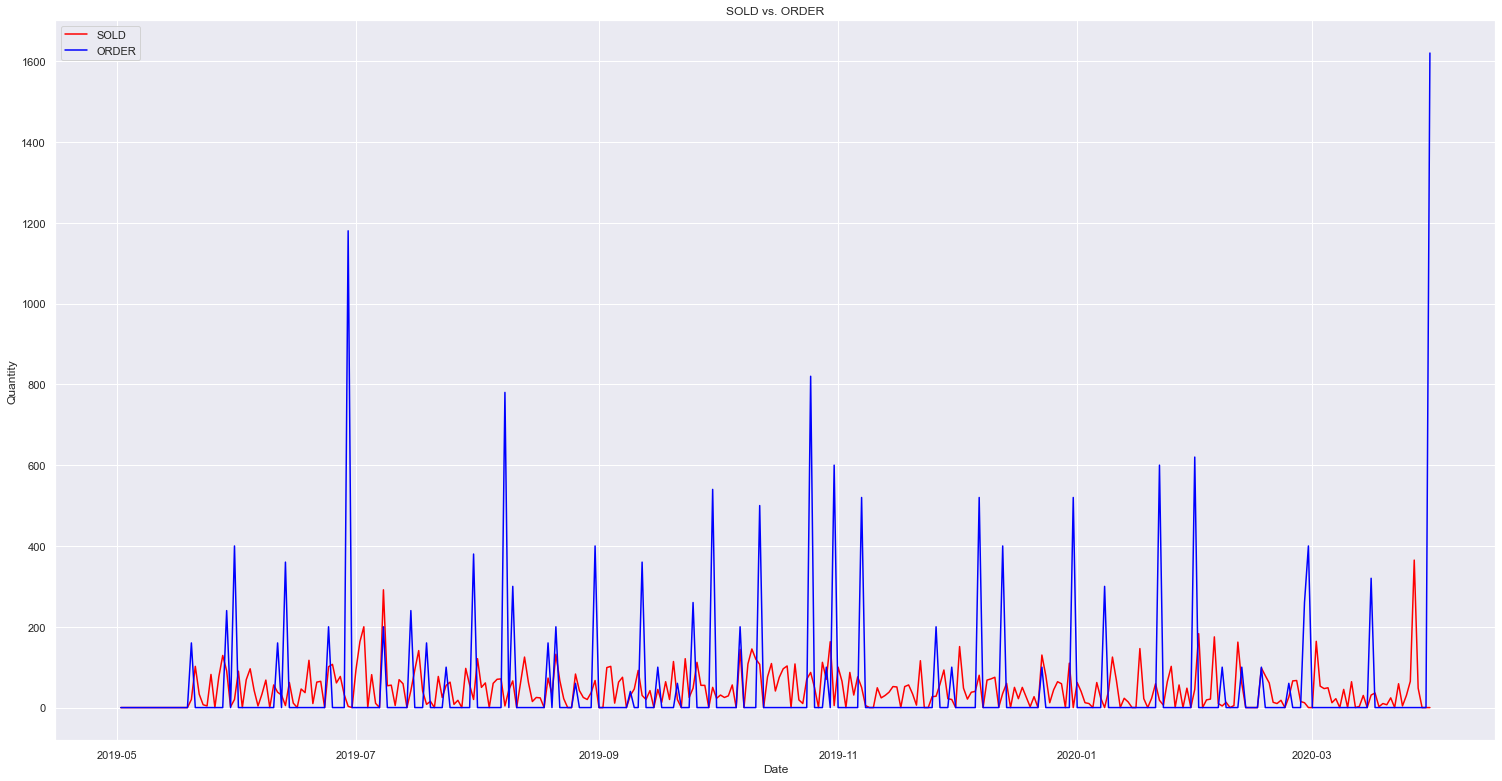

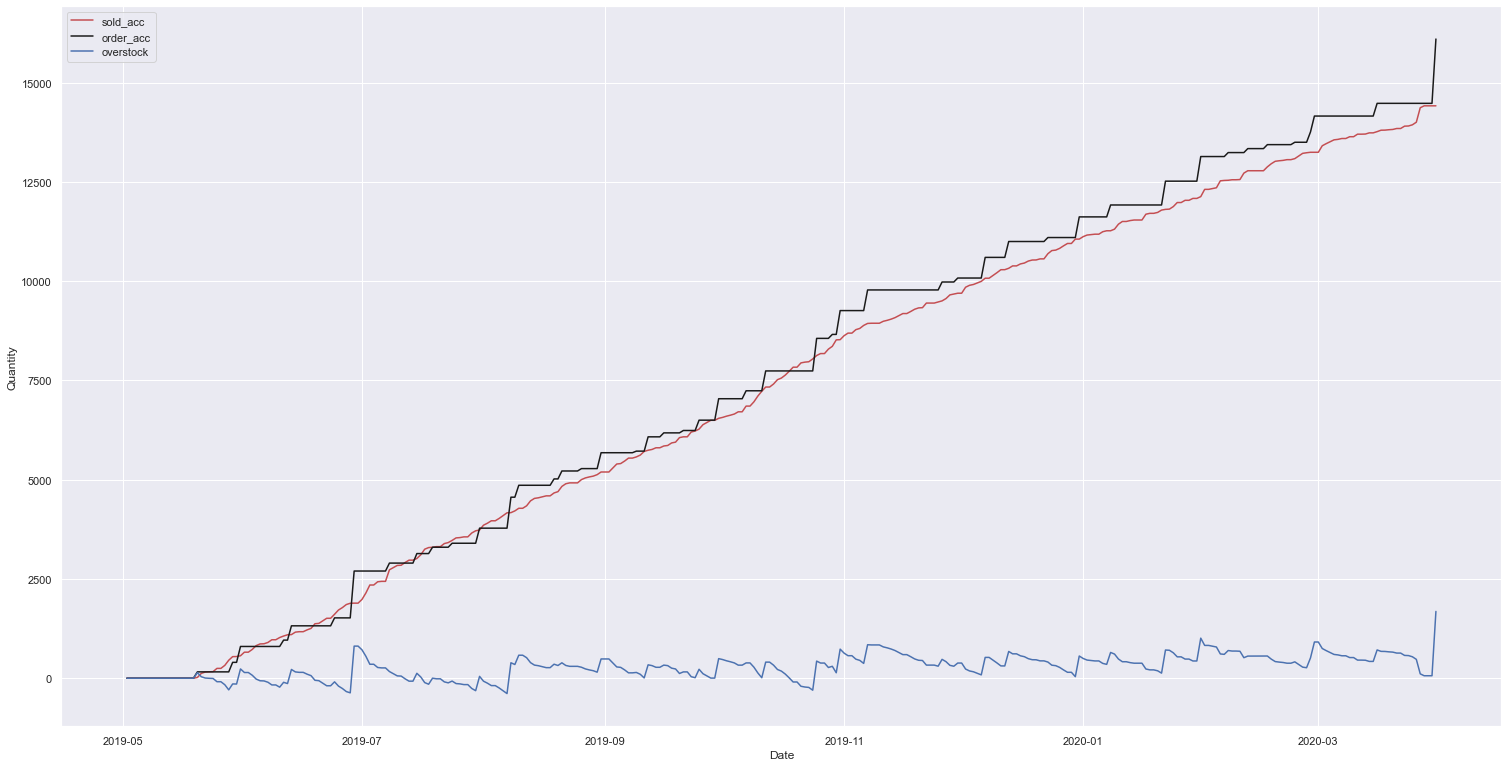

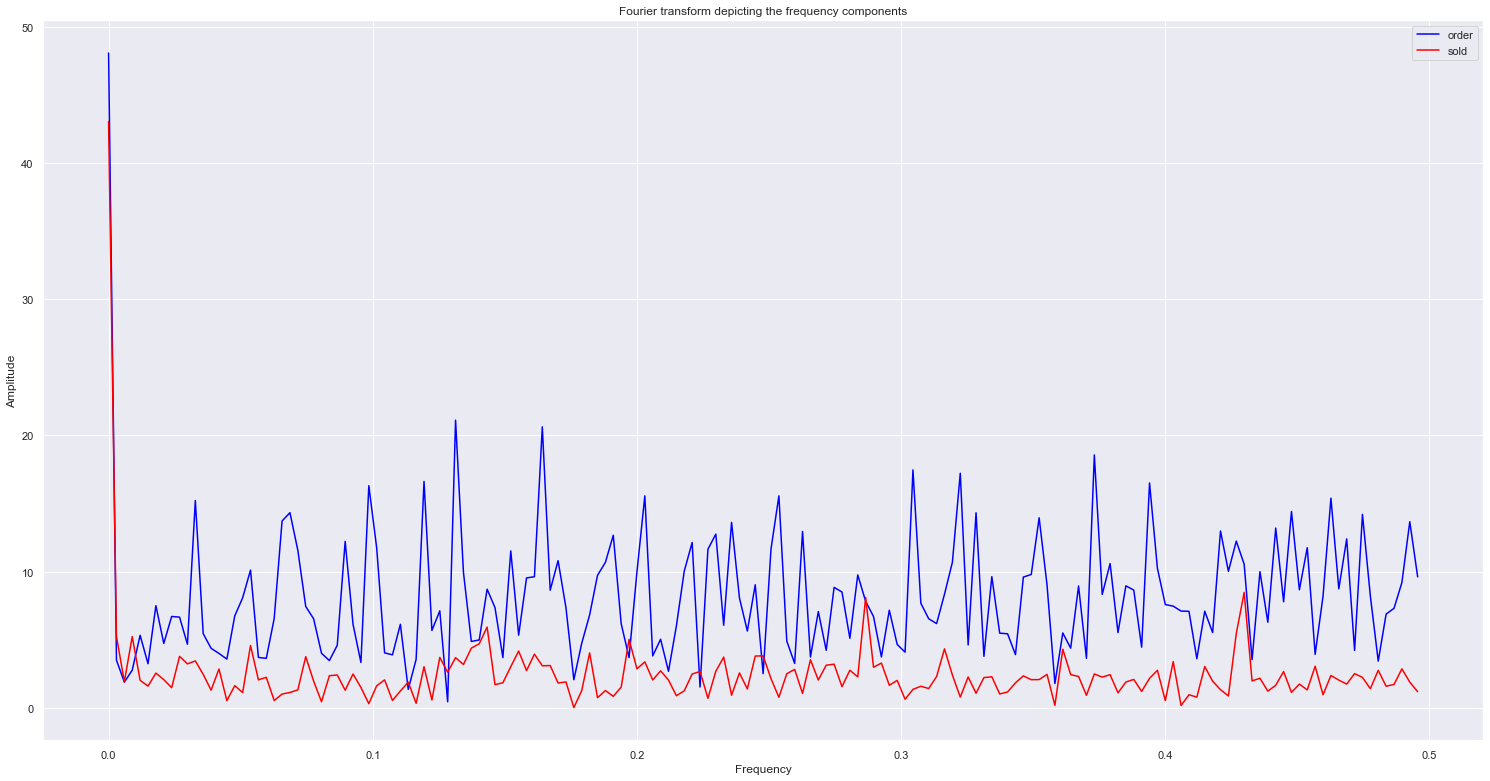

In [155]:
df_thyroid = plot_by_disease_name(df,'THYROID')
# thyroid, somewhat month to month variation in terms of order, but not much in sold
# typical pattern of having a frequent small stock and consume it
# not a obvious pattern in terms of frequency in order
# sold frquency slightly higher power in 0.28 and 0.43, suggesting once every 2-3 days

In [150]:
#find out the top 15 cities that medicines are sold to


print(df['CITY'].unique()) # to print categories name only
print(df['CITY'].value_counts()[0:15]) # to print count of every category


['NO_CITY' 'SINGARAYAKONDA' 'KANDUKUR' 'ONGOLE' 'KANIGIRI' 'DARSI'
 'PODILI' 'VIJAYAWADA' 'EDUMUDI' 'CHIMAKURTHY' 'PERNAMITTA' 'TANGUTUR'
 'TALLURU' 'KONIJEDU' 'KAVALI' 'ULAVAPADU' 'MEDARAMETLA' 'ADDANKI'
 'CHIRALA' 'PAMUR' 'NIDAMANUR' 'EAST GANGAVARAM' 'MARKAPURAM' 'KARAVADI'
 'DODDAVARAM' 'ULICHI' 'NELLORE' 'UPPUGUNDUR' 'DODDAVARAM        '
 'DODDAVARAM ' 'YARAGONDAPALAM' 'AMMANBROLU' 'NARASARAOPET'
 'CHILAKALURI PETA' 'HYDERABAD' 'GIDDALUR' 'TIRUPATHI' 'GUNTUR']
ONGOLE            2024
NELLORE           2024
KANDUKUR          1729
KAVALI            1301
CHIMAKURTHY        661
ADDANKI            633
VIJAYAWADA         592
SINGARAYAKONDA     565
CHIRALA            543
MARKAPURAM         408
PAMUR              399
KANIGIRI           380
DARSI              332
TANGUTUR           260
HYDERABAD          204
Name: CITY, dtype: int64


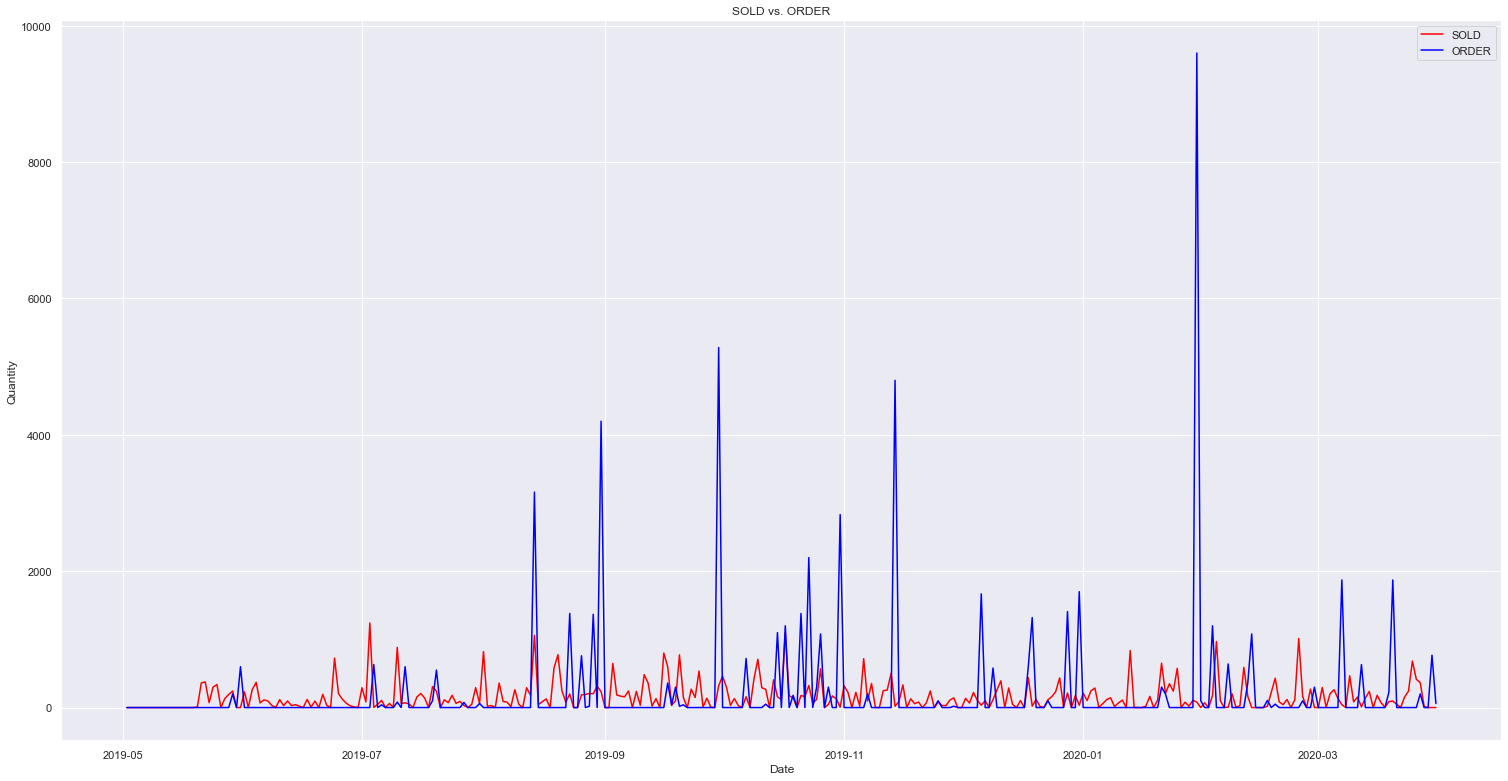

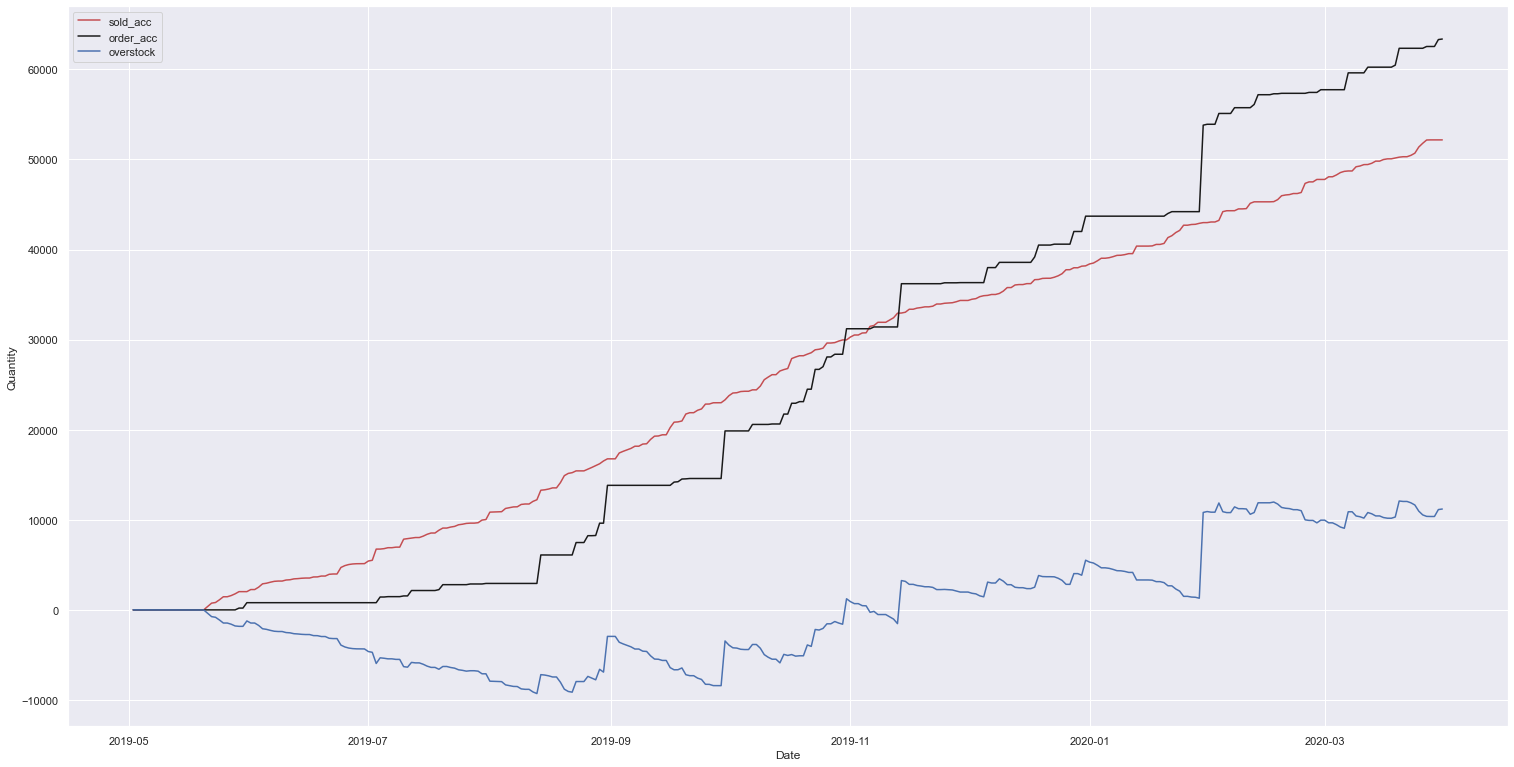

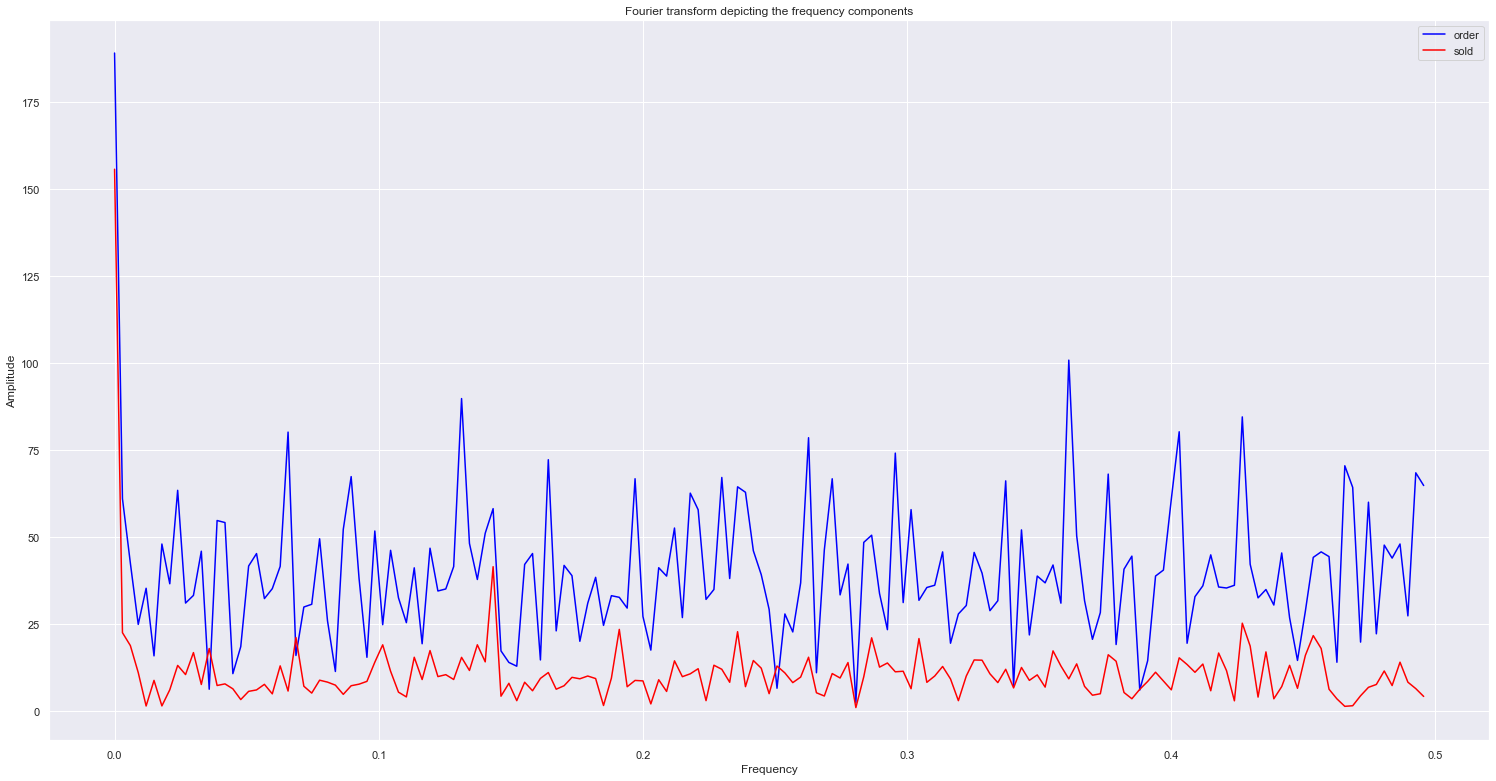

In [165]:
df_ongole = plot_by_city_name(df,'ONGOLE')

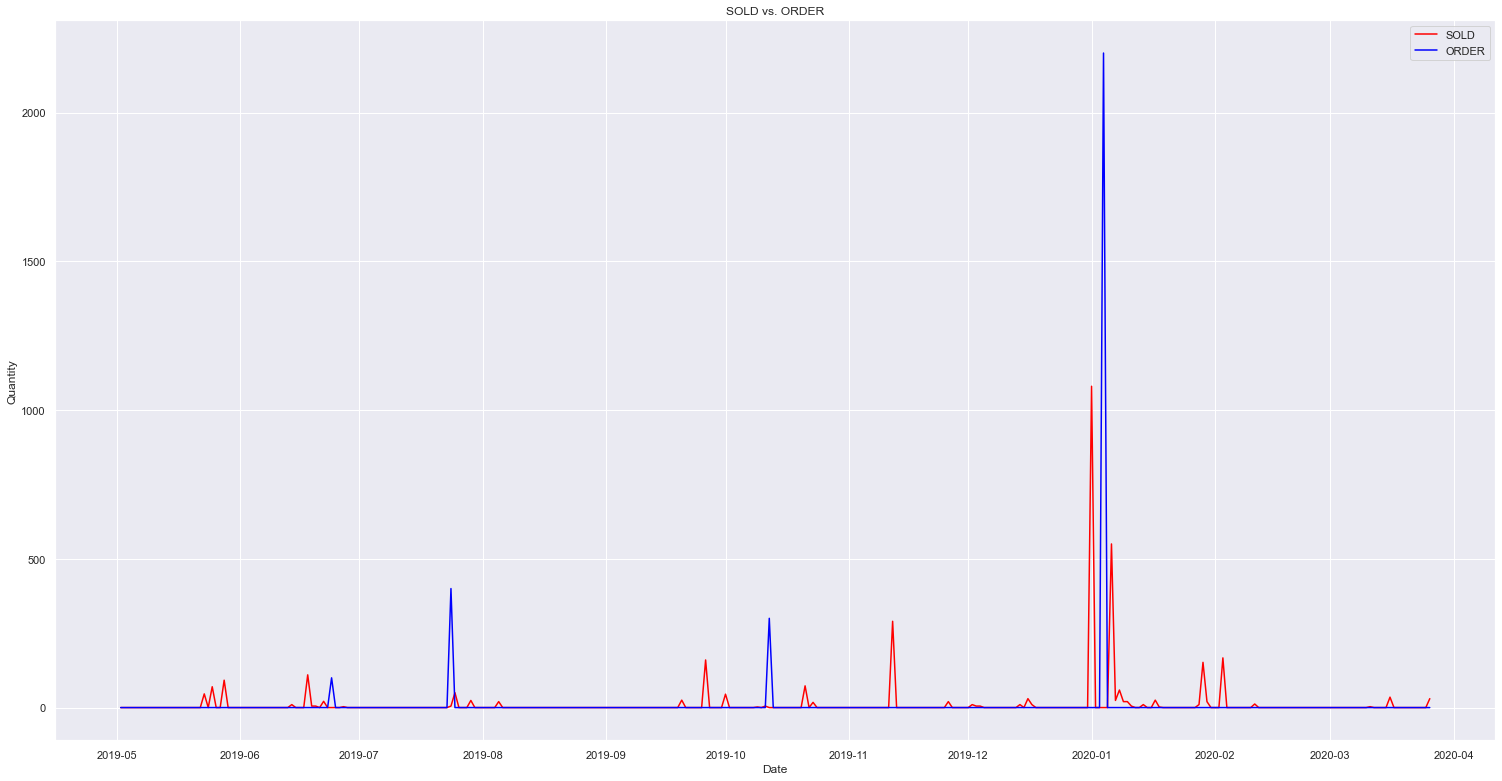

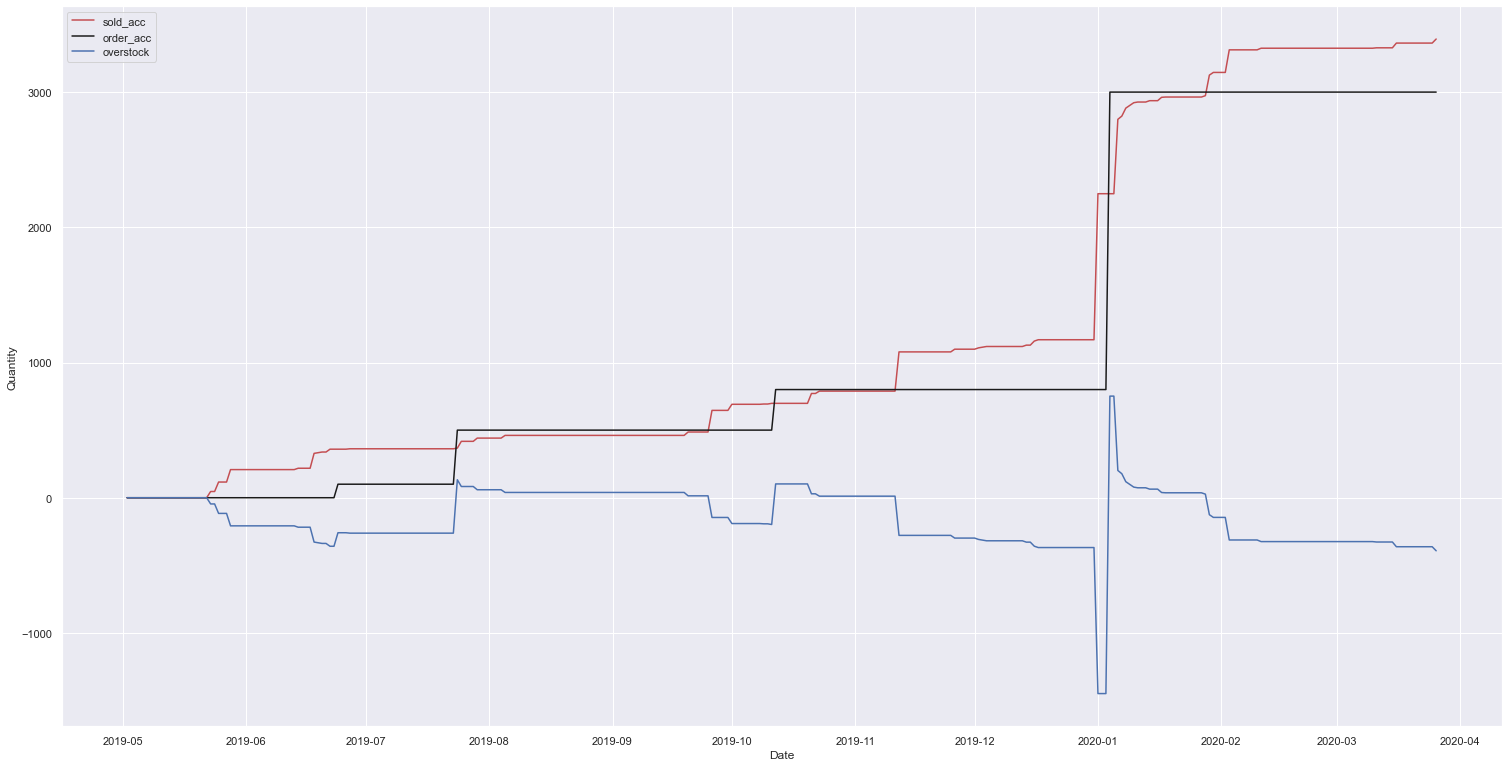

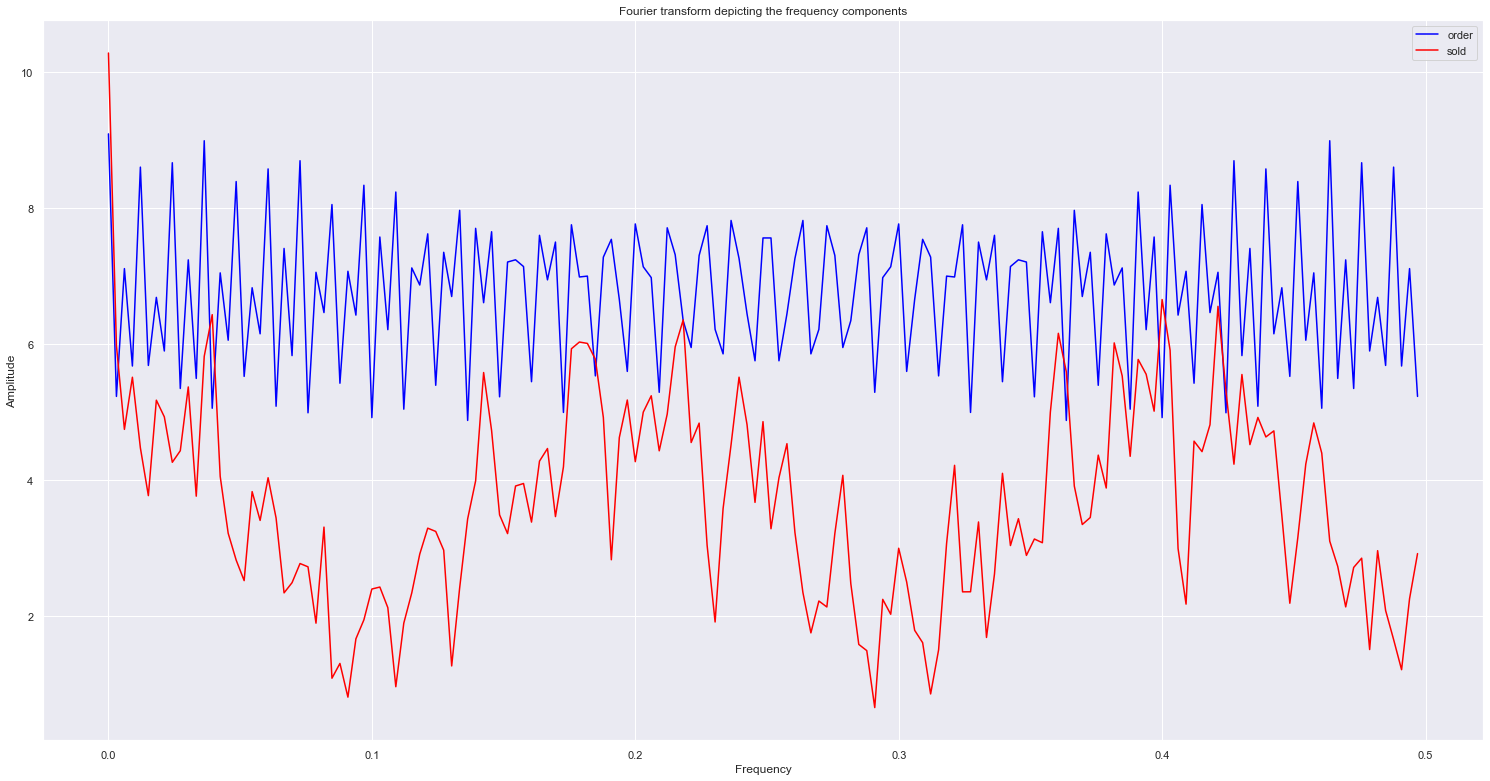

In [244]:
#no city only has a few transations here and there
df_nocity = plot_by_city_name(df,'NO_CITY')

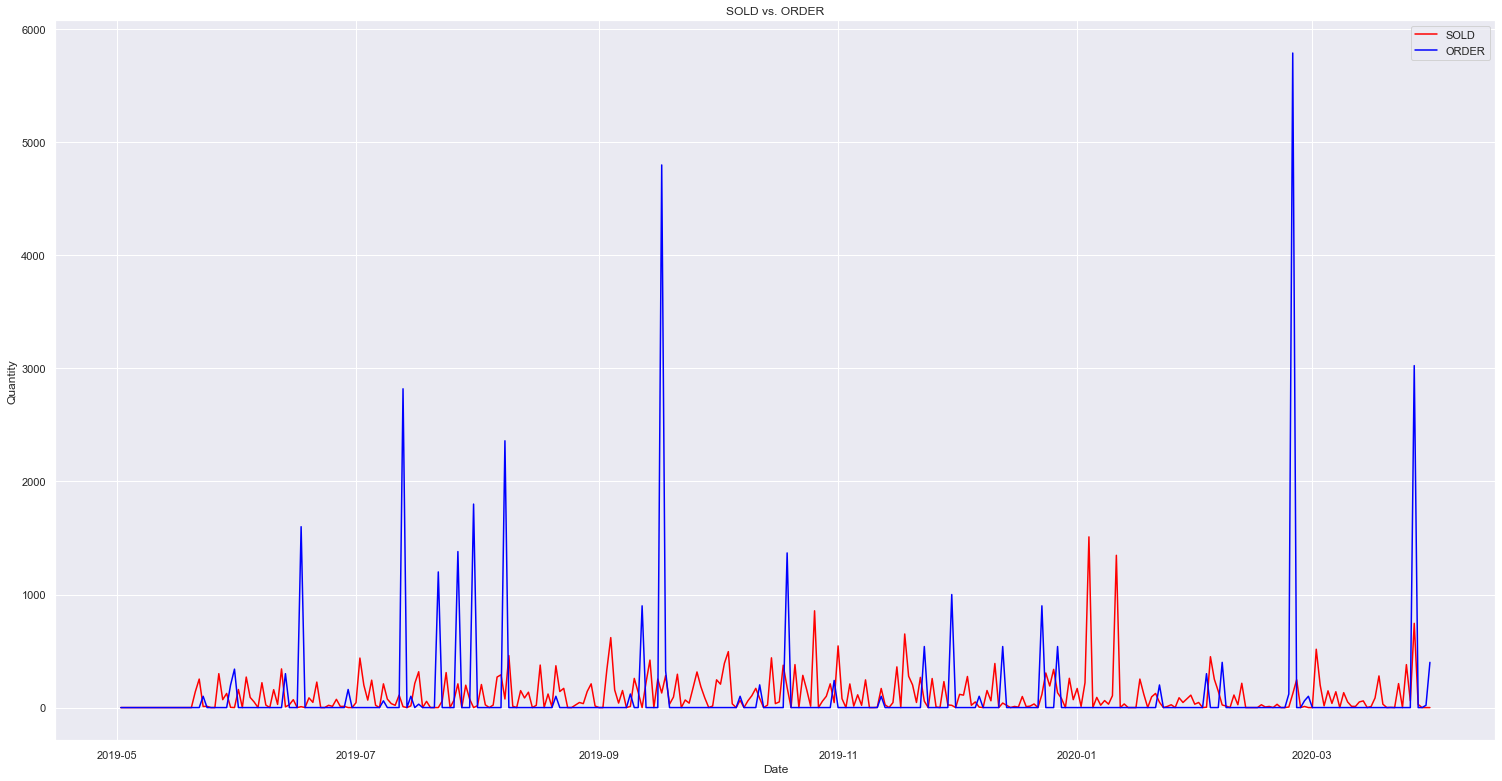

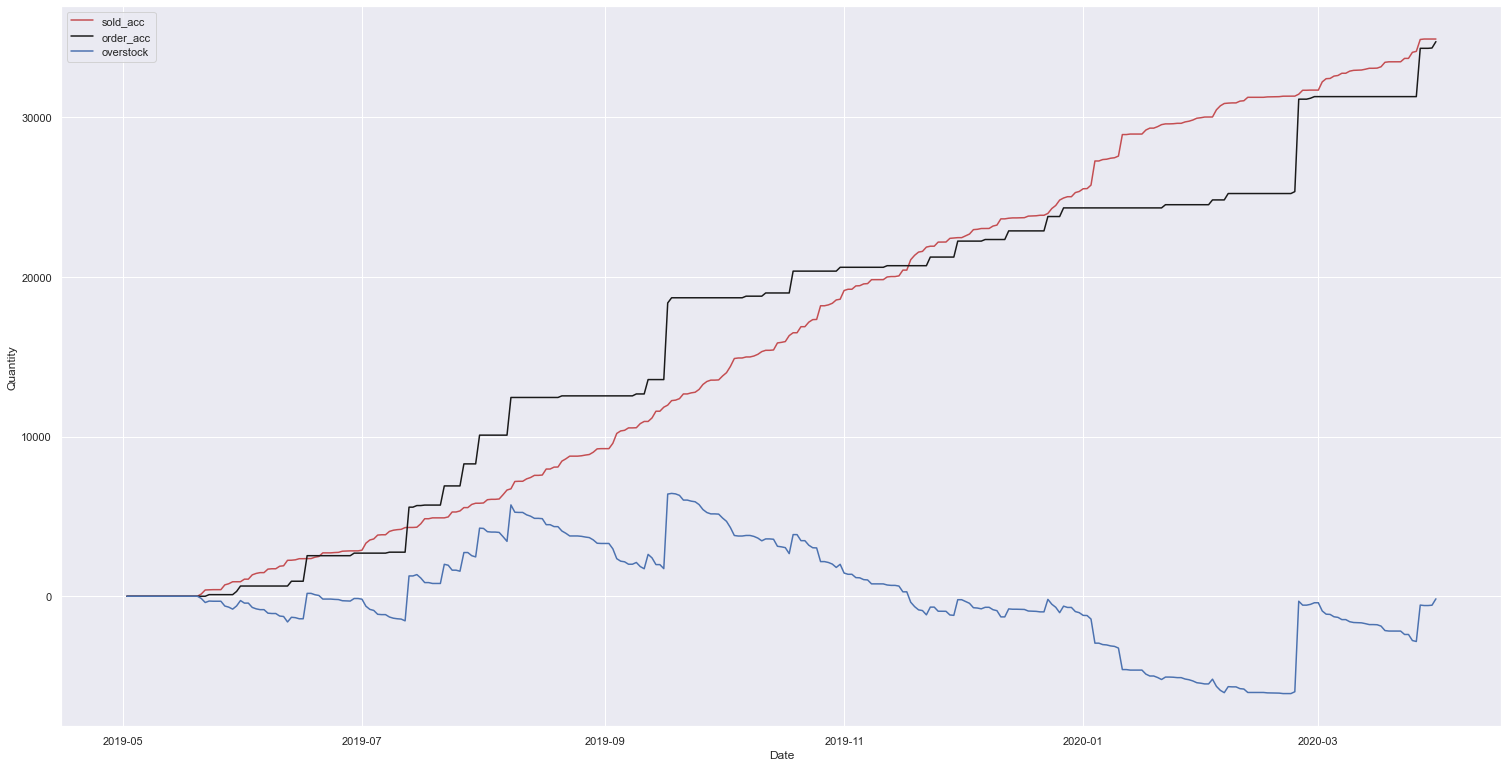

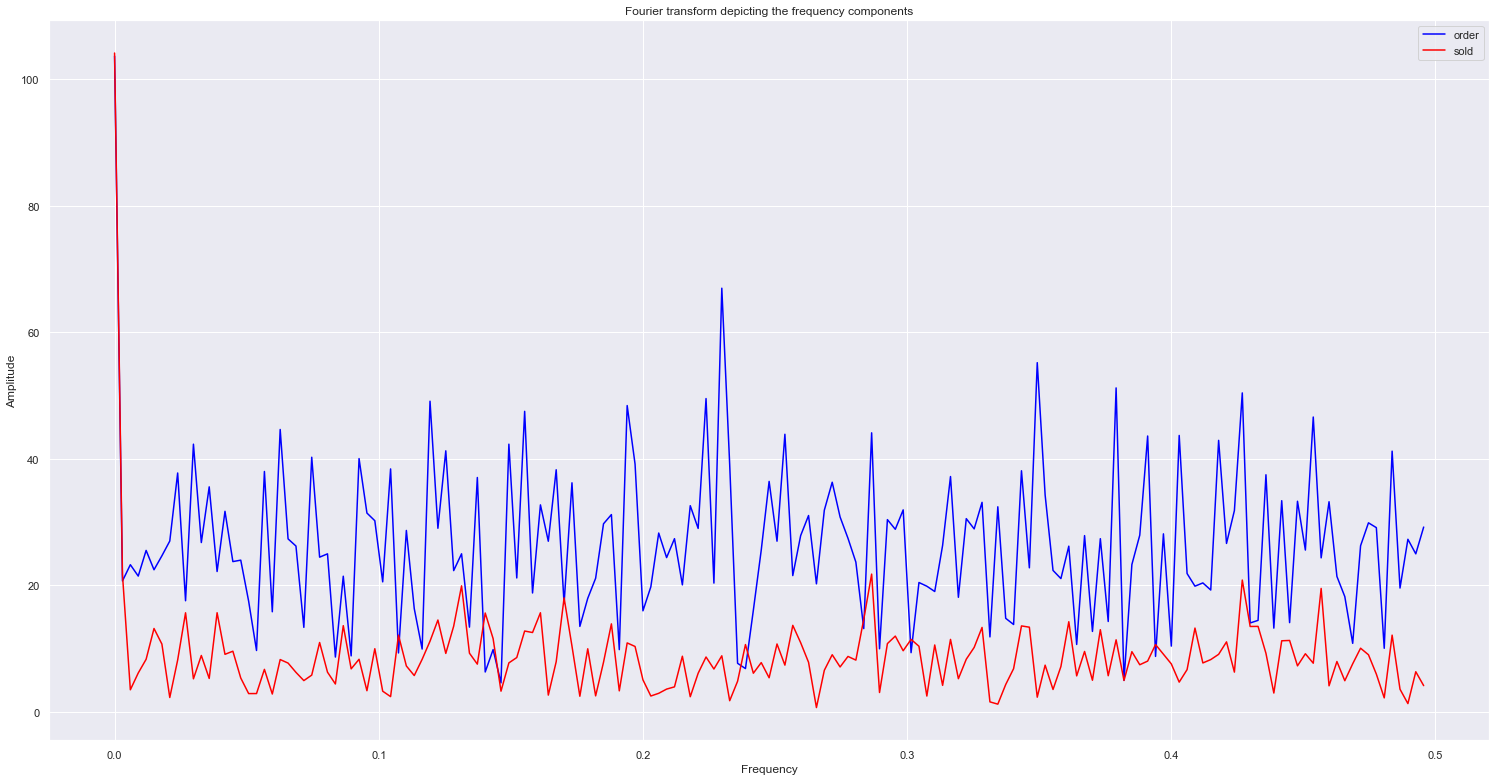

In [245]:
df_kavali = plot_by_city_name(df,'KAVALI')

In [46]:
city_disease = df.groupby(['CITY','DISEASE_NAME']).sum().reset_index().sort_values(['SOLD_QUANTITY'],
                                                     ascending=False)[['CITY','DISEASE_NAME','ORDER_QUANTITY','SOLD_QUANTITY']]
city_disease.iloc[0:25,]

CITY    DISEASE_NAME  ORDER_QUANTITY  SOLD_QUANTITY
115      NELLORE       FIRST-AID         29462.0        33646.5
114      NELLORE           FEVER         41037.0        26524.0
135       ONGOLE       FIRST-AID         33180.0        24060.0
64      KANDUKUR       FIRST-AID         11591.0        20269.5
134       ONGOLE           FEVER         18908.0        18037.5
85        KAVALI       FIRST-AID         14240.0        15993.0
63      KANDUKUR           FEVER         19113.0        15861.5
84        KAVALI           FEVER         14460.0        14732.5
116      NELLORE         GASTRIC         12746.0        12764.5
136       ONGOLE         GASTRIC         11269.0        10985.5
132       ONGOLE  BLOOD PRESSURE          5014.0         8705.5
4        ADDANKI       FIRST-AID          4742.0         7919.0
65      KANDUKUR         GASTRIC         11453.0         7823.5
62      KANDUKUR       DIABETIES          8312.0         6978.0
133       ONGOLE       DIABETIES          7462.0         6562.0
58     HYDERABAD       FIRST-AID          2430.0         6278.0
17   CHIMAKURTHY       FIRST-AID         16040.0         6094.5
86        KAVALI         GASTRIC          7854.0         6086.5
24       CHIRALA       FIRST-AID         14900.0         6021.0
16   CHIMAKURTHY           FEVER          9703.0         5916.5
31         DARSI       FIRST-AID          9320.0         5900.5
70      KANIGIRI           FEVER          2027.0         5807.5
23       CHIRALA           FEVER          5696.0         5545.0
201   VIJAYAWADA           FEVER          8484.0         5477.0
3        ADDANKI           FEVER          4179.0         5406.5

In [171]:
city_list = pd.DataFrame(df['CITY'].value_counts()[0:10])
city_list = city_list.reset_index()
city_list.columns = ['city','count']
city_list

city  count
0         NELLORE   2024
1          ONGOLE   2024
2        KANDUKUR   1729
3          KAVALI   1301
4     CHIMAKURTHY    661
5         ADDANKI    633
6      VIJAYAWADA    592
7  SINGARAYAKONDA    565
8         CHIRALA    543
9      MARKAPURAM    408

In [170]:
disease_list = pd.DataFrame(df['DISEASE_NAME'].value_counts())
disease_list = disease_list.reset_index()
disease_list.colums = ['disease','count']
disease_list

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


index  DISEASE_NAME
0       FIRST-AID          2927
1           FEVER          2770
2         THYROID          2615
3       DIABETIES          2420
4         GASTRIC          1234
5  BLOOD PRESSURE           835

In [172]:
for city_name in city_list.city:
    print(city_name)

NELLORE
ONGOLE
KANDUKUR
KAVALI
CHIMAKURTHY
ADDANKI
VIJAYAWADA
SINGARAYAKONDA
CHIRALA
MARKAPURAM


In [195]:
def plot_by_city_disease(df, city_name, disease_name, ylabel, ax):
    df_filtered = aggregate_fillindates_removecutoff(df[(df['CITY']==city_name) & (df['DISEASE_NAME']==disease_name)], '2019-05-01')
    ax.plot(df_filtered.DATE, df_filtered['SOLD_QUANTITY'],'r')
    ax.plot(df_filtered.DATE, df_filtered['ORDER_QUANTITY'],'b')
    ax.set_ylabel(ylabel)
    return

In [196]:
def plot_by_city_all_diseases(df, city_name):
    fig, axs = plt.subplots(4, 2, figsize=(20, 10))
    plt.rcParams.update({'font.size': 22})
    fig.autofmt_xdate()
    #plt.subplots_adjust(hspace = 0.4)
    disease_names = ['FIRST-AID', 'FEVER', 'DIABETIES', 'BLOOD PRESSURE', 'GASTRIC', 'ALLERGIES', 'THYROID']
    for i, ax in enumerate(axs.flat):
        if i==7:
            ax.set_visible(False)
            break
        plot_by_city_disease(df, city_name, disease_names[i], disease_names[i], ax)
        if i==0:
            ax.legend(['SOLD','ORDER'])
    fig.suptitle(city_name)
    

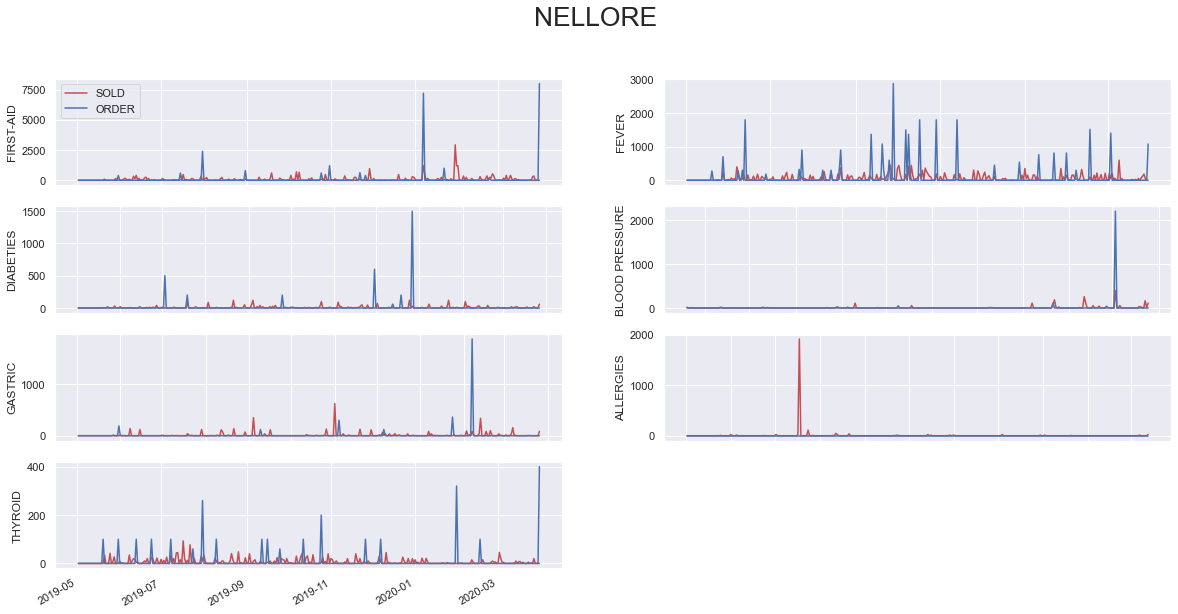

In [197]:
plot_by_city_all_diseases(df, 'NELLORE')

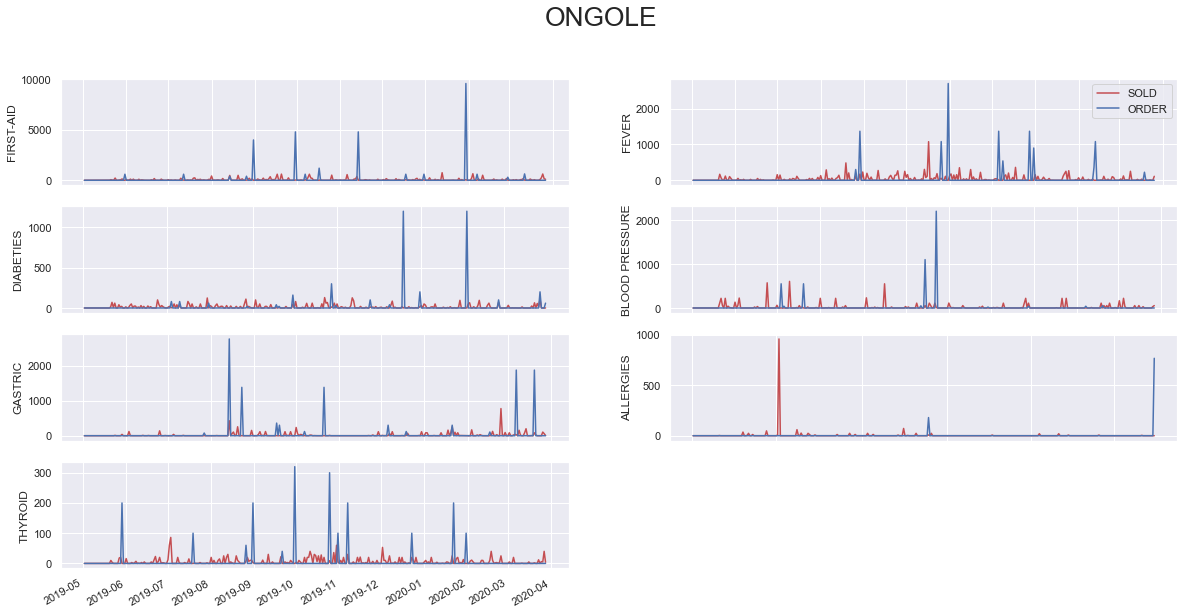

In [155]:
plot_by_city_all_diseases(df, 'ONGOLE')

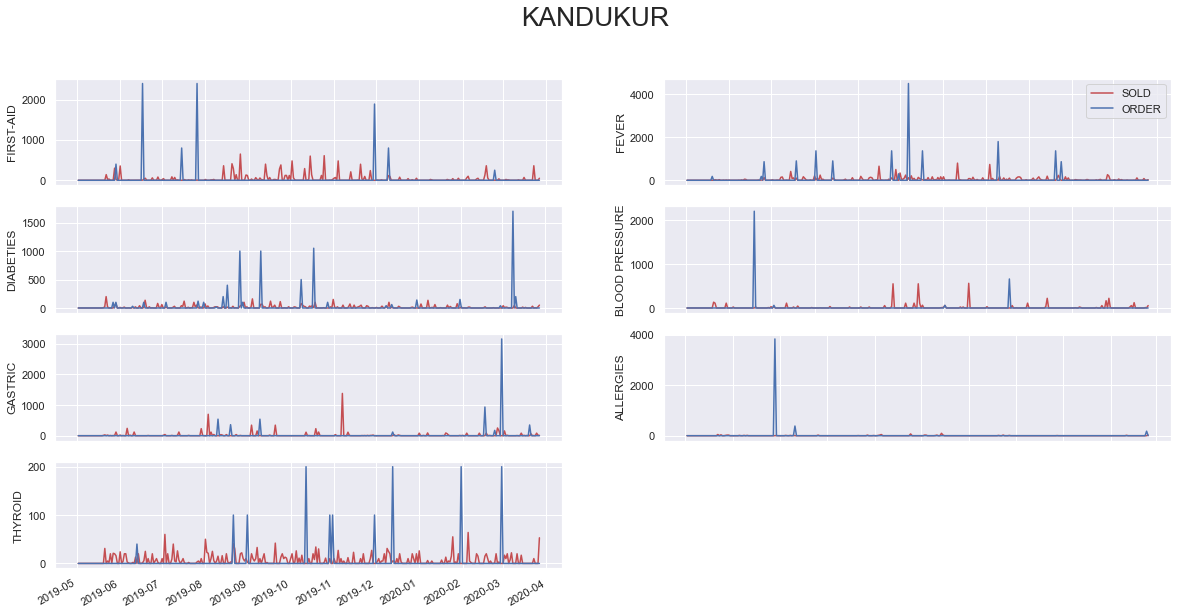

In [175]:
plot_by_city_all_diseases(df, 'KANDUKUR')

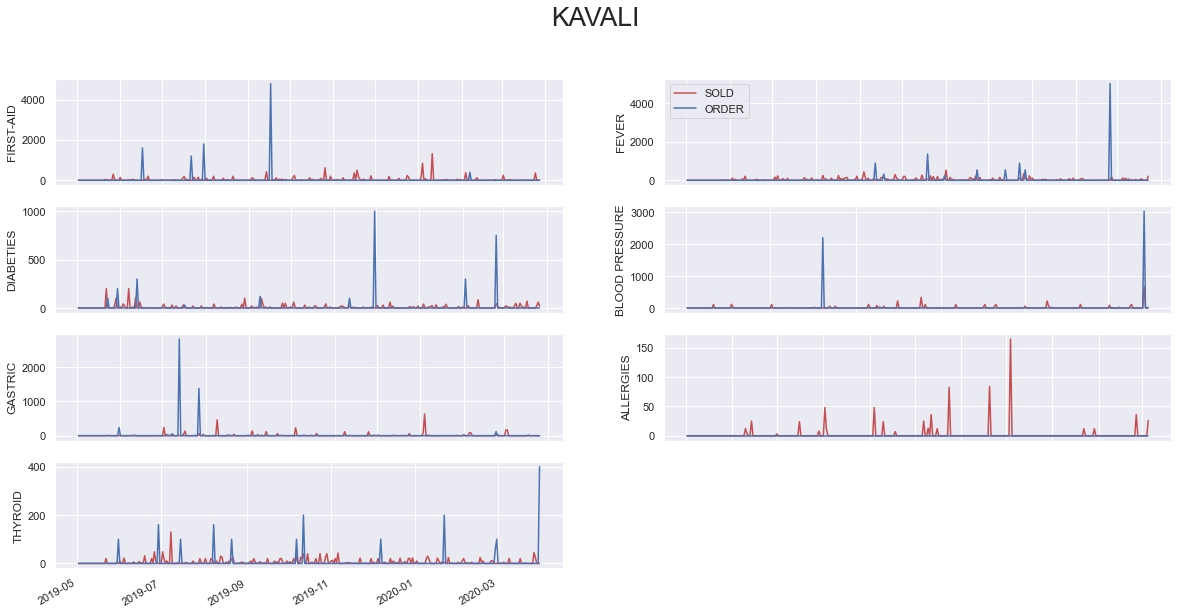

In [176]:
plot_by_city_all_diseases(df, 'KAVALI')

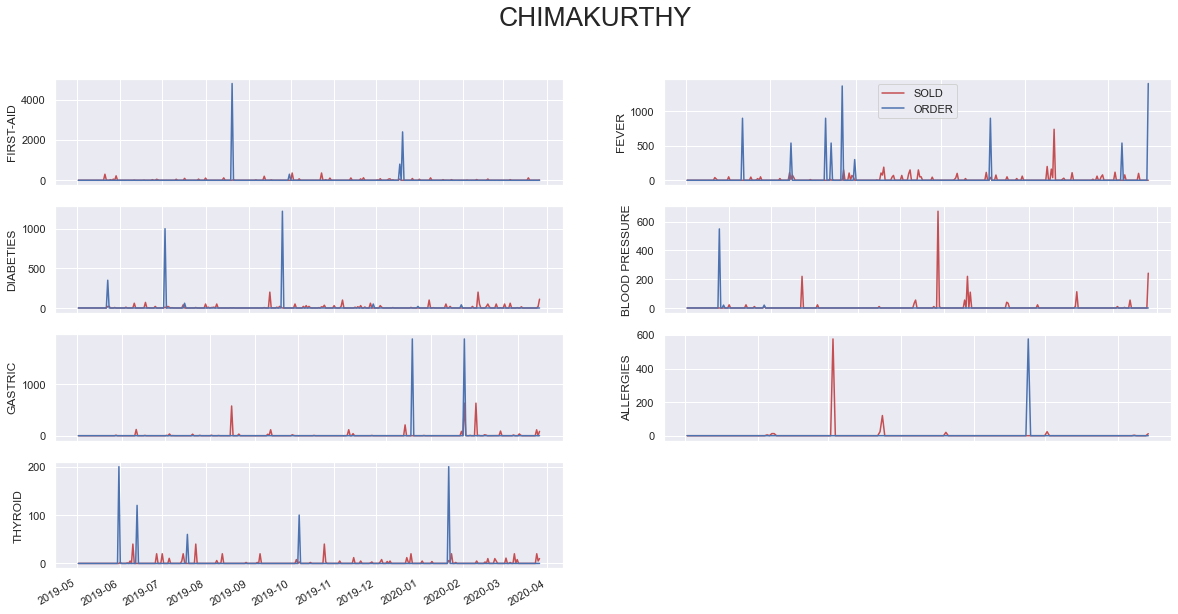

In [177]:
plot_by_city_all_diseases(df, 'CHIMAKURTHY')

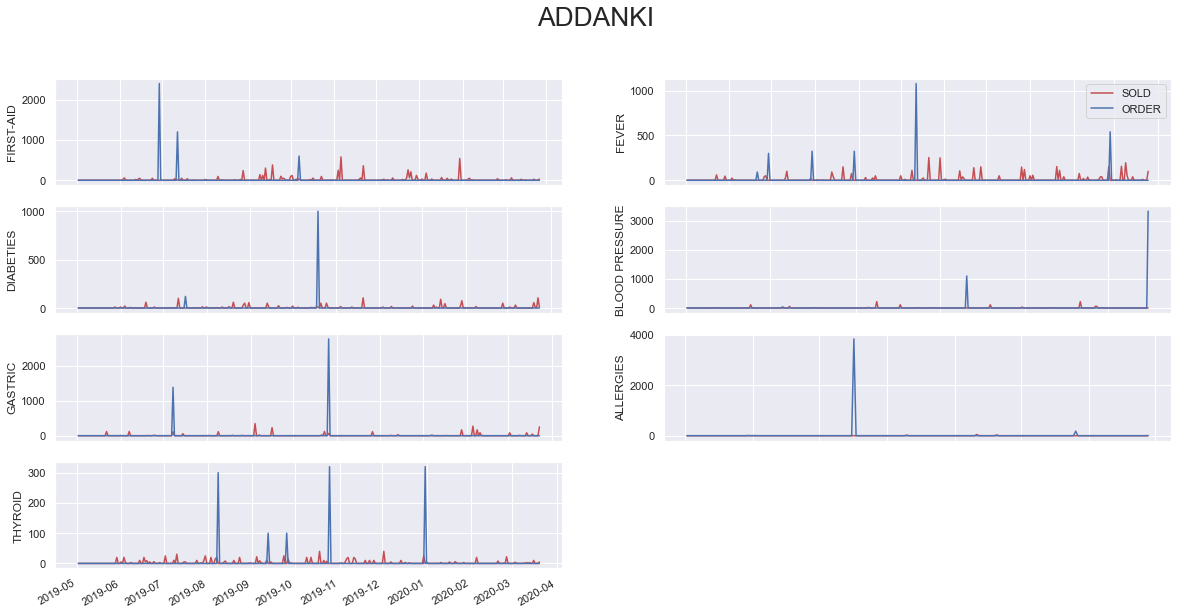

In [178]:
plot_by_city_all_diseases(df, 'ADDANKI')

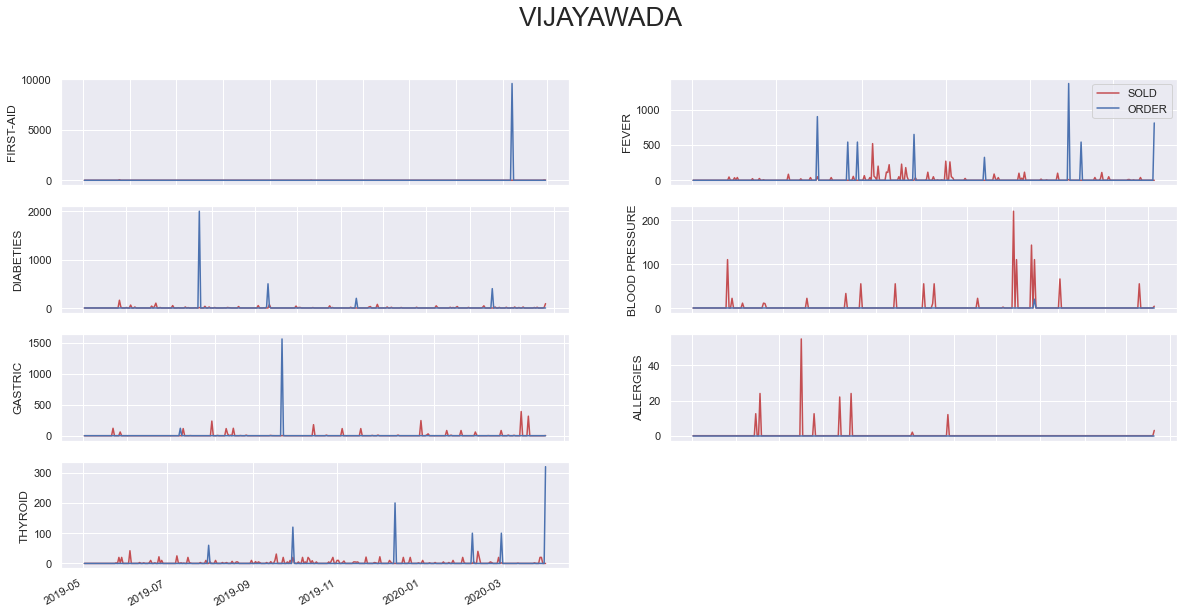

In [179]:
plot_by_city_all_diseases(df, 'VIJAYAWADA')

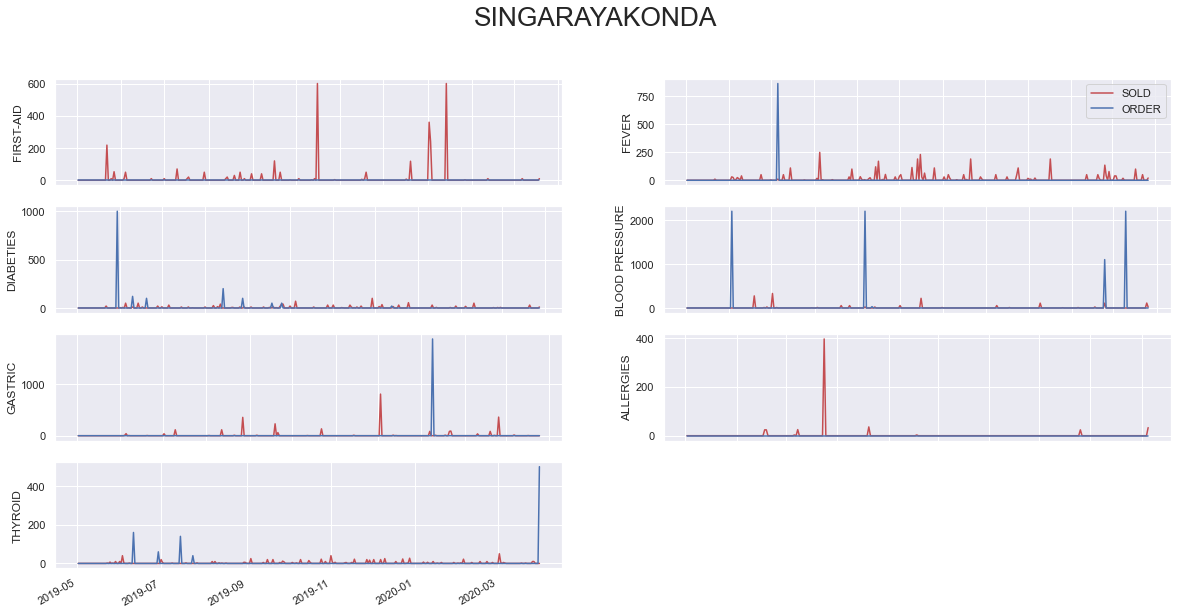

In [180]:
plot_by_city_all_diseases(df, 'SINGARAYAKONDA')

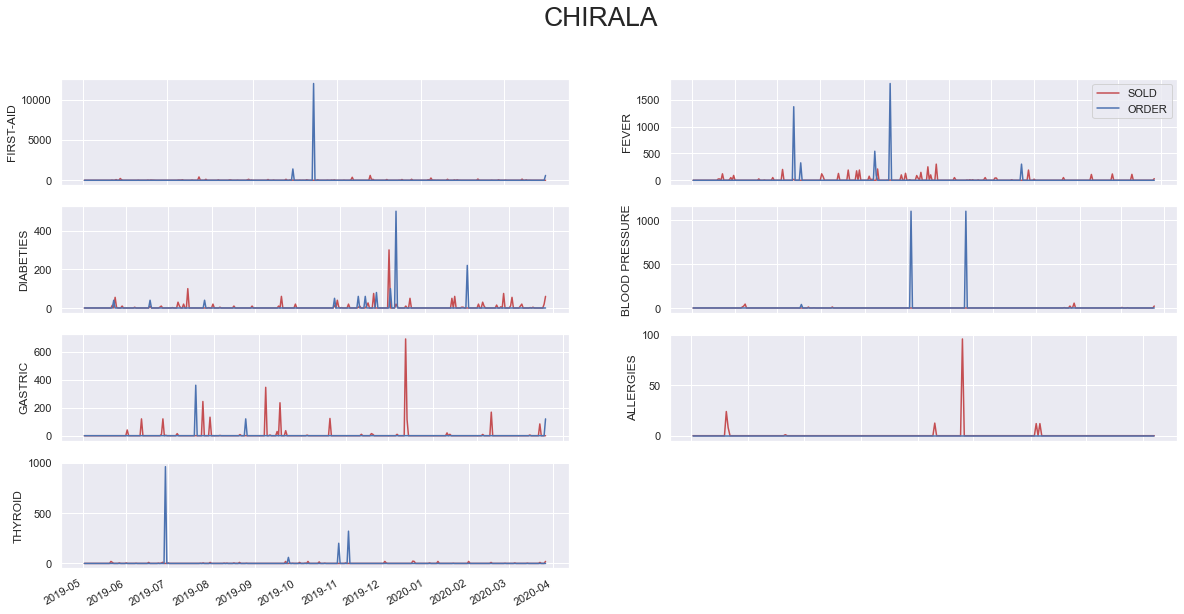

In [181]:
plot_by_city_all_diseases(df, 'CHIRALA')

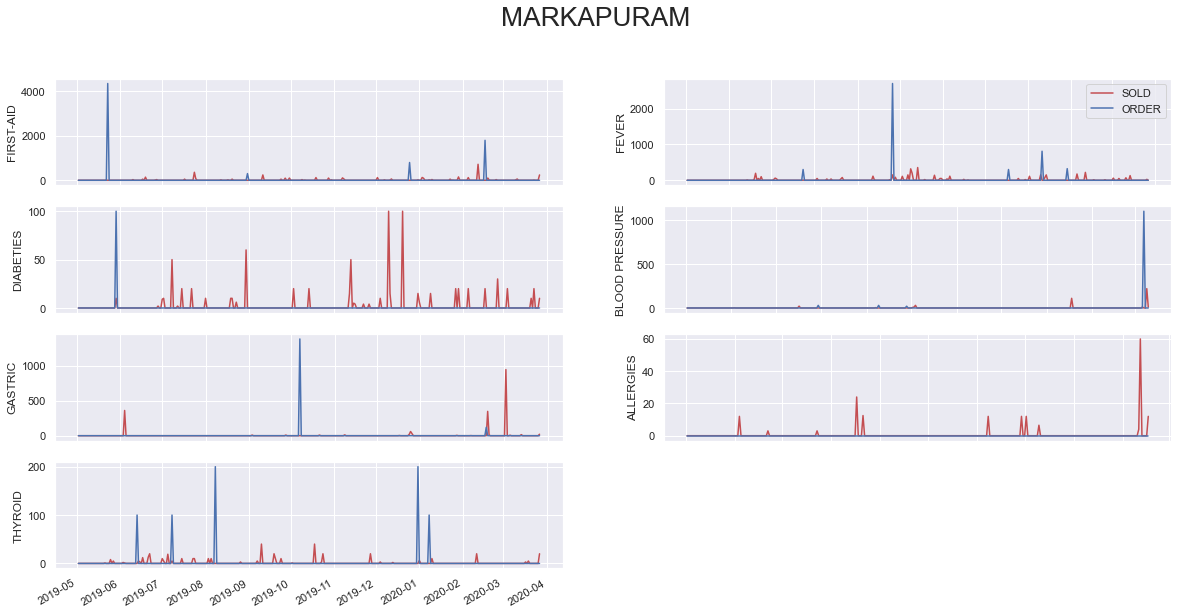

In [182]:
plot_by_city_all_diseases(df, 'MARKAPURAM')

In [199]:
def plot_by_diease_top_cities(df, disease_name, city_names):
    fig, axs = plt.subplots(5, 2, figsize=(20, 10))
    plt.rcParams.update({'font.size': 22})
    fig.autofmt_xdate()
    for i, ax in enumerate(axs.flat):
        plot_by_city_disease(df, city_names[i], disease_name, city_names[i], ax)
        if i==0:
            ax.legend(['SOLD','ORDER'])
    fig.suptitle(disease_name)

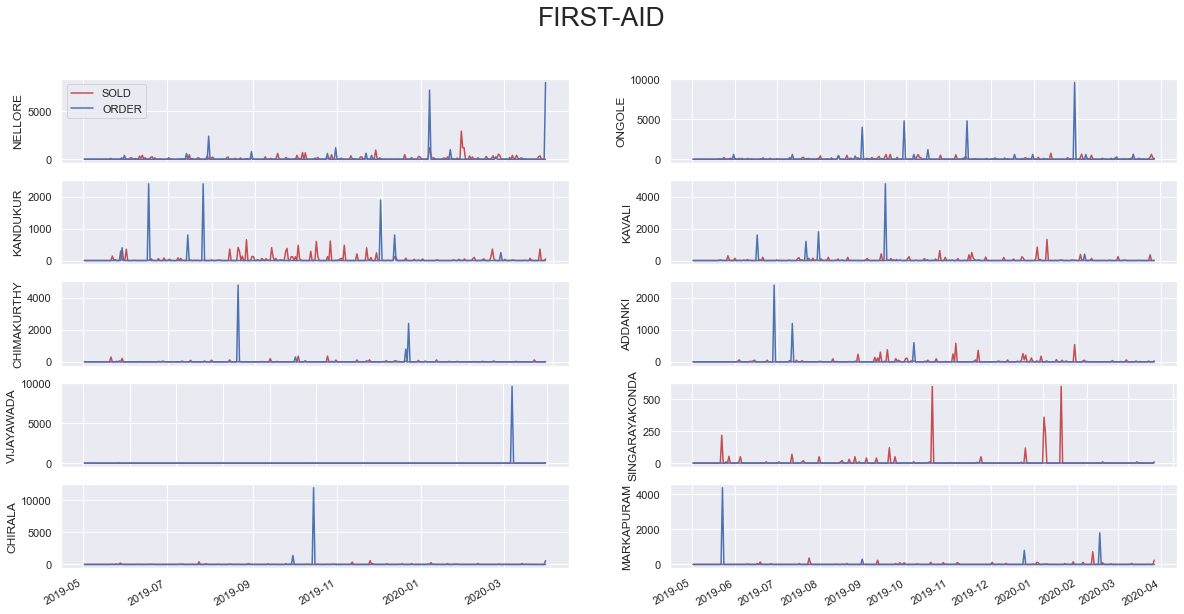

In [200]:
plot_by_diease_top_cities(df, 'FIRST-AID', city_list.city)

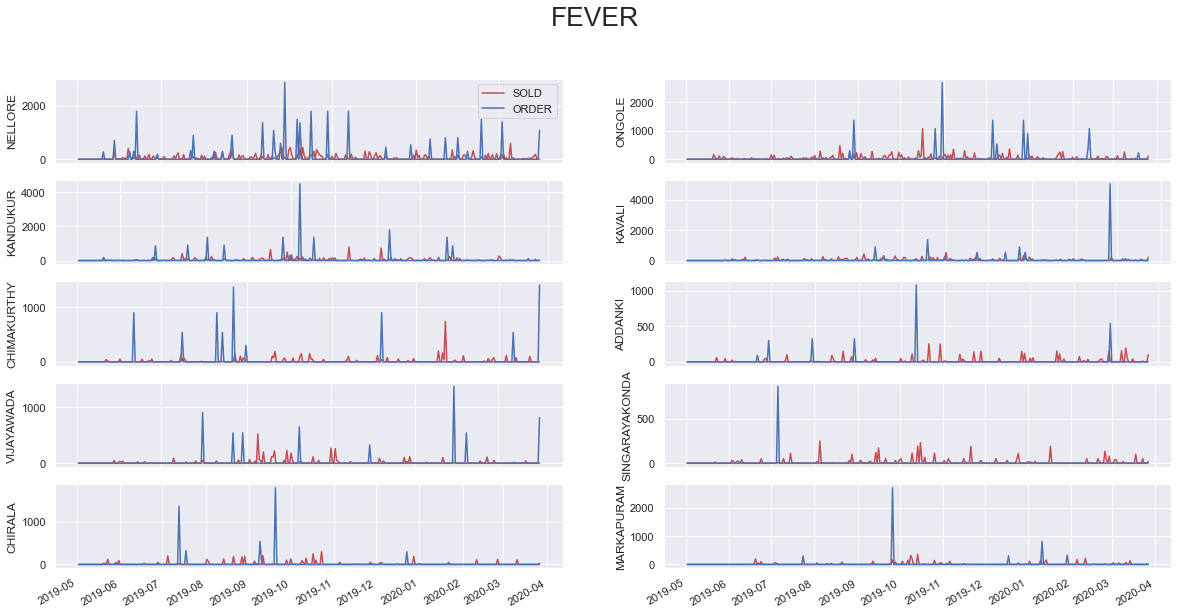

In [201]:
plot_by_diease_top_cities(df, 'FEVER', city_list.city)

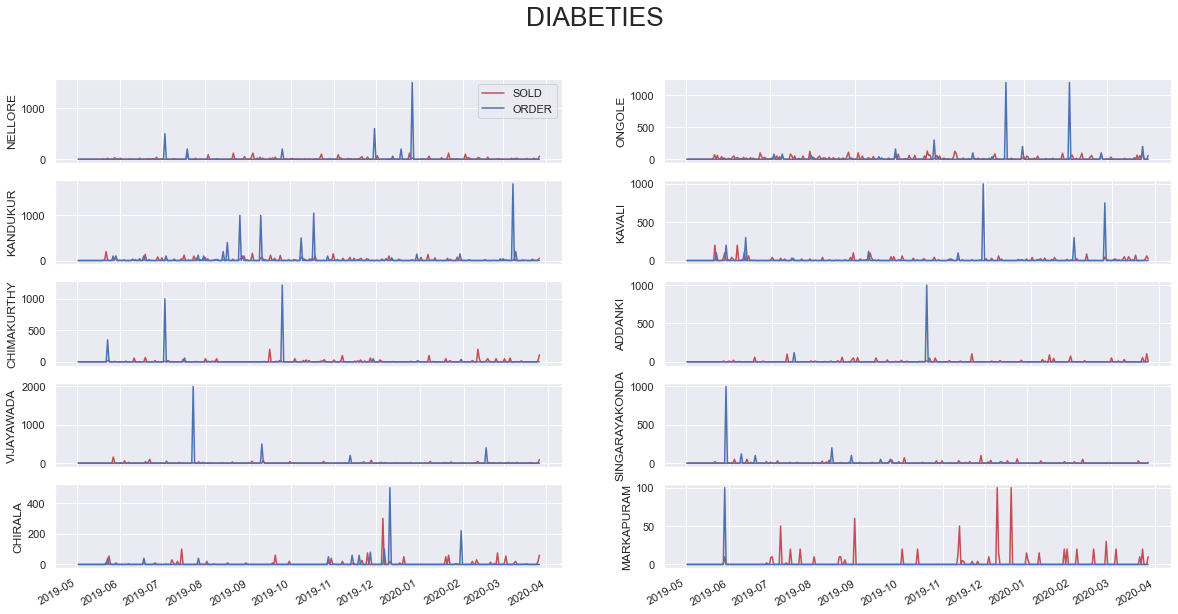

In [202]:
plot_by_diease_top_cities(df, 'DIABETIES', city_list.city)

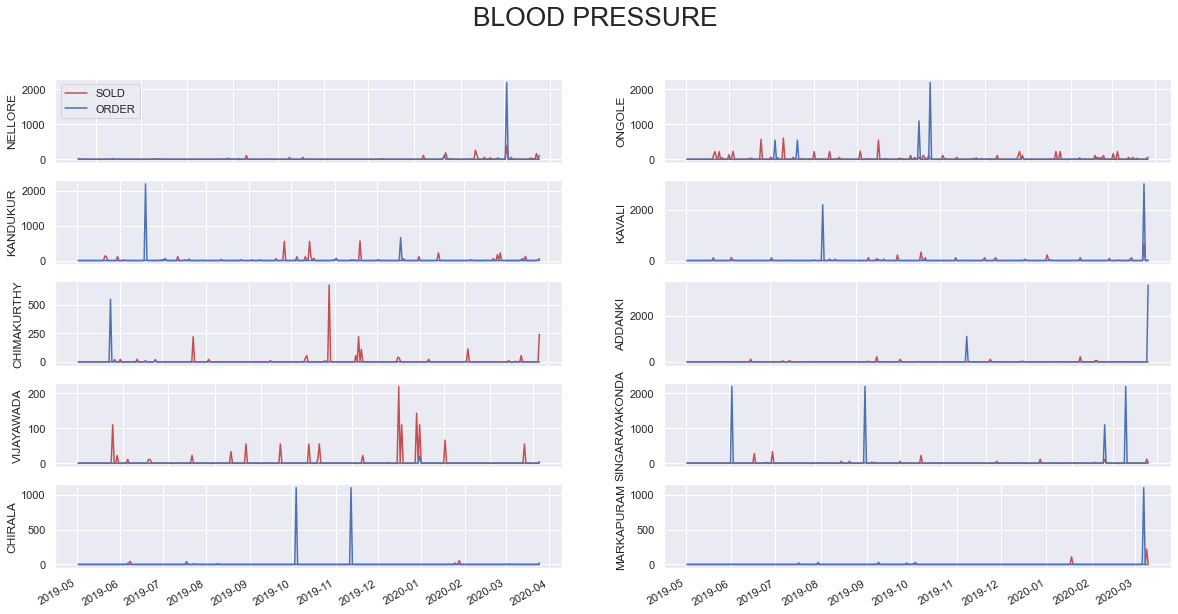

In [203]:
plot_by_diease_top_cities(df, 'BLOOD PRESSURE', city_list.city)

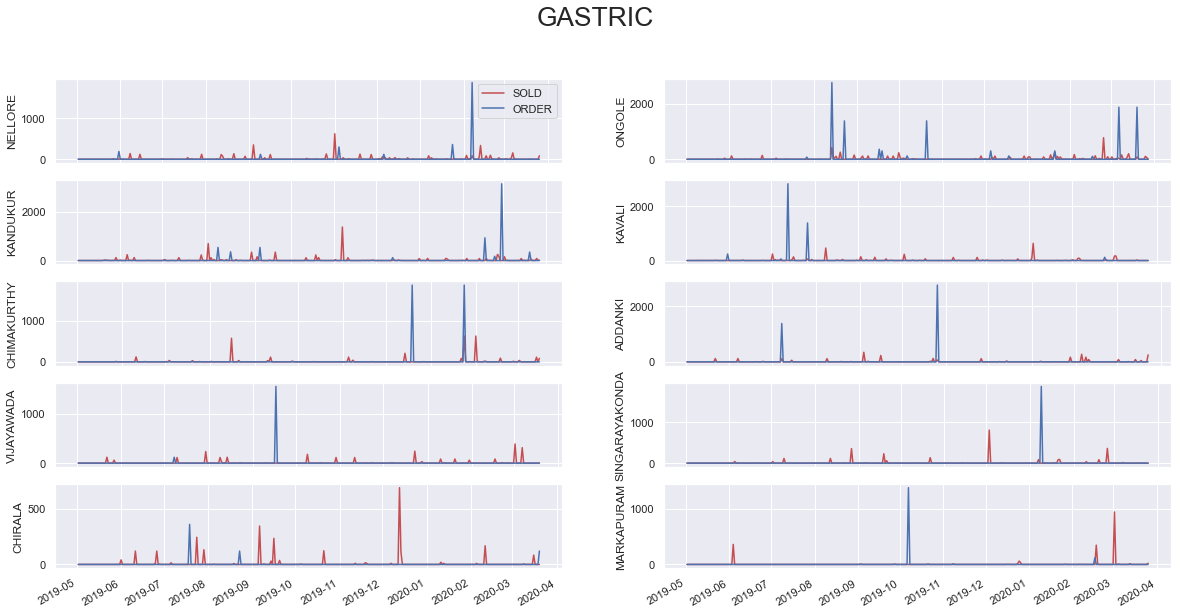

In [204]:
plot_by_diease_top_cities(df, 'GASTRIC', city_list.city)

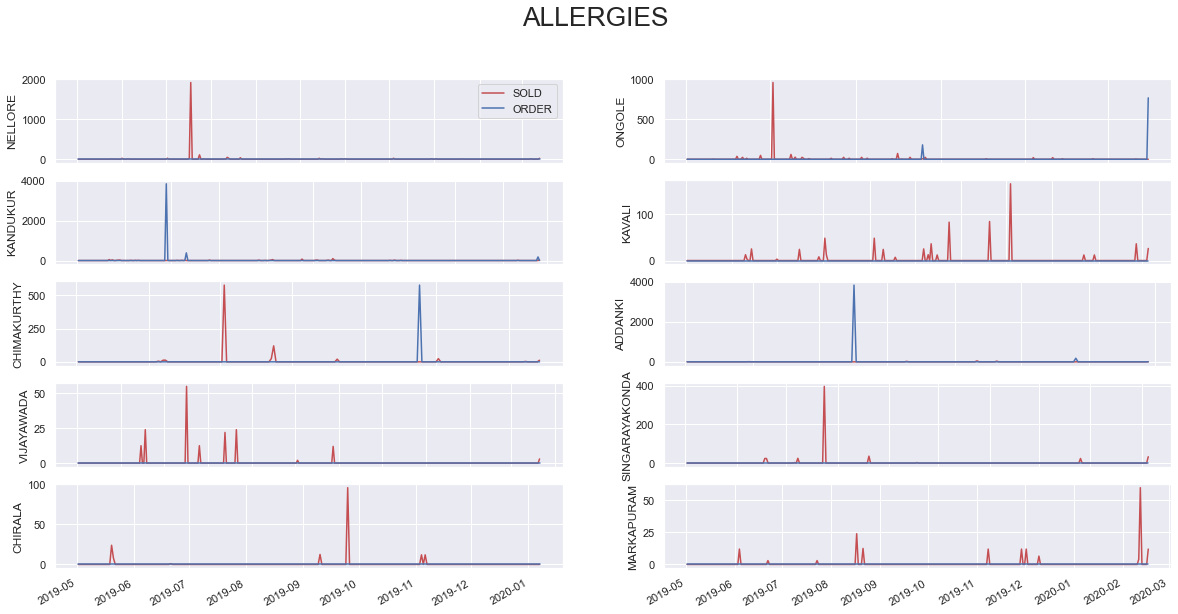

In [205]:
plot_by_diease_top_cities(df, 'ALLERGIES', city_list.city)

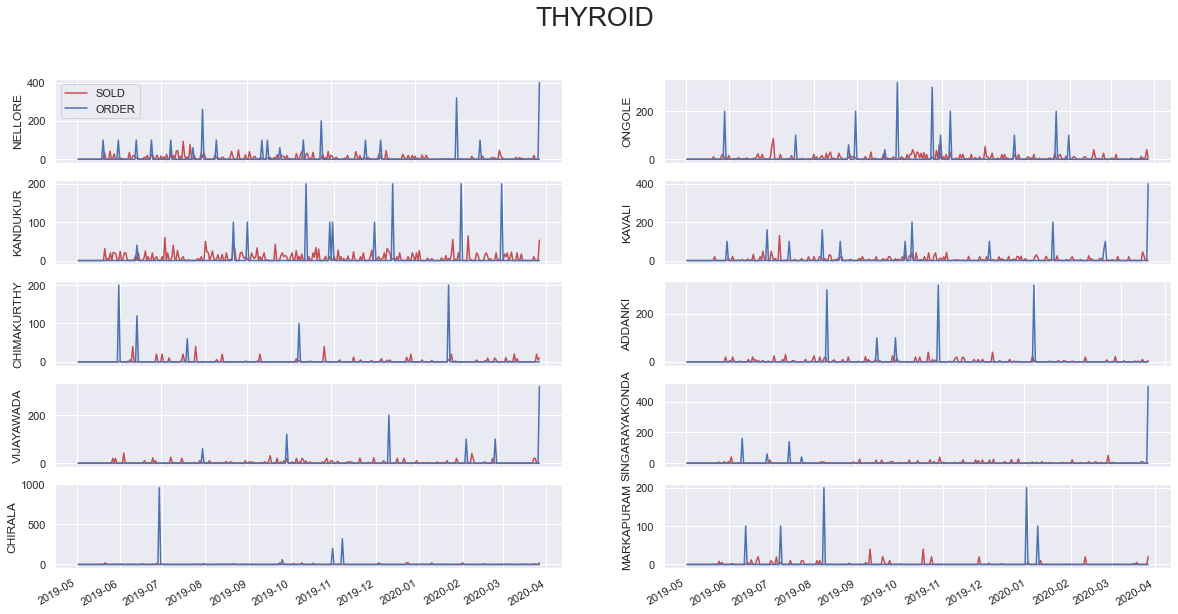

In [206]:
plot_by_diease_top_cities(df, 'THYROID', city_list.city)